| Student            | ID         | Email                          |
|--------------------|------------|--------------------------------|
| Riccardo Romeo     | 0001145681 | riccardo.romeo@studio.unibo.it|



# Deep Learning Project Work

This is the notebook produced as Project Work, carried out as individual work by Riccardo Romeo, of Deep Learning.

The Project consists in solving an Audio-Speech-Classification task using Deep Learning approaches on public data.

In particular, we are going to use as data the one of the [TensorFlow Speech Recognition Challenge](https://www.kaggle.com/competitions/tensorflow-speech-recognition-challenge). In this short work we are going to show different approaches based on two different data representations.

# Installing Dependencies

In [ ]:
!pip install pyunpack
!pip install patool
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


# Some Usefull Imports

In this section we are going to put all out import libraries.

In [ ]:
import os

import numpy as np
from numpy import ndarray
import pandas as pd
import random

import librosa

from IPython.display import Audio


import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
from tqdm import tqdm


from pyunpack import Archive
import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, Input, Resizing, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, AveragePooling2D, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

from keras_tuner import HyperModel
from kerastuner.tuners import RandomSearch

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

tqdm.pandas()

%matplotlib inline

# Setting environment

Here we set all the environment variables to ensure reproducibility.

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Downloading Data

Now, we need to download our data from the kaggle online repository.

In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

--2025-03-25 09:20:58--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.188.207, 192.178.163.207, 108.177.98.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.188.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   168MB/s    in 9.1s    

2025-03-25 09:21:08 (156 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [ ]:
!tar -xvzf speech_commands_v0.01.tar.gz

Output streaming troncato alle ultime 5000 righe.
./up/6f9088d7_nohash_0.wav
./up/6f342826_nohash_0.wav
./up/e0a7c5a0_nohash_0.wav
./up/4d4e17f5_nohash_1.wav
./up/b0f24c9b_nohash_0.wav
./up/735845ab_nohash_2.wav
./up/53d5b86f_nohash_0.wav
./up/1a5b9ca4_nohash_1.wav
./up/23abe1c9_nohash_2.wav
./up/bdee441c_nohash_1.wav
./up/a1cff772_nohash_1.wav
./up/1ecfb537_nohash_3.wav
./up/37fc5d97_nohash_3.wav
./up/bd8412df_nohash_1.wav
./up/e53139ad_nohash_1.wav
./up/10ace7eb_nohash_3.wav
./up/30065f33_nohash_0.wav
./up/eefd26f3_nohash_0.wav
./up/c9b653a0_nohash_2.wav
./up/02746d24_nohash_0.wav
./up/e1469561_nohash_0.wav
./up/4bba14ce_nohash_0.wav
./up/b5d1e505_nohash_1.wav
./up/531a5b8a_nohash_1.wav
./up/0135f3f2_nohash_0.wav
./up/dbb40d24_nohash_4.wav
./up/e9287461_nohash_1.wav
./up/71e6ab20_nohash_0.wav
./up/ead2934a_nohash_1.wav
./up/f9af0887_nohash_0.wav
./up/ff63ab0b_nohash_0.wav
./up/f3d06008_nohash_0.wav
./up/918a2473_nohash_4.wav
./up/e54a0f16_nohash_0.wav
./up/cb8f8307_nohash_1.wav
./up/

# Creating train, validation and test dataframes

First of all, we need to create our dataframes in order to display data and understand if our classes are balanced or imbalanced.

In [ ]:
def create_datasets(base_path, class_list):
    """
    Create train, validation, and test DataFrames from the given base path and class list.
    """
    # txt file path
    validation_file = os.path.join(base_path, 'validation_list.txt')
    test_file = os.path.join(base_path, 'testing_list.txt')

    # textual file reading
    with open(validation_file, 'r') as f:
        validation_paths = f.read().splitlines()

    with open(test_file, 'r') as f:
        test_paths = f.read().splitlines()


    validation_set = set(validation_paths)
    test_set = set(test_paths)


    train_data = []
    validation_data = []
    test_data = []


    for class_name in class_list:
        class_path = os.path.join(base_path, class_name)


        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):

                file_path = f"{class_name}/{filename}"


                if file_path in validation_set:
                    validation_data.append({'filename': filename, 'path': file_path, 'class': class_name})
                elif file_path in test_set:
                    test_data.append({'filename': filename, 'path': file_path, 'class': class_name})
                else:
                    train_data.append({'filename': filename, 'path': file_path, 'class': class_name})

    # Dataframes creation
    train_df = pd.DataFrame(train_data)
    validation_df = pd.DataFrame(validation_data)
    test_df = pd.DataFrame(test_data)

    return train_df, validation_df, test_df

In [ ]:
base_path = '/content'
class_list = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
train_df, validation_df, test_df = create_datasets(base_path, class_list)

In [ ]:
num_classes = len(class_list)

In [ ]:
print(f"In total we have a classification task with {num_classes} classes.")

In total we have a classification task with 30 classes.


Each audio could have a different duration. So, it is important to understand what is the duration distribution in our data in order to deal with this aspect.

In [ ]:
def get_duration(filepath: str) -> float:
    """
    Get the duration of an audio file.

    Args:
        filepath (str): The path to the audio file.

    Returns:
        float: The duration of the audio file in seconds.
    """
    samples, sample_rate = librosa.load(filepath, sr=None)
    duration = librosa.get_duration(y=samples, sr=sample_rate)
    return duration

In [ ]:
train_df["duration"] = train_df["path"].progress_apply(lambda x: get_duration(x))
validation_df["duration"] = validation_df["path"].progress_apply(lambda x: get_duration(x))
test_df["duration"] = test_df["path"].progress_apply(lambda x: get_duration(x))

100%|██████████| 6835/6835 [00:01<00:00, 5606.34it/s]


# Inspecting our data

Now, let's inspect our data.

In [ ]:
train_df.head()

filename                       path class  duration
0  988e2f9a_nohash_0.wav  bed/988e2f9a_nohash_0.wav   bed       1.0
1  e900b652_nohash_0.wav  bed/e900b652_nohash_0.wav   bed       1.0
2  92a9c5e6_nohash_0.wav  bed/92a9c5e6_nohash_0.wav   bed       1.0
3  652b3da7_nohash_0.wav  bed/652b3da7_nohash_0.wav   bed       1.0
4  d8c52371_nohash_0.wav  bed/d8c52371_nohash_0.wav   bed       1.0

In [ ]:
train_df.describe()

duration
count  51088.000000
mean       0.984141
std        0.060123
min        0.371563
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000

In [ ]:
def plot_class_histograms(train_df, validation_df, test_df):
    """
    Plots histograms of class distributions for training, validation, and test datasets.

    Parameters:
    ----------
    train_df : DataFrame
        The DataFrame containing the training set with a 'class' column.

    validation_df : DataFrame
        The DataFrame containing the validation set with a 'class' column.

    test_df : DataFrame
        The DataFrame containing the test set with a 'class' column.

    Returns:
    -------
    None
        This function does not return a value. It generates and displays
        histograms for the class distributions in the provided datasets using Matplotlib.
    """

    # List of DataFrames
    dataframes = [train_df, validation_df, test_df]
    titles = ['Classes in train set', 'Classes in validation set', 'Classes in test set']

    # Create a histogram for each DataFrame
    for i, df in enumerate(dataframes):
        plt.figure(figsize=(18, 2))
        df['class'].value_counts().plot(kind='bar', color='blue')

        # Add title and labels
        plt.title(titles[i], fontsize=16, color='red')
        plt.xlabel('Classes', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xticks(rotation=0)

        # Show the histogram
        plt.show()


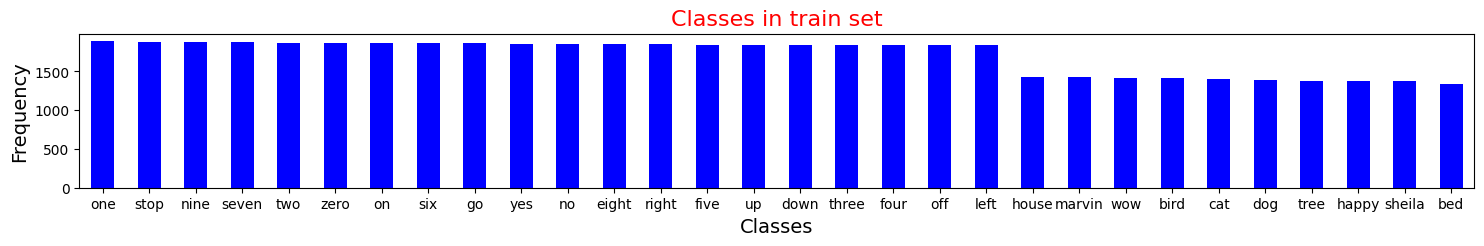

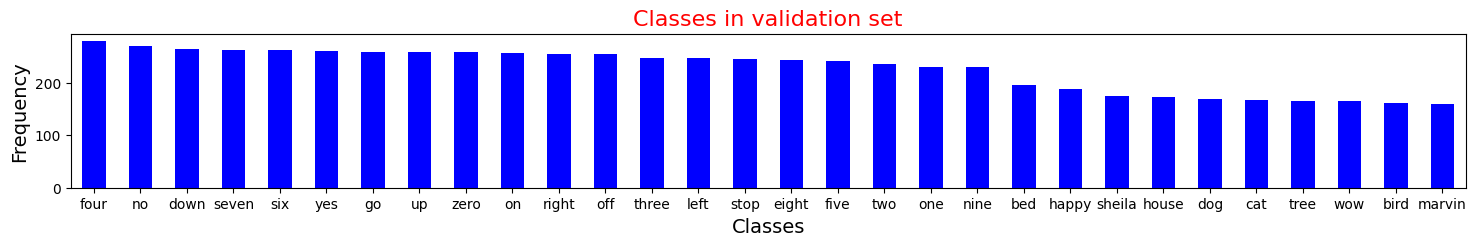

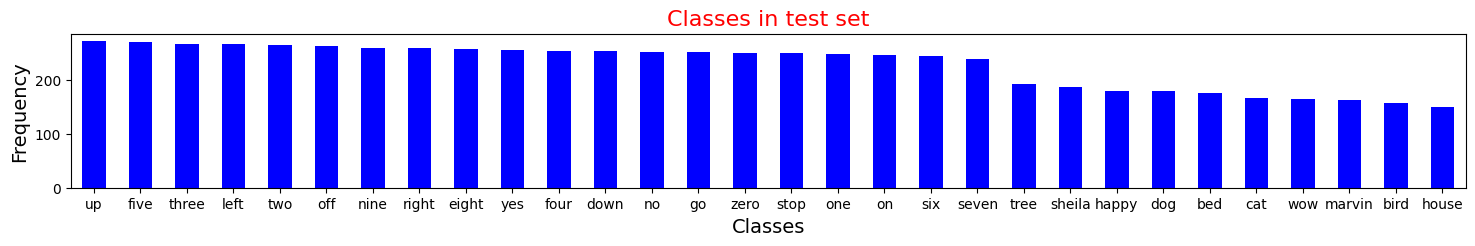

In [ ]:
plot_class_histograms(train_df, validation_df, test_df)

As we can see the datasets are pretty balanced.

In [ ]:
def plot_duration_histograms(train_df, validation_df, test_df):
    """
    Plots histograms of durations for training, validation, and test datasets.

    Parameters:
    ----------
    train_df : DataFrame
        The DataFrame containing the training set with a 'duration' column.

    validation_df : DataFrame
        The DataFrame containing the validation set with a 'duration' column.

    test_df : DataFrame
        The DataFrame containing the test set with a 'duration' column.

    Returns:
    -------
    None
        This function does not return a value. It generates and displays
        histograms for the durations in the provided datasets using Matplotlib.
    """

    # Create the figure and axes
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Histogram for the first DataFrame
    axs[0].hist(train_df['duration'], bins=30, color='blue', alpha=0.7)
    axs[0].set_title('Durations in train set')
    axs[0].set_xlabel('Duration')
    axs[0].set_ylabel('Frequency')

    # Histogram for the second DataFrame
    axs[1].hist(validation_df['duration'], bins=30, color='green', alpha=0.7)
    axs[1].set_title('Durations in validation set')
    axs[1].set_xlabel('Duration')
    axs[1].set_ylabel('Frequency')

    # Histogram for the third DataFrame
    axs[2].hist(test_df['duration'], bins=30, color='red', alpha=0.7)
    axs[2].set_title('Durations in test set')
    axs[2].set_xlabel('Duration')
    axs[2].set_ylabel('Frequency')

    # Add a general title
    plt.suptitle('Histogram of Durations in the dataset', color='red')

    # Show the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout
    plt.show()

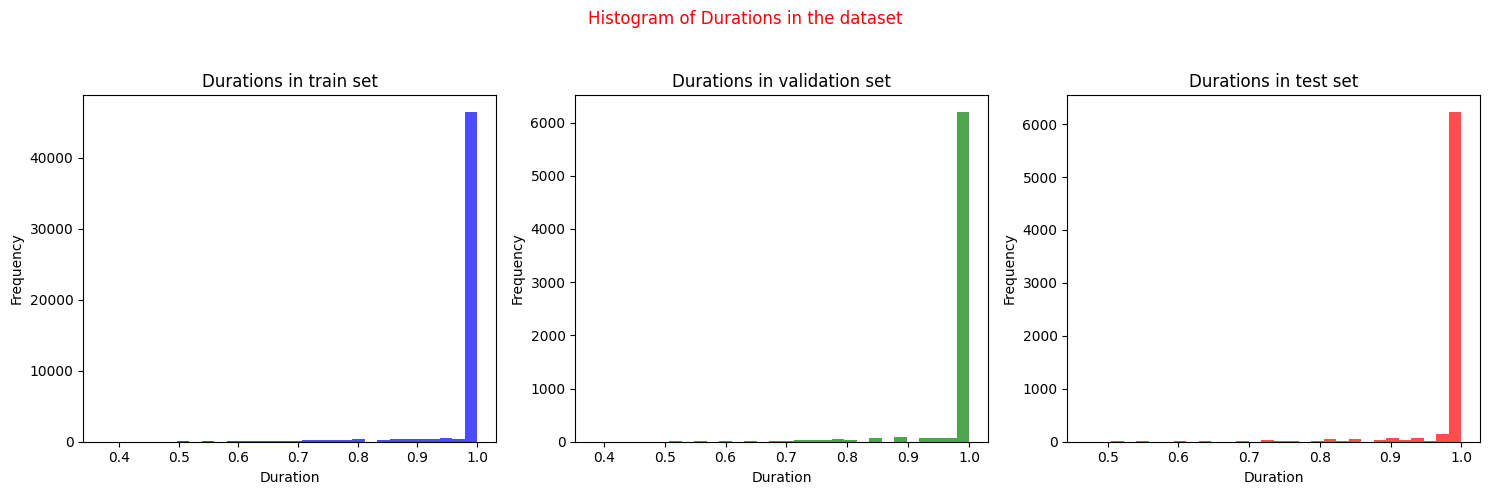

In [ ]:
plot_duration_histograms(train_df, validation_df, test_df)

As we can see some audio don't have the duration of 1 second. So, it is clear that we need to zero pad them in order to have similar MFCC to give as input to our model.


Now, we need to undertand that it is possible to represent an audio using its spectrogram. In particular we are going to display two representations:


*   STFT: The short-time Fourier transform (STFT) is a Fourier-related transform used to determine the sinusoidal frequency and phase content of local sections of a signal as it changes over time;
*   MFCCs: the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound. Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC.



In [ ]:
def play_random_audio_and_plot_waveform_mfcc_stft(df):
    """
    Select a random audio from the DataFrame, play it,
    and plot the waveform, MFCC spectrogram, and STFT spectrogram.
    """

    # Selects a casual path from the 'path' column
    random_index = random.choice(df.index)
    audio_path = df.loc[random_index, 'path']

    # Load audio with librosa
    audio_data, sample_rate = librosa.load(audio_path)

    # Audio display
    display(Audio(audio_path, rate=sample_rate))

    # Waveform printing
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio_data, sr=sample_rate, color='blue')
    plt.title(f'Waveform of audio: {audio_path}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

    # MFCC spectogram computation and display
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', cmap='coolwarm')
    plt.title(f'MFCC Spectrogram of audio: {audio_path}')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('MFCC Coefficients')
    plt.grid()
    plt.show()

    # STFT spectogram computation and display
    D = librosa.stft(audio_data)
    S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.title(f'STFT Spectrogram of audio: {audio_path}')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()
    plt.show()


    return audio_path

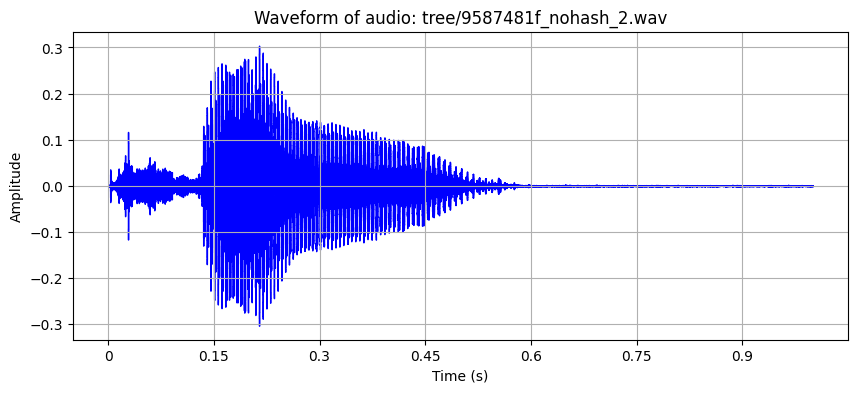

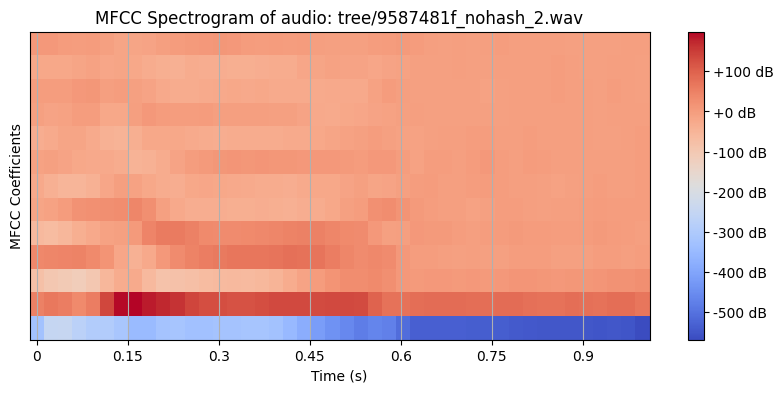

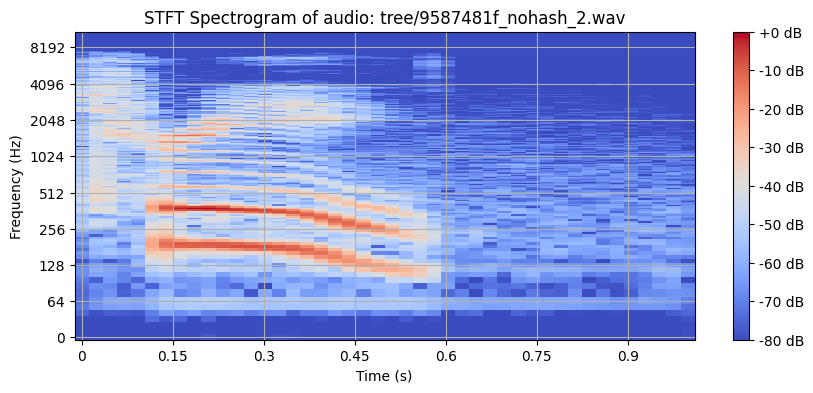

In [ ]:
casual_audio_path = play_random_audio_and_plot_waveform_mfcc_stft(train_df)

Here we can easily deal with the first idea: using these spectrograms, those are 2D arrays (images), as input to a Convolutional Neural Network.

# Features Extraction and Engineering

Not all our audios present a duration equal to 1.0 second. So, we need to zero-pad their waveforms in order to have Spectrograms with similar dimensions.

Now we are going to add the waveform and the MFCCs to our dataframes for each audio.

In [ ]:
def add_waveform_column(df, target_duration, sample_rate=16000):
    """
    Adds a 'waveform' column to the DataFrame containing the audio waveforms.
    The waveforms are zero-padded to have a duration equal to 'target_duration'.

    Parameters:
    - df: DataFrame containing the audio paths in the 'path' column.
    - target_duration: Target duration in seconds for the waveforms.
    - sample_rate: Sampling frequency of the audio (default is 16000).

    Returns:
    - df: Updated DataFrame with the 'waveform' column.
    """

    # Calculate the number of samples for the target duration
    target_samples = int(target_duration * sample_rate)

    # Add the 'waveform' column
    waveforms = []

    for index, row in df.iterrows():
        audio_path = row['path']

        # Load the audio
        audio_data, sr = librosa.load(audio_path, sr=sample_rate)

        # Zero-padding if necessary
        if len(audio_data) < target_samples:
            # Add zero-padding
            padded_waveform = np.pad(audio_data, (0, target_samples - len(audio_data)), mode='constant')
        else:
            # Truncate the audio if it is longer than the target duration
            padded_waveform = audio_data[:target_samples]

        waveforms.append(padded_waveform)

    # Add the list of waveforms as a new column
    df['waveform'] = waveforms

    return df

In [ ]:
sample_rate = 16000
train_df = add_waveform_column(train_df, target_duration=1.0, sample_rate = sample_rate)
validation_df = add_waveform_column(validation_df, target_duration=1.0, sample_rate = sample_rate)
test_df = add_waveform_column(test_df, target_duration=1.0, sample_rate = sample_rate)

In [ ]:
def add_mfcc_column(df, sample_rate=16000):
    """
    Adds an 'mfcc' column to the DataFrame containing the MFCC coefficients of the waveforms.

    Parameters:
    - df: DataFrame containing the waveforms in the 'waveform' column.
    - n_mfcc: Number of MFCC coefficients to calculate (default is 13).

    Returns:
    - df: Updated DataFrame with the 'mfcc' column.
    """
    mfccs_list = []

    for index, row in df.iterrows():
        waveform = row['waveform']

        # Calculate the MFCC coefficients
        mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate)

        # Add the MFCCs to the list
        mfccs_list.append(mfccs)

    # Add the list of MFCCs as a new column
    df['mfcc'] = mfccs_list

    return df

In [ ]:
train_df = add_mfcc_column(train_df, sample_rate = sample_rate)
validation_df = add_mfcc_column(validation_df, sample_rate = sample_rate)
test_df = add_mfcc_column(validation_df, sample_rate = sample_rate)

In [ ]:
print("Number of elements in train dataframe:", len(train_df))
print("Number of elements in validation dataframe:", len(validation_df))
print("Number of elements in test dataframe:", len(test_df))

Number of elements in train dataframe: 51088
Number of elements in validation dataframe: 6798
Number of elements in test dataframe: 6798


# Input Data Creation

In order to train and test our models we need to create Tensorflow Dataframes.

In [ ]:
def create_tf_dataset(df):
    """
    Creates a TensorFlow dataset from a DataFrame.

    Parameters:
    - df: DataFrame containing the columns 'mfcc' and 'class'.

    Returns:
    - dataset: TensorFlow Dataset containing the data and labels.
    """

    # Extract the data and labels from the DataFrame
    mfccs = df['mfcc'].tolist()  # List of MFCC features
    labels = df['class'].tolist()  # List of class labels

    # Convert string labels to numerical values
    label_encoder = LabelEncoder()  # Initialize the label encoder
    labels_encoded = label_encoder.fit_transform(labels)  # Encode labels

    # Convert the numerical labels to one-hot encoding
    labels_one_hot = to_categorical(labels_encoded, num_classes=30)  # One-hot encode the labels

    # Create the TensorFlow dataset from the MFCC features and one-hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((mfccs, labels_one_hot))

    return dataset  # Return the created TensorFlow dataset

In [ ]:
train_ds = create_tf_dataset(train_df).shuffle(buffer_size = 10000)
validation_ds = create_tf_dataset(validation_df).shuffle(buffer_size = 10000)
test_ds = create_tf_dataset(test_df).shuffle(buffer_size = 10000)

In [ ]:
def add_channel_dimension(mfcc, label):
    mfcc_with_channel = tf.expand_dims(mfcc, axis=-1)
    return mfcc_with_channel, label

In [ ]:
train_ds = train_ds.map(add_channel_dimension)
validation_ds = validation_ds.map(add_channel_dimension)
test_ds = test_ds.map(add_channel_dimension)

In [ ]:
count = train_ds.reduce(0, lambda x, _: x + 1).numpy()
print("Number of elements in train dataset:", count)
count = validation_ds.reduce(0, lambda x, _: x + 1).numpy()
print("Number of elements in validation dataset:", count)
count = test_ds.reduce(0, lambda x, _: x + 1).numpy()
print("Number of elements in test dataset:", count)

Number of elements in train dataset: 51088
Number of elements in validation dataset: 6798
Number of elements in test dataset: 6798


As we can see the number of input audios is consistently high.

# Some Usefull functions for our models

In this section we display the code of some usefull functions used to evaluate and display the performances of our models.

In [ ]:
def plot_model_history(history, title=""):
    """
    Plots the training history of a Keras model.

    Parameters:
    - history: A Keras History object containing training metrics.
    - title: (Optional) A string to set the title of the plot.
    """

    # Extract values from the history object
    loss = history.history['loss']  # Training loss values
    val_loss = history.history['val_loss']  # Validation loss values
    accuracy = history.history['accuracy']  # Training accuracy values
    val_accuracy = history.history['val_accuracy']  # Validation accuracy values
    f1_score = history.history['f1_score']  # Training F1 score values
    val_f1_score = history.history['val_f1_score']  # Validation F1 score values

    # Create the figure
    plt.figure(figsize=(15, 10))

    # Plot 1: Categorical Crossentropy Loss
    plt.subplot(3, 1, 1)
    plt.plot(loss, label='Train Loss')  # Plot training loss
    plt.plot(val_loss, label='Validation Loss')  # Plot validation loss
    plt.title('Categorical Crossentropy Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot 2: Accuracy
    plt.subplot(3, 1, 2)
    plt.plot(accuracy, label='Train Accuracy')  # Plot training accuracy
    plt.plot(val_accuracy, label='Validation Accuracy')  # Plot validation accuracy
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot 3: F1 Score
    plt.subplot(3, 1, 3)
    plt.plot(f1_score, label='Train F1 Score')  # Plot training F1 score
    plt.plot(val_f1_score, label='Validation F1 Score')  # Plot validation F1 score
    plt.title('F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend()

    plt.suptitle(title, fontsize=16, color='red')  # Set the overall title
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plots

In [ ]:
def plot_confusion_matrix(model, test_ds, class_names, title=""):
    """
    Plots the confusion matrix for the given model and test dataset.

    Parameters:
    ----------
    model : Keras Model
        The trained model used to make predictions on the test dataset.

    test_ds : TensorFlow Dataset
        A dataset containing test audio data and corresponding labels.
        Each element is a tuple of (audio, label).

    class_names : list of str
        A list of class names corresponding to the labels in the dataset.

    title : str, optional
        A title for the confusion matrix plots (default is "").

    Returns:
    -------
    None
        This function does not return a value. It generates and displays
        two heatmaps of the confusion matrix (one normalized and one
        non-normalized) using Matplotlib and Seaborn.
    """
    test_audio = []
    test_labels = []

    for audio, label in test_ds:
        # Collect the audio and labels as numpy arrays
        test_audio.append(audio.numpy())  # appending batch data
        test_labels.append(label.numpy())  # appending labels for the batch

    # Convert the list of batches into a single numpy array
    test_audio = np.concatenate(test_audio, axis=0)  # Combine along batch dimension
    test_labels = np.concatenate(test_labels, axis=0)  # Combine labels

    # Make predictions
    y_pred = np.argmax(model.predict(test_audio), axis=1)  # Predicted class labels
    y_true = test_labels.argmax(axis=1)  # True class labels (if one-hot encoded)

    # Generate confusion matrix
    confusion_mtx = confusion_matrix(y_true, y_pred)
    confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrices
    fig, axes = plt.subplots(2, 1, figsize=(15, 20))

    # Non-normalized confusion matrix
    sns.heatmap(confusion_mtx,
                xticklabels=class_names,
                yticklabels=class_names,
                annot=True, fmt='g', ax=axes[0])
    axes[0].set_xlabel('Prediction')
    axes[0].set_ylabel('Label')
    axes[0].set_title(f'{title} - Non-Normalized', color="blue")

    # Normalized confusion matrix
    sns.heatmap(confusion_mtx_normalized,
                xticklabels=class_names,
                yticklabels=class_names,
                annot=True, fmt='.2f', ax=axes[1])
    axes[1].set_xlabel('Prediction')
    axes[1].set_ylabel('Label')
    axes[1].set_title(f'{title} - Normalized', color="blue")

    plt.suptitle(title, fontsize=16, color="red")
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

# Model Implementation

In this section we are going to create our CNN model in order to classify our MFCCs.
But, firstly, we need to define some constants that we are going to use...

Note that, since our 2D input tensors are audio features we don't need to preserve their aspect ration. So, we can try to resize them in a more easy-to-use format. Thus, the first layer of our architecture is going to be a Resizing layer.

In [ ]:
NUM_CLASSES = len(class_list)
INPUT_SHAPE = train_ds.element_spec[0].shape
TARGET_SHAPE = (32, 32)
BATCH_SIZE = 32

## Model 1: "The Simplest Baseline"

In honor of Occam's Razor we start implementing probably the simplest possible model.

This model will have the following structure:

CONV -> ReLU -> MaxPool -> FC -> ReLU -> FC

Probably this model will be not enough to catch the complexity in our input audios. But, it could be a good starting point.

In [ ]:
# WE BATCH OUT TENSORFLOW DATASETS IF NECESSARY
if train_ds.element_spec[0].shape != (None, 20, 32, 1):
  train_ds = train_ds.batch(BATCH_SIZE)
if validation_ds.element_spec[0].shape != (None, 20, 32, 1):
  validation_ds = validation_ds.batch(BATCH_SIZE)
if test_ds.element_spec[0].shape != (None, 20, 32, 1):
  test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
# MODEL1: CONV -> ReLU -> MaxPool -> FC -> ReLU -> FC
model1 = Sequential([
    Input(shape=INPUT_SHAPE),
    Resizing(TARGET_SHAPE[0], TARGET_SHAPE[1]),

    Conv2D(16, 3,  activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax'),
])

In the following we can see that this model is really tiny, thus it will be fastly trainable. But also, poor in terms of accuracy.

In [ ]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         360,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           3,030 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 363,290 (1.39 MB)

 Trainable params: 363,290 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

Now, we are going to use as optimizer AdamW because is seems to better work with images.

While, as loss we are going to use, obviously, a Categorical Crossentropy loss.

Also, we will print as metrics the accuracy and the averaged F1-Score.

In [ ]:
model1.compile(
    optimizer = tf.keras.optimizers.AdamW(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

We want to take under controll the validation loss in order to decide when stop the training process due to none improvement.

In [ ]:
model1_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             min_delta=0.001,
                                             verbose=1,
                                             patience=3,
                                             restore_best_weights=True)

Now, we can start the training process.

In [ ]:
EPOCHS = 25
history1 = model1.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = EPOCHS,
    callbacks=model1_es
)

Epoch 1/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.4365 - f1_score: 0.4335 - loss: 3.4214 - val_accuracy: 0.2123 - val_f1_score: 0.1287 - val_loss: 2.9216
Epoch 2/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3420 - f1_score: 0.3306 - loss: 2.2123 - val_accuracy: 0.3005 - val_f1_score: 0.2326 - val_loss: 2.6755
Epoch 3/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5854 - f1_score: 0.5849 - loss: 1.3095 - val_accuracy: 0.4197 - val_f1_score: 0.3576 - val_loss: 2.1666
Epoch 4/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6491 - f1_score: 0.6510 - loss: 1.1103 - val_accuracy: 0.4625 - val_f1_score: 0.4160 - val_loss: 1.9643
Epoch 5/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7101 - f1_score: 0.7143 - loss: 0.9277 - val_accuracy: 0.5260 - val_f1_score: 0.5023 - val_loss: 1.7014
Epoch 6/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7454 - f1_score: 0.7496 - loss: 0.8139 - val_accuracy: 0.5260 - val_f1

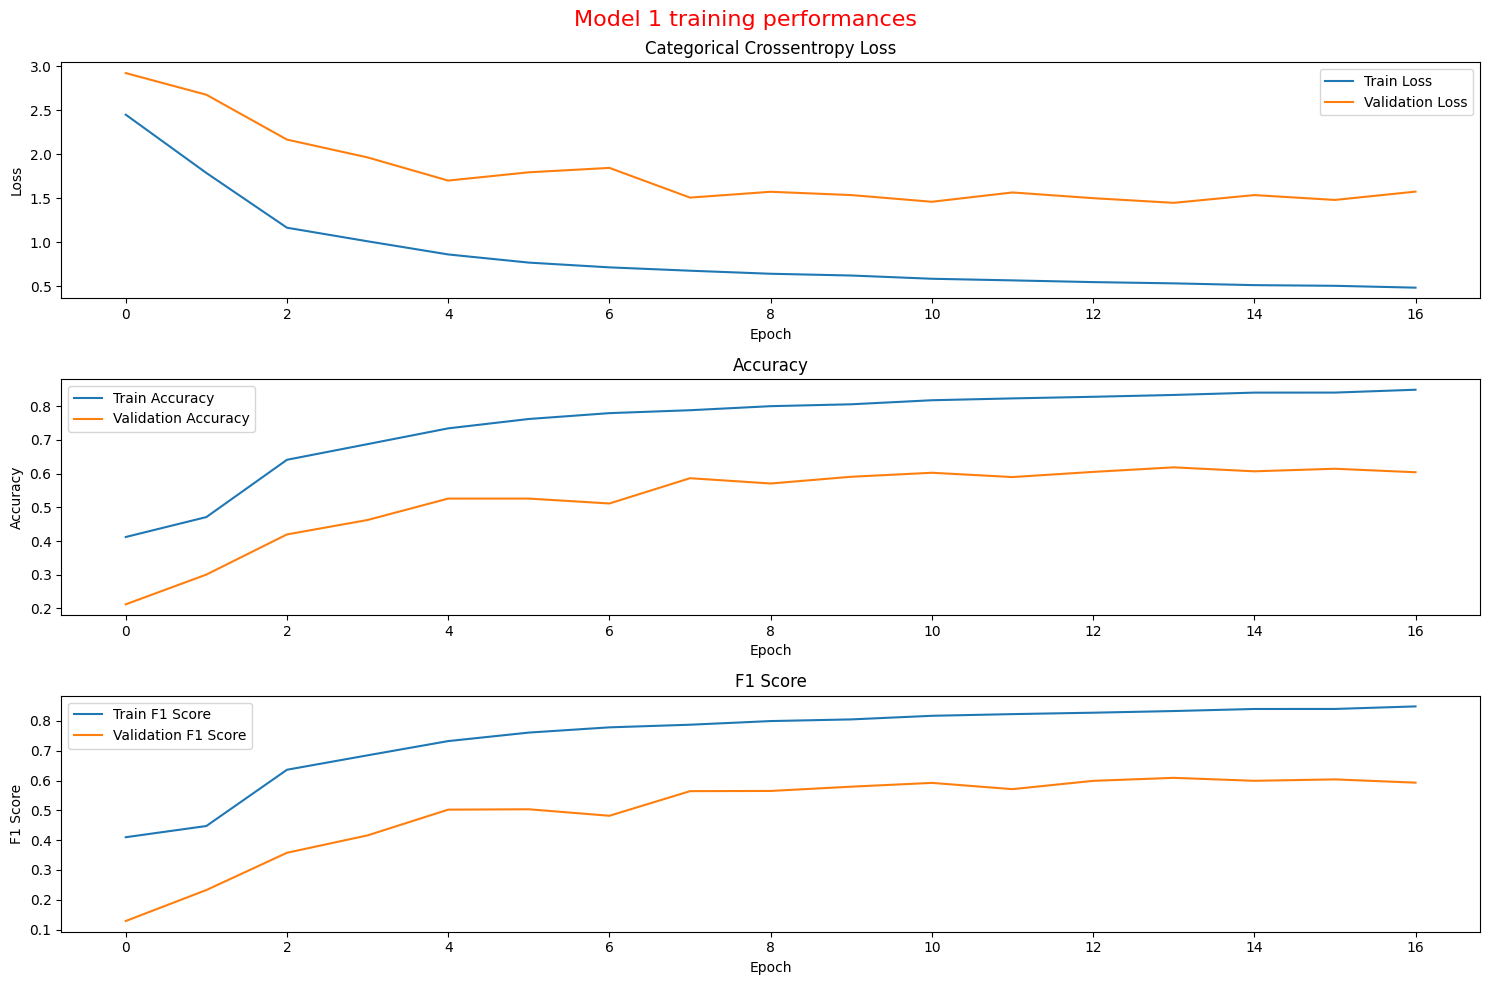

In [ ]:
plot_model_history(history1, "Model 1 training performances")

Above we can see that this simple model is not so bad, it is a good starting point. But it tends to overfit our training data!

In [ ]:
model1_test_metrics = model1.evaluate(test_ds,
                                      verbose=2,
                                      return_dict=True)

213/213 - 1s - 3ms/step - accuracy: 0.6187 - f1_score: 0.6090 - loss: 1.4489


213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


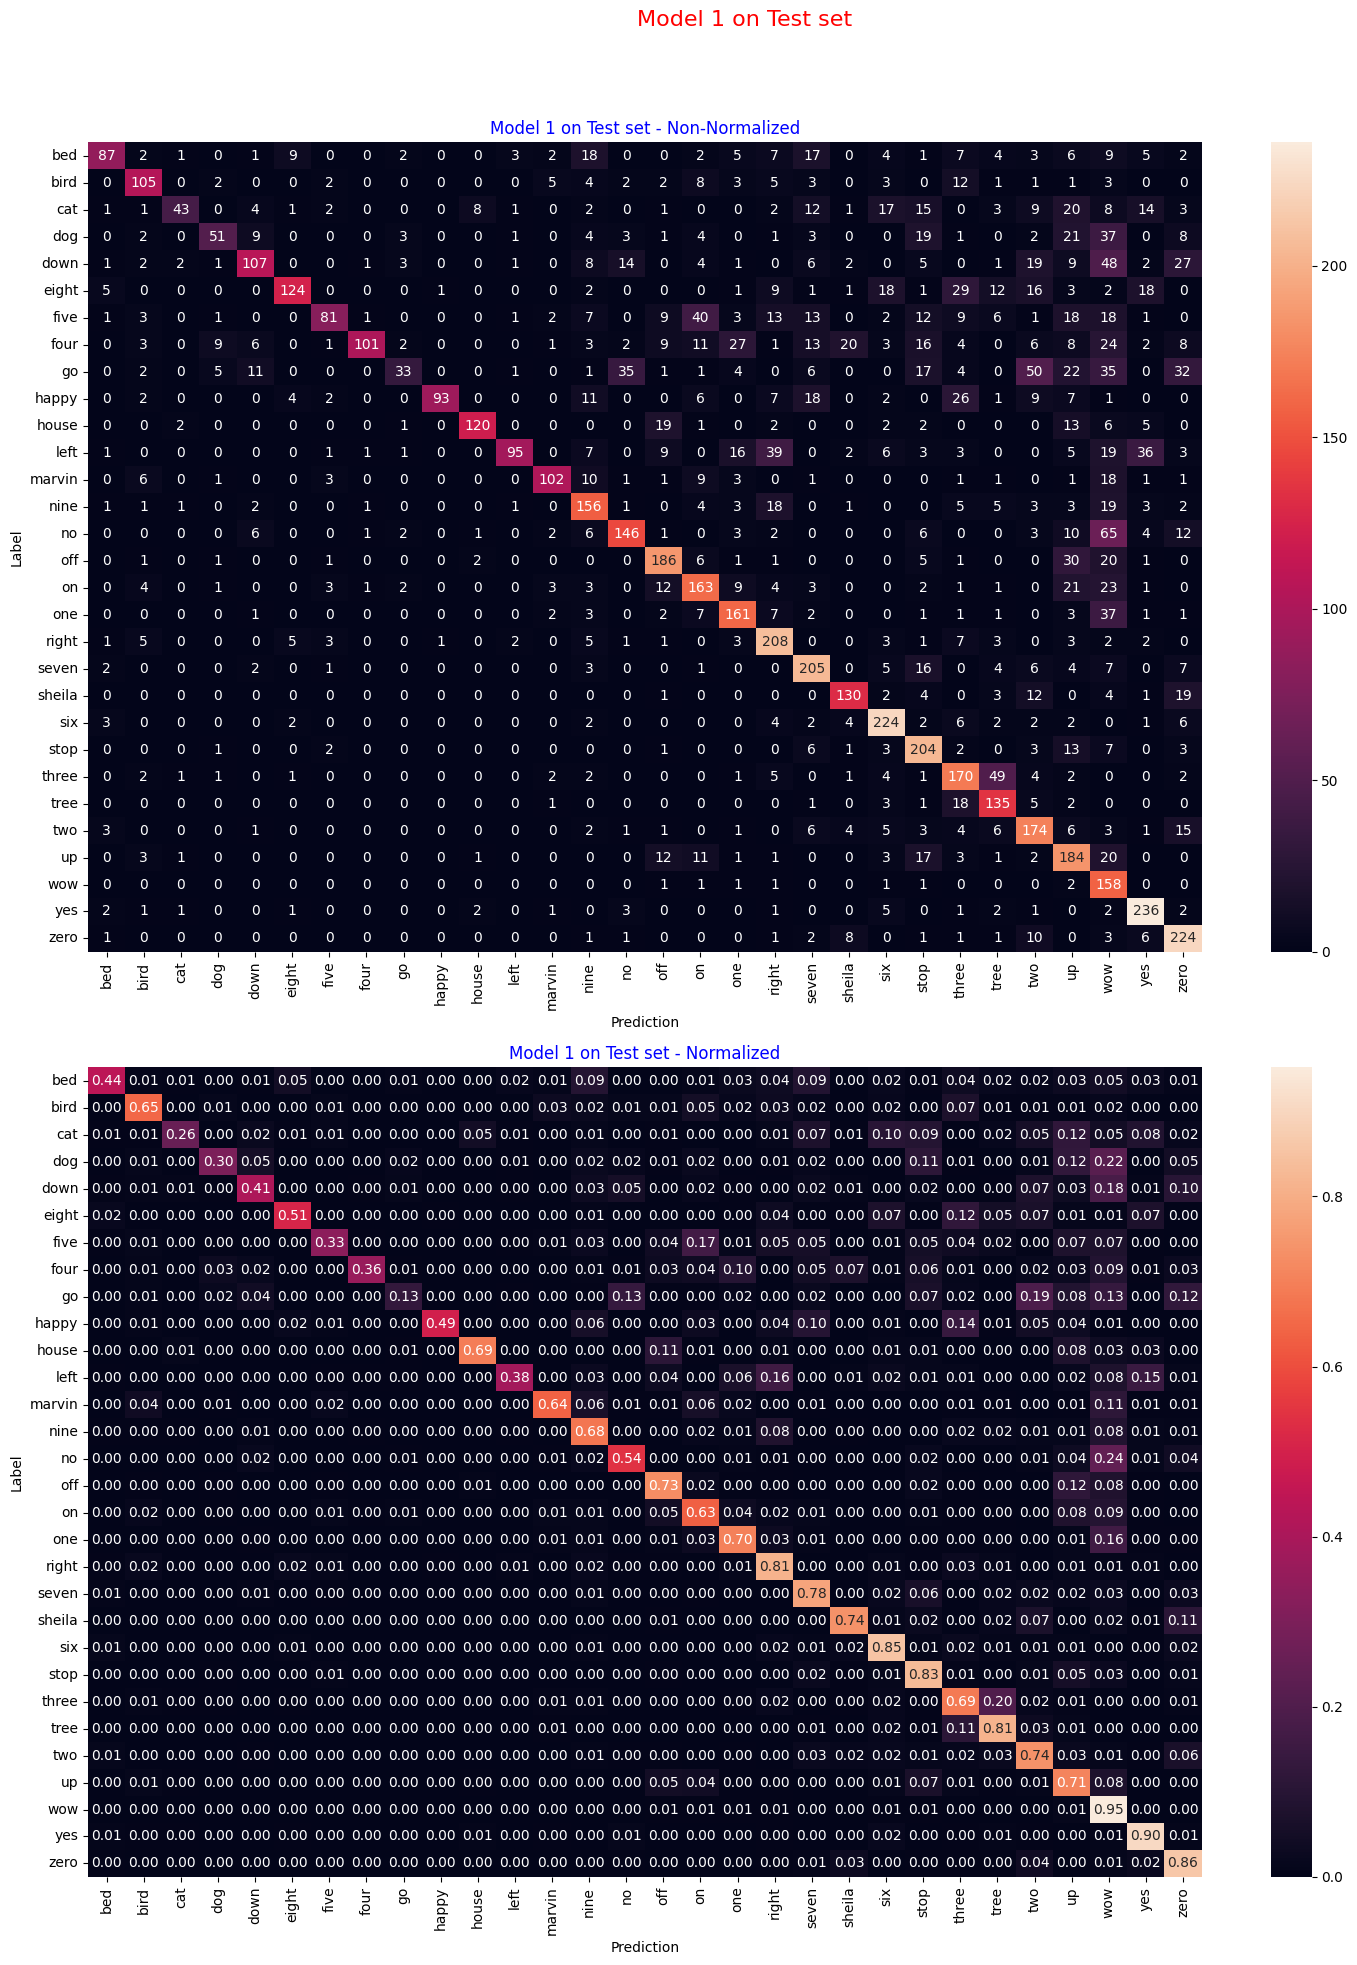

In [ ]:
plot_confusion_matrix(model1, test_ds, class_list, title="Model 1 on Test set")

This simple model is a good baseline, but the number of missclassifications is too high. So, we want to try to improve it.

## Model 2: "Adding Batch Normalization"

Since Model 1 tends to overfit, we are going to add to it a Batch Normalization layer after the Max Pooling one.

The Batch Normalization layer should be able to add some noise to the network activations, serving as a regularization technique. This noise aids in averting overfitting by injecting randomness.

Now, the problem is: where should we put the normalization layer? Since we use ReLU as activation function we try to put Batch Normalization before the activation as suggested by [the original batch normalization paper](https://arxiv.org/pdf/1502.03167).

Thus, our Model 2 architecture will be:

CONV -> BN -> ReLU -> MaxPool -> FC -> ReLU -> FC

In [ ]:
# WE BATCH OUT TENSORFLOW DATASETS IF NECESSARY
if train_ds.element_spec[0].shape != (None, 20, 32, 1):
  train_ds = train_ds.batch(BATCH_SIZE)
if validation_ds.element_spec[0].shape != (None, 20, 32, 1):
  validation_ds = validation_ds.batch(BATCH_SIZE)
if test_ds.element_spec[0].shape != (None, 20, 32, 1):
  test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
# MODEL2: CONV -> BN -> ReLU -> MaxPool -> FC -> ReLU -> FC
model2 = Sequential([
    Input(shape=INPUT_SHAPE),
    Resizing(TARGET_SHAPE[0], TARGET_SHAPE[1]),

    Conv2D(16, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(100, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax'),
])

In [ ]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │         360,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 30)                  │           3,030 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 363,354 (1.39 MB)

 Trainable params: 363,322 (1.39 MB)

 Non-trainable params: 32 (128.00 B)

In [ ]:
model2.compile(
    optimizer = tf.keras.optimizers.AdamW(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

In [ ]:
model2_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             min_delta=0.001,
                                             verbose=1,
                                             patience=4,
                                             restore_best_weights=True)

In [ ]:
EPOCHS = 20
history2 = model2.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = EPOCHS,
    callbacks = model2_es
)

Epoch 1/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.5094 - f1_score: 0.5056 - loss: 1.6194 - val_accuracy: 0.4267 - val_f1_score: 0.3697 - val_loss: 2.2372
Epoch 2/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6908 - f1_score: 0.6932 - loss: 1.0013 - val_accuracy: 0.5343 - val_f1_score: 0.4977 - val_loss: 1.6808
Epoch 3/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7692 - f1_score: 0.7725 - loss: 0.7323 - val_accuracy: 0.6091 - val_f1_score: 0.5946 - val_loss: 1.4397
Epoch 4/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8061 - f1_score: 0.8094 - loss: 0.6137 - val_accuracy: 0.6293 - val_f1_score: 0.6210 - val_loss: 1.3231
Epoch 5/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8339 - f1_score: 0.8375 - loss: 0.5344 - val_accuracy: 0.6152 - val_f1_score: 0.6022 - val_loss: 1.4253
Epoch 6/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8476 - f1_score: 0.8512 - loss: 0.4915 - val_accuracy: 0.6531 - val_f1

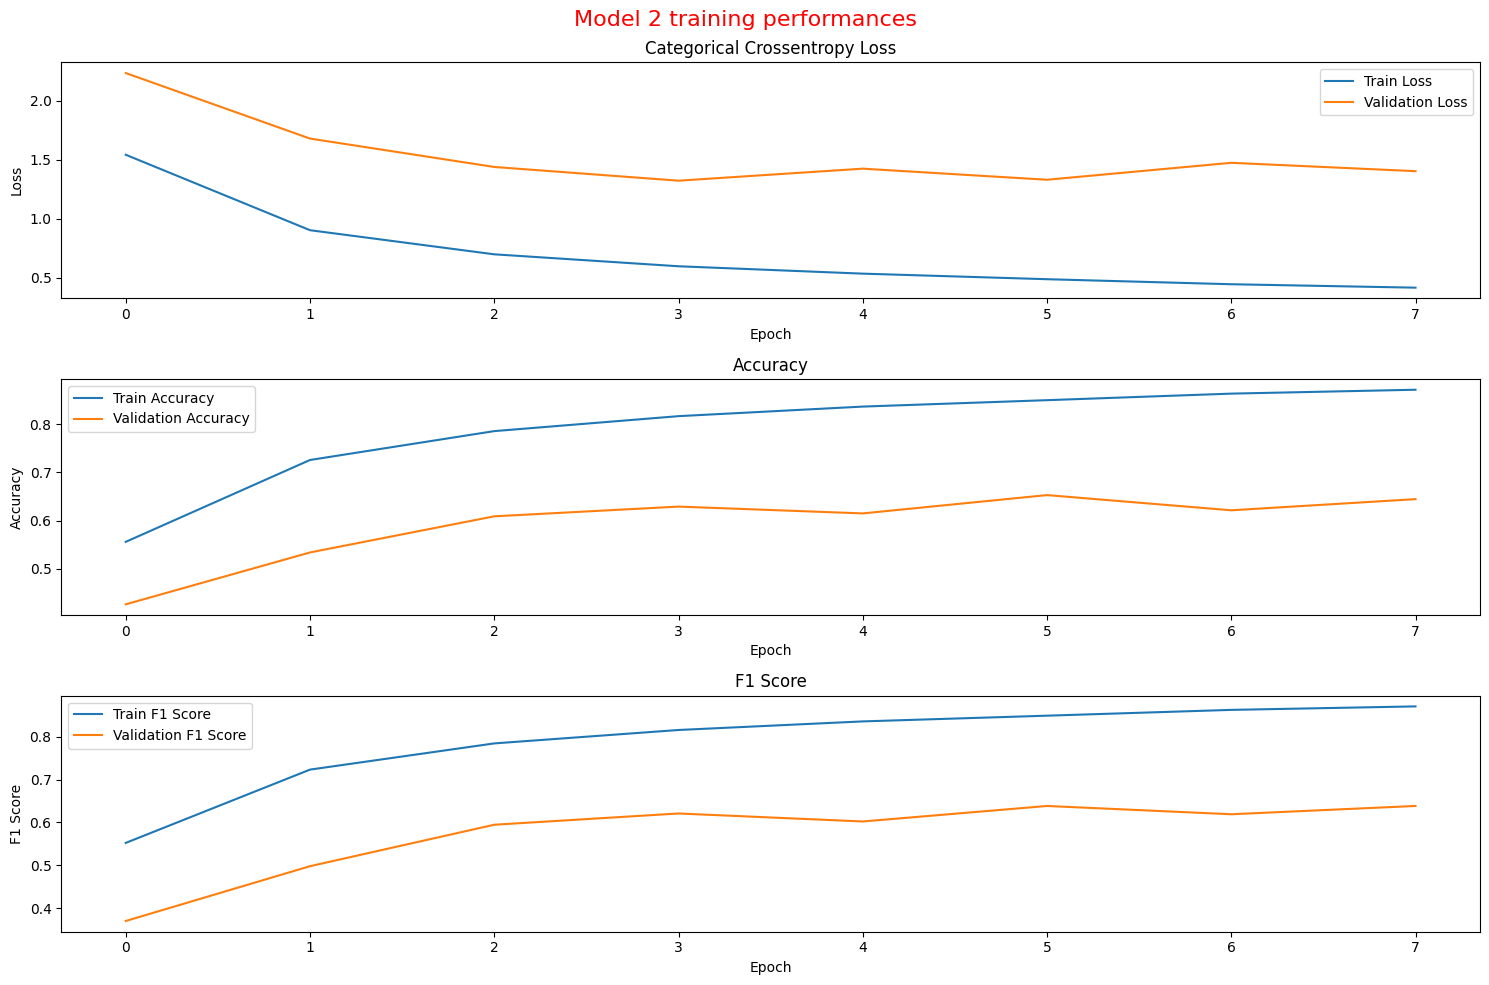

In [ ]:
plot_model_history(history2, "Model 2 training performances")

In [ ]:
model2_test_metrics = model2.evaluate(test_ds,
                                      verbose=2,
                                      return_dict=True)

213/213 - 1s - 3ms/step - accuracy: 0.6293 - f1_score: 0.6210 - loss: 1.3231


213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


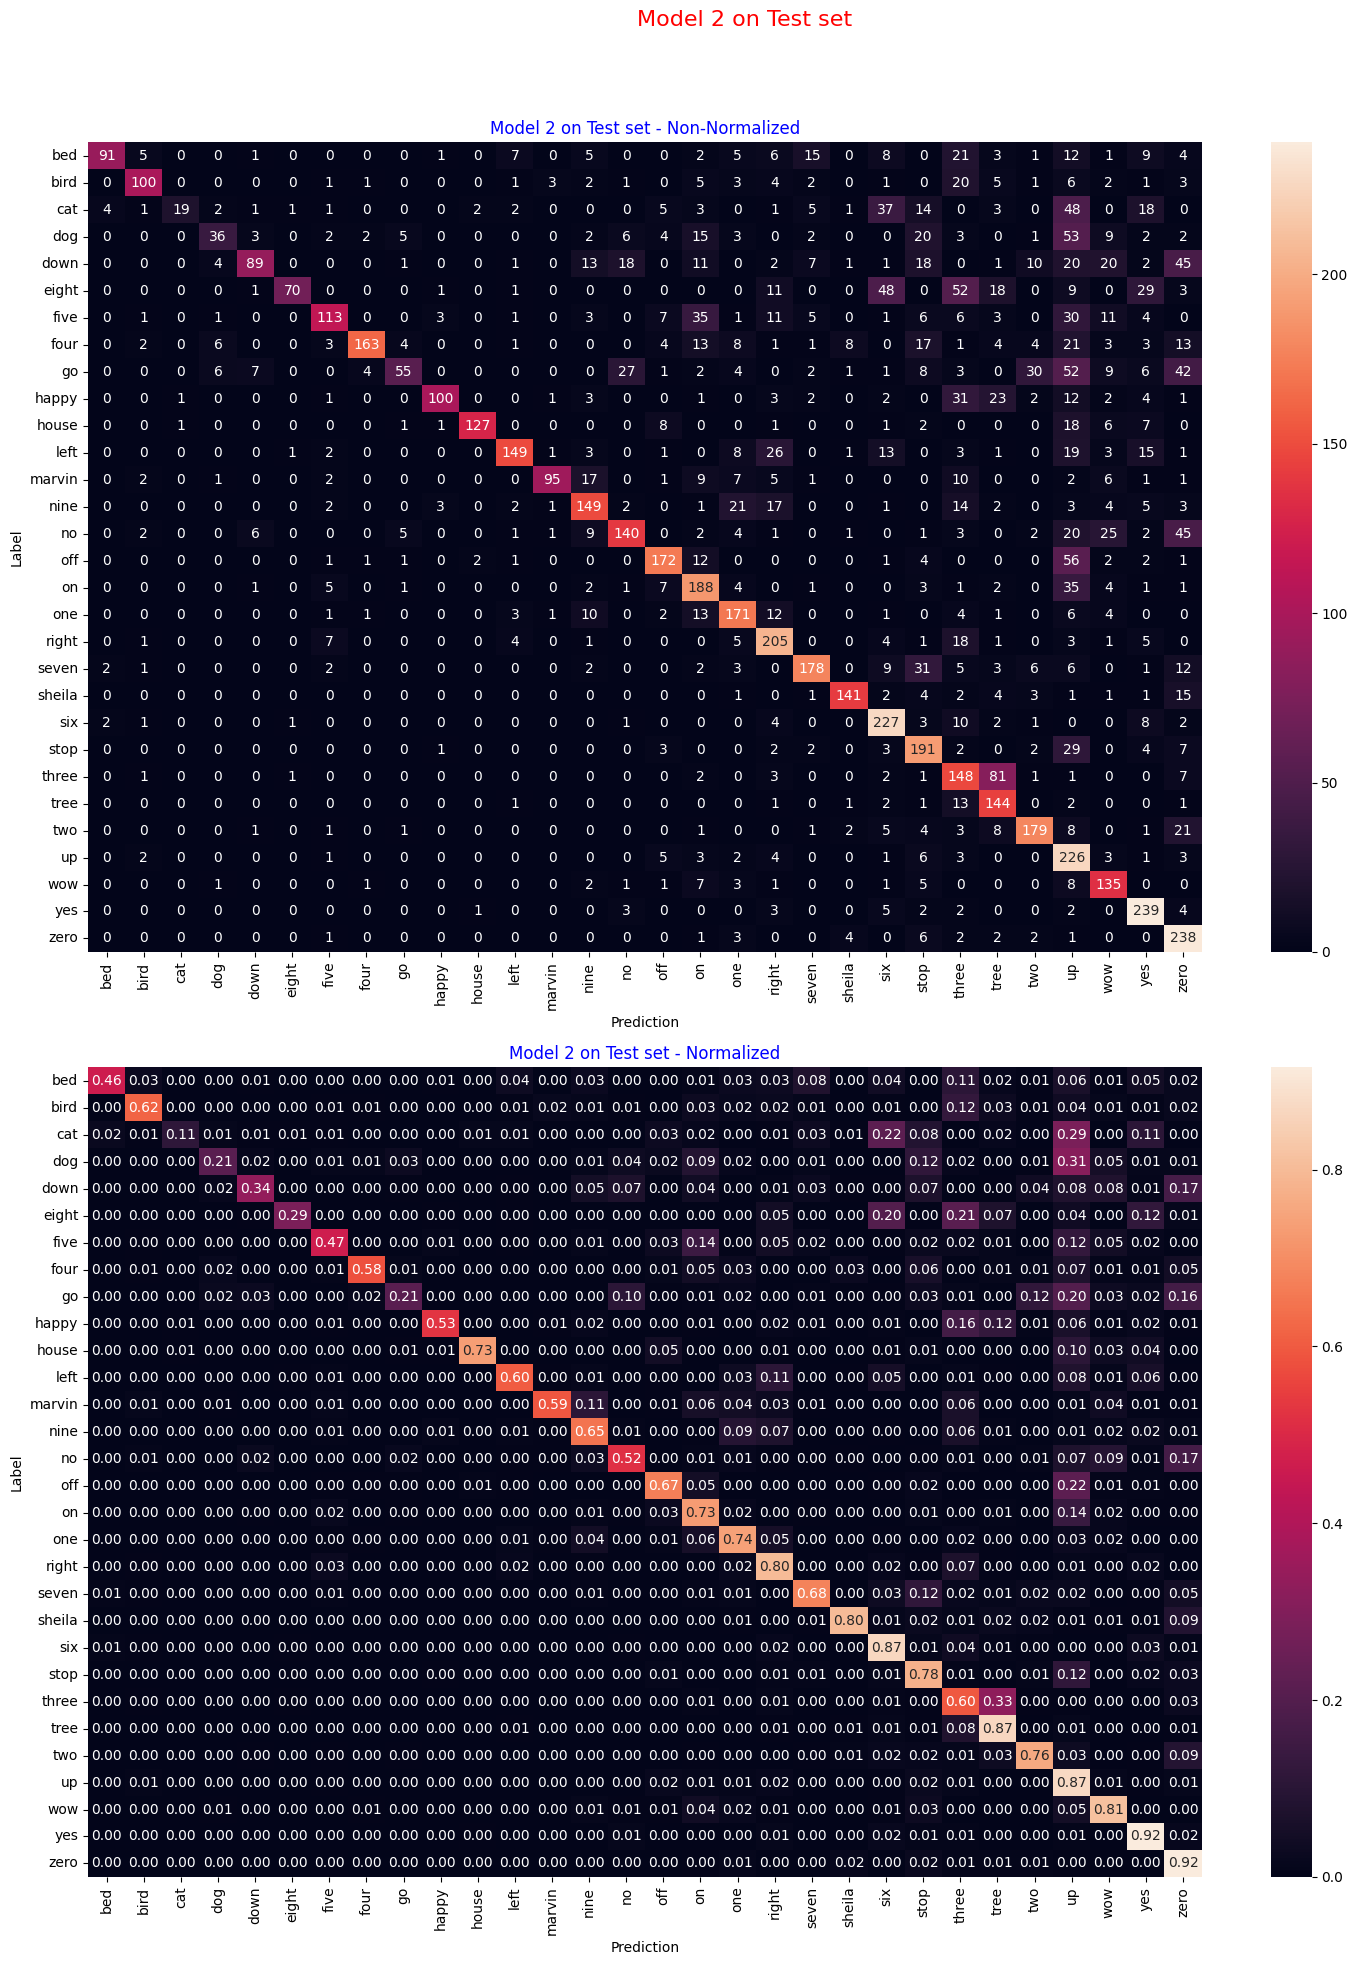

In [ ]:
plot_confusion_matrix(model2, test_ds, class_list, title="Model 2 on Test set")

Not bad, with just one single Batch Normalization layer we obtained a good improvement!

## Model 3: "One more Convolutional Block"

Now we want to improve more our model performances. So, since the pattern: Conv2D + BN works, we are going to add another block like this to our network.

In this way we should be able to improve the model generalization ability.

Thus, Model 3 will have the following architecture:

CONV -> BN -> ReLU -> MaxPool ->

CONV -> BN -> ReLU -> MaxPool ->

FC -> ReLU -> FC

In [ ]:
# WE BATCH OUT TENSORFLOW DATASETS IF NECESSARY
if train_ds.element_spec[0].shape != (None, 20, 32, 1):
  train_ds = train_ds.batch(BATCH_SIZE)
if validation_ds.element_spec[0].shape != (None, 20, 32, 1):
  validation_ds = validation_ds.batch(BATCH_SIZE)
if test_ds.element_spec[0].shape != (None, 20, 32, 1):
  test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
# MODEL3:
# CONV -> BN -> ReLU -> MaxPool ->
# CONV -> BN -> ReLU -> MaxPool ->
# FC -> ReLU -> FC

model3 = Sequential([
    Input(shape=INPUT_SHAPE),
    Resizing(TARGET_SHAPE[0], TARGET_SHAPE[1]),

    Conv2D(16, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Conv2D(32, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(100, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax'),
])

In [ ]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 13, 13, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │         115,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30)                  │           3,030 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,322 (481.73 KB)

 Trainable params: 123,226 (481.35 KB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
model3.compile(
    optimizer = tf.keras.optimizers.AdamW(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

In [ ]:
model3_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             min_delta=0.001,
                                             verbose=1,
                                             patience=4,
                                             restore_best_weights=True)

In [ ]:
EPOCHS = 25
history3 = model3.fit(
                      train_ds,
                      validation_data = validation_ds,
                      epochs = EPOCHS,
                      callbacks = model3_es
                      )

Epoch 1/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.5963 - f1_score: 0.5932 - loss: 1.3087 - val_accuracy: 0.6084 - val_f1_score: 0.5921 - val_loss: 1.3443
Epoch 2/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8184 - f1_score: 0.8206 - loss: 0.5826 - val_accuracy: 0.7029 - val_f1_score: 0.6992 - val_loss: 1.0003
Epoch 3/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8687 - f1_score: 0.8709 - loss: 0.4268 - val_accuracy: 0.7308 - val_f1_score: 0.7264 - val_loss: 0.9391
Epoch 4/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8916 - f1_score: 0.8941 - loss: 0.3507 - val_accuracy: 0.7636 - val_f1_score: 0.7656 - val_loss: 0.8079
Epoch 5/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9061 - f1_score: 0.9090 - loss: 0.2976 - val_accuracy: 0.7621 - val_f1_score: 0.7618 - val_loss: 0.8231
Epoch 6/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9165 - f1_score: 0.9191 - loss: 0.2646 - val_accuracy: 0.7664 - val_f1_

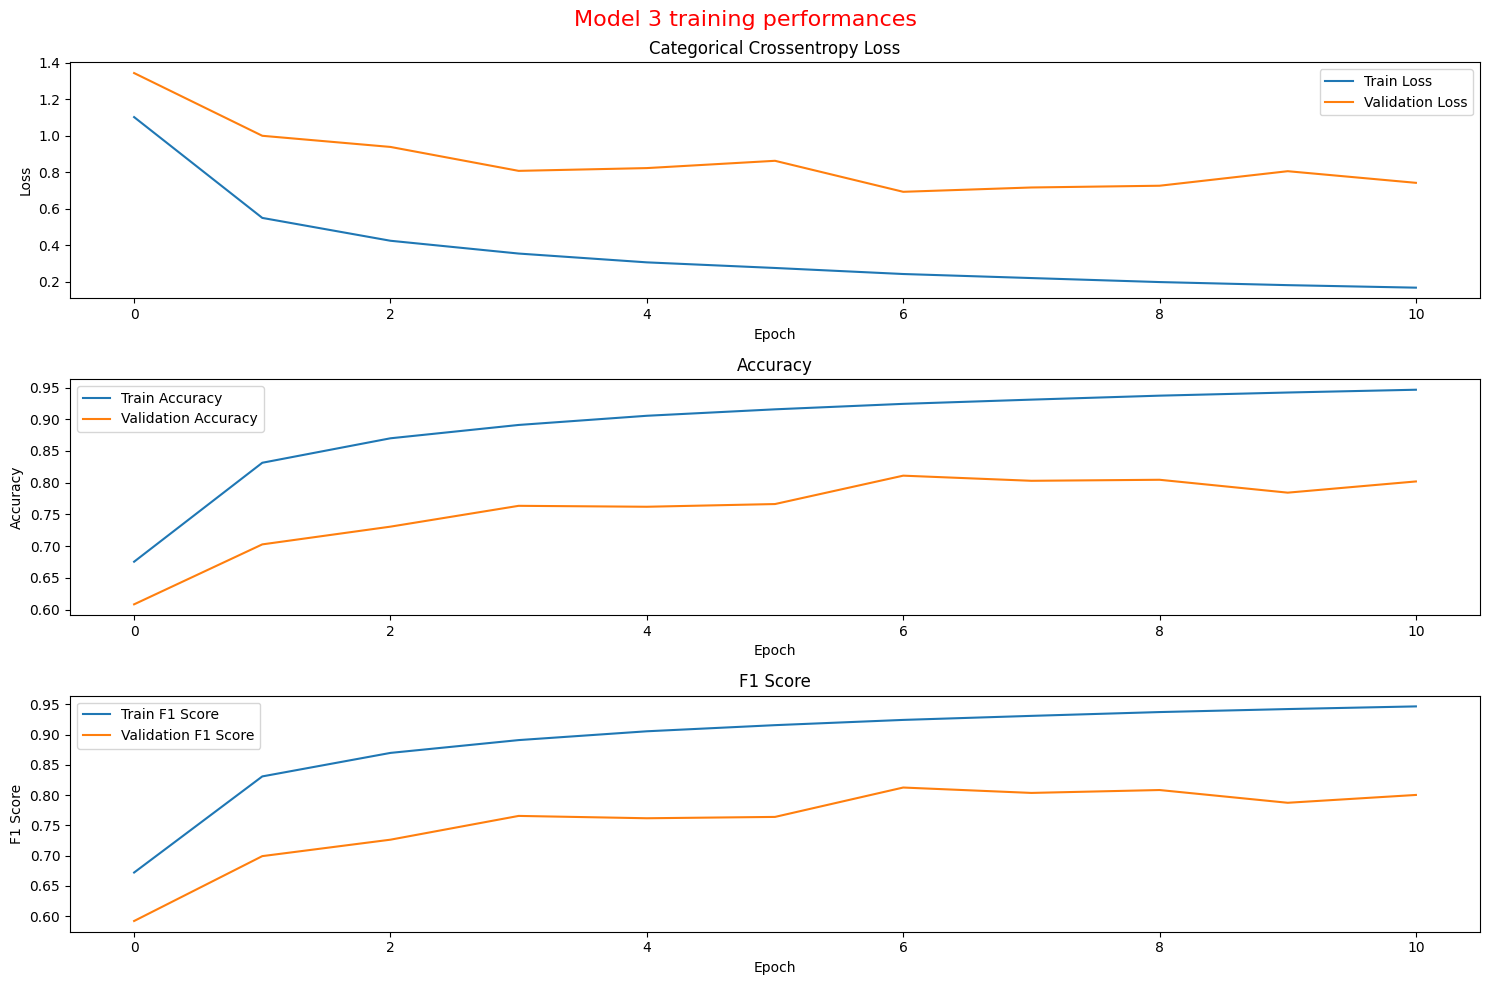

In [ ]:
plot_model_history(history3, "Model 3 training performances")

In [ ]:
model3_test_metrics = model3.evaluate(test_ds,
                                      verbose=2,
                                      return_dict=True)

213/213 - 1s - 3ms/step - accuracy: 0.8111 - f1_score: 0.8125 - loss: 0.6931


213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


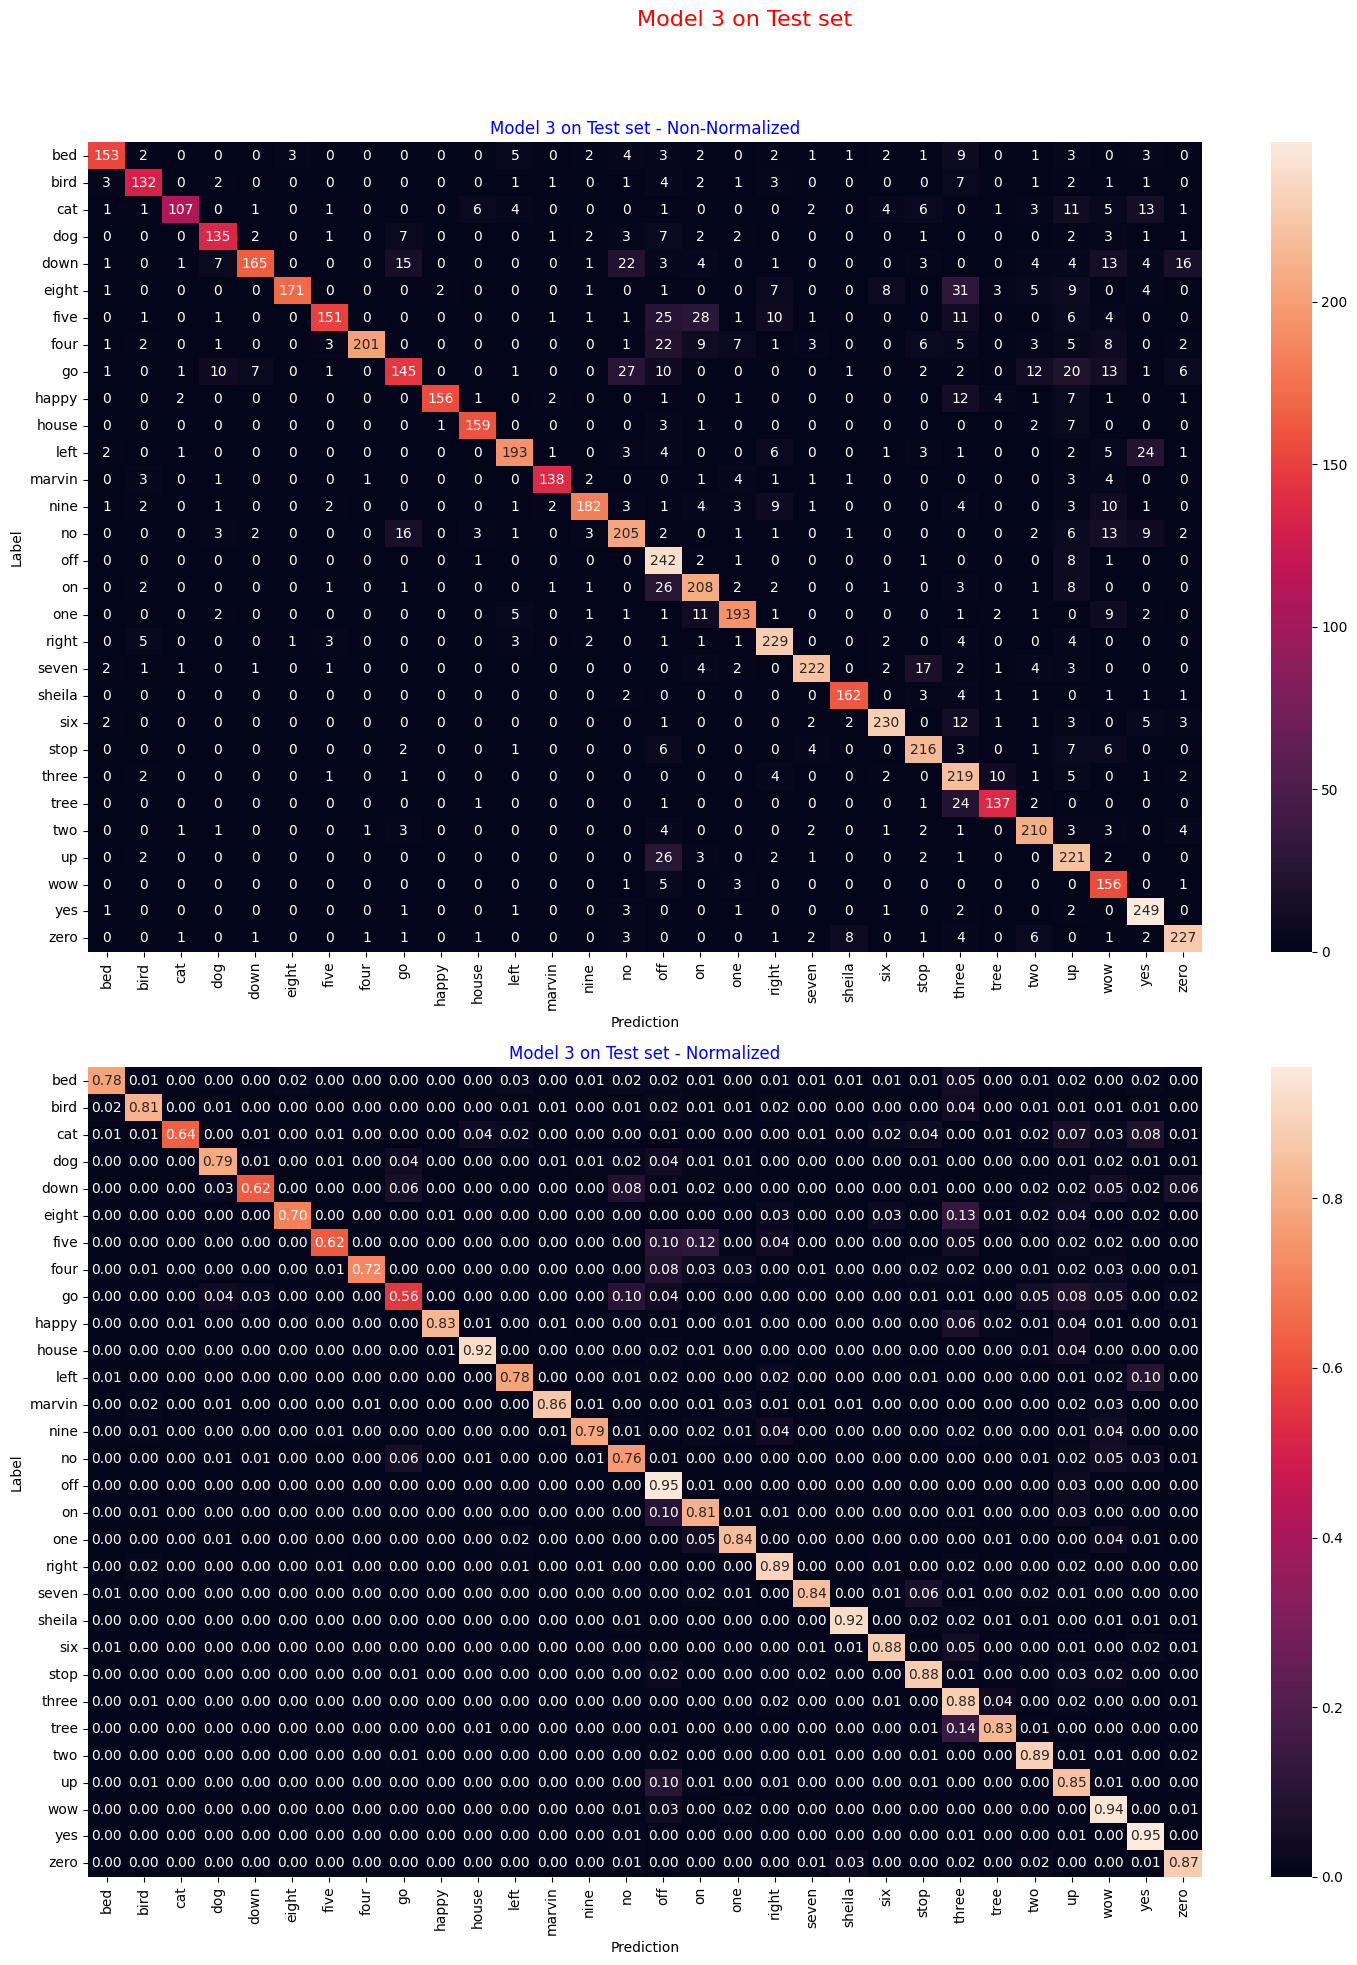

In [ ]:
plot_confusion_matrix(model3, test_ds, class_list, title="Model 3 on Test set")

Again, we obtained a consistent improvement. But, we can do better.

## Model 4: "Dropout, more Filters and more parameters"

From the previous model we can see that, despine Batch Normalization, the model tends to overfit data. What we can try to do is to add some dropout in the final FC layer.

Moreover, it could be interesting to change a little bit our convolutional blocks with the purpose to increase the ability of the model to catch the features inside our input data.

In particular, we are going to increase the dimension of the output space of our first and second convolutional layers. While at the end of the network we are going to increase the number of parameters of the Dense Layer.

Thus, the architecture of Model 4 is going to be:

CONV -> BN -> ReLU -> MaxPool ->

CONV -> BN -> ReLU -> MaxPool ->

FC -> ReLU -> FC

In [ ]:
# WE BATCH OUT TENSORFLOW DATASETS IF NECESSARY
if train_ds.element_spec[0].shape != (None, 20, 32, 1):
  train_ds = train_ds.batch(BATCH_SIZE)
if validation_ds.element_spec[0].shape != (None, 20, 32, 1):
  validation_ds = validation_ds.batch(BATCH_SIZE)
if test_ds.element_spec[0].shape != (None, 20, 32, 1):
  test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
# MODEL4:
# CONV -> BN -> ReLU -> MaxPool ->
# CONV -> BN -> ReLU -> MaxPool ->
# FC -> ReLU -> FC

model4 = Sequential([
    Input(shape=INPUT_SHAPE),
    Resizing(TARGET_SHAPE[0], TARGET_SHAPE[1]),

    Conv2D(32, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax'),
])

In [ ]:
model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 318,110 (1.21 MB)

 Trainable params: 317,918 (1.21 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
model4.compile(
    optimizer = tf.keras.optimizers.AdamW(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

In [ ]:
model4_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             min_delta=0.0001,
                                             verbose=1,
                                             patience=4,
                                             restore_best_weights=True)

In [ ]:
EPOCHS = 50
history4 = model4.fit(
                      train_ds,
                      validation_data = validation_ds,
                      epochs = EPOCHS,
                      callbacks = model4_es
                      )

Epoch 1/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.5077 - f1_score: 0.5042 - loss: 1.6009 - val_accuracy: 0.4515 - val_f1_score: 0.3907 - val_loss: 1.9897
Epoch 2/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6948 - f1_score: 0.6994 - loss: 0.9644 - val_accuracy: 0.5944 - val_f1_score: 0.5769 - val_loss: 1.3493
Epoch 3/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7877 - f1_score: 0.7916 - loss: 0.6739 - val_accuracy: 0.7043 - val_f1_score: 0.6964 - val_loss: 0.9892
Epoch 4/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.8313 - f1_score: 0.8353 - loss: 0.5427 - val_accuracy: 0.7418 - val_f1_score: 0.7429 - val_loss: 0.8697
Epoch 5/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8519 - f1_score: 0.8562 - loss: 0.4658 - val_accuracy: 0.7674 - val_f1_score: 0.7620 - val_loss: 0.7959
Epoch 6/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8719 - f1_score: 0.8756 - loss: 0.4108 - val_accuracy: 0.7680 - val_

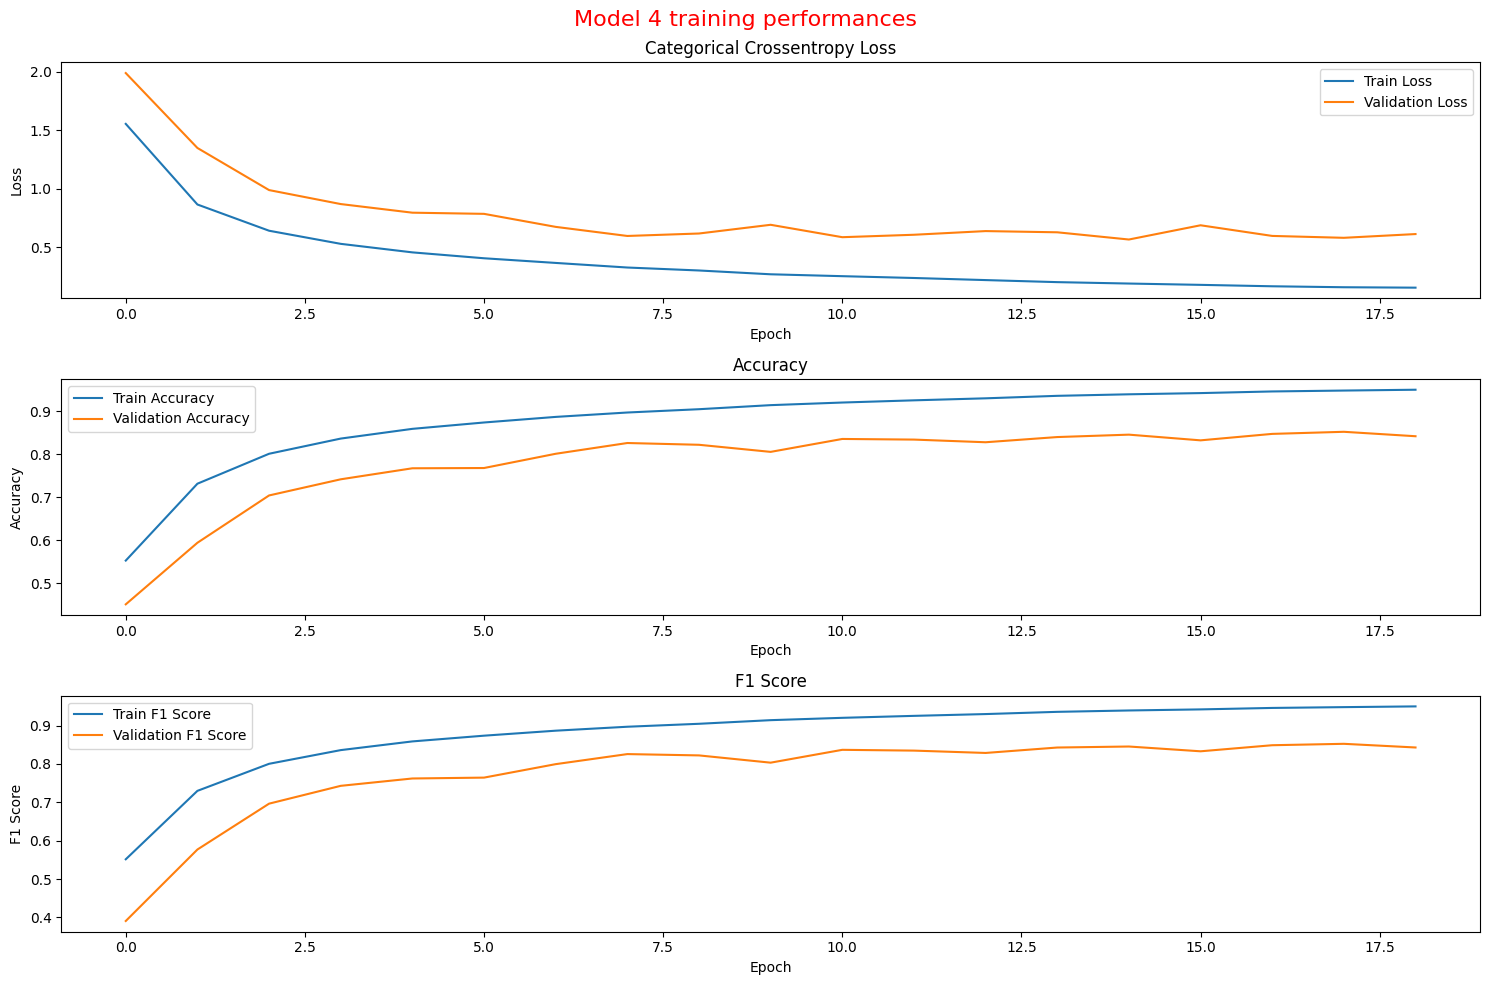

In [ ]:
plot_model_history(history4, "Model 4 training performances")

In [ ]:
model4_test_metrics = model4.evaluate(test_ds,
                                      verbose=2,
                                      return_dict=True)

213/213 - 1s - 3ms/step - accuracy: 0.8455 - f1_score: 0.8453 - loss: 0.5665


213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


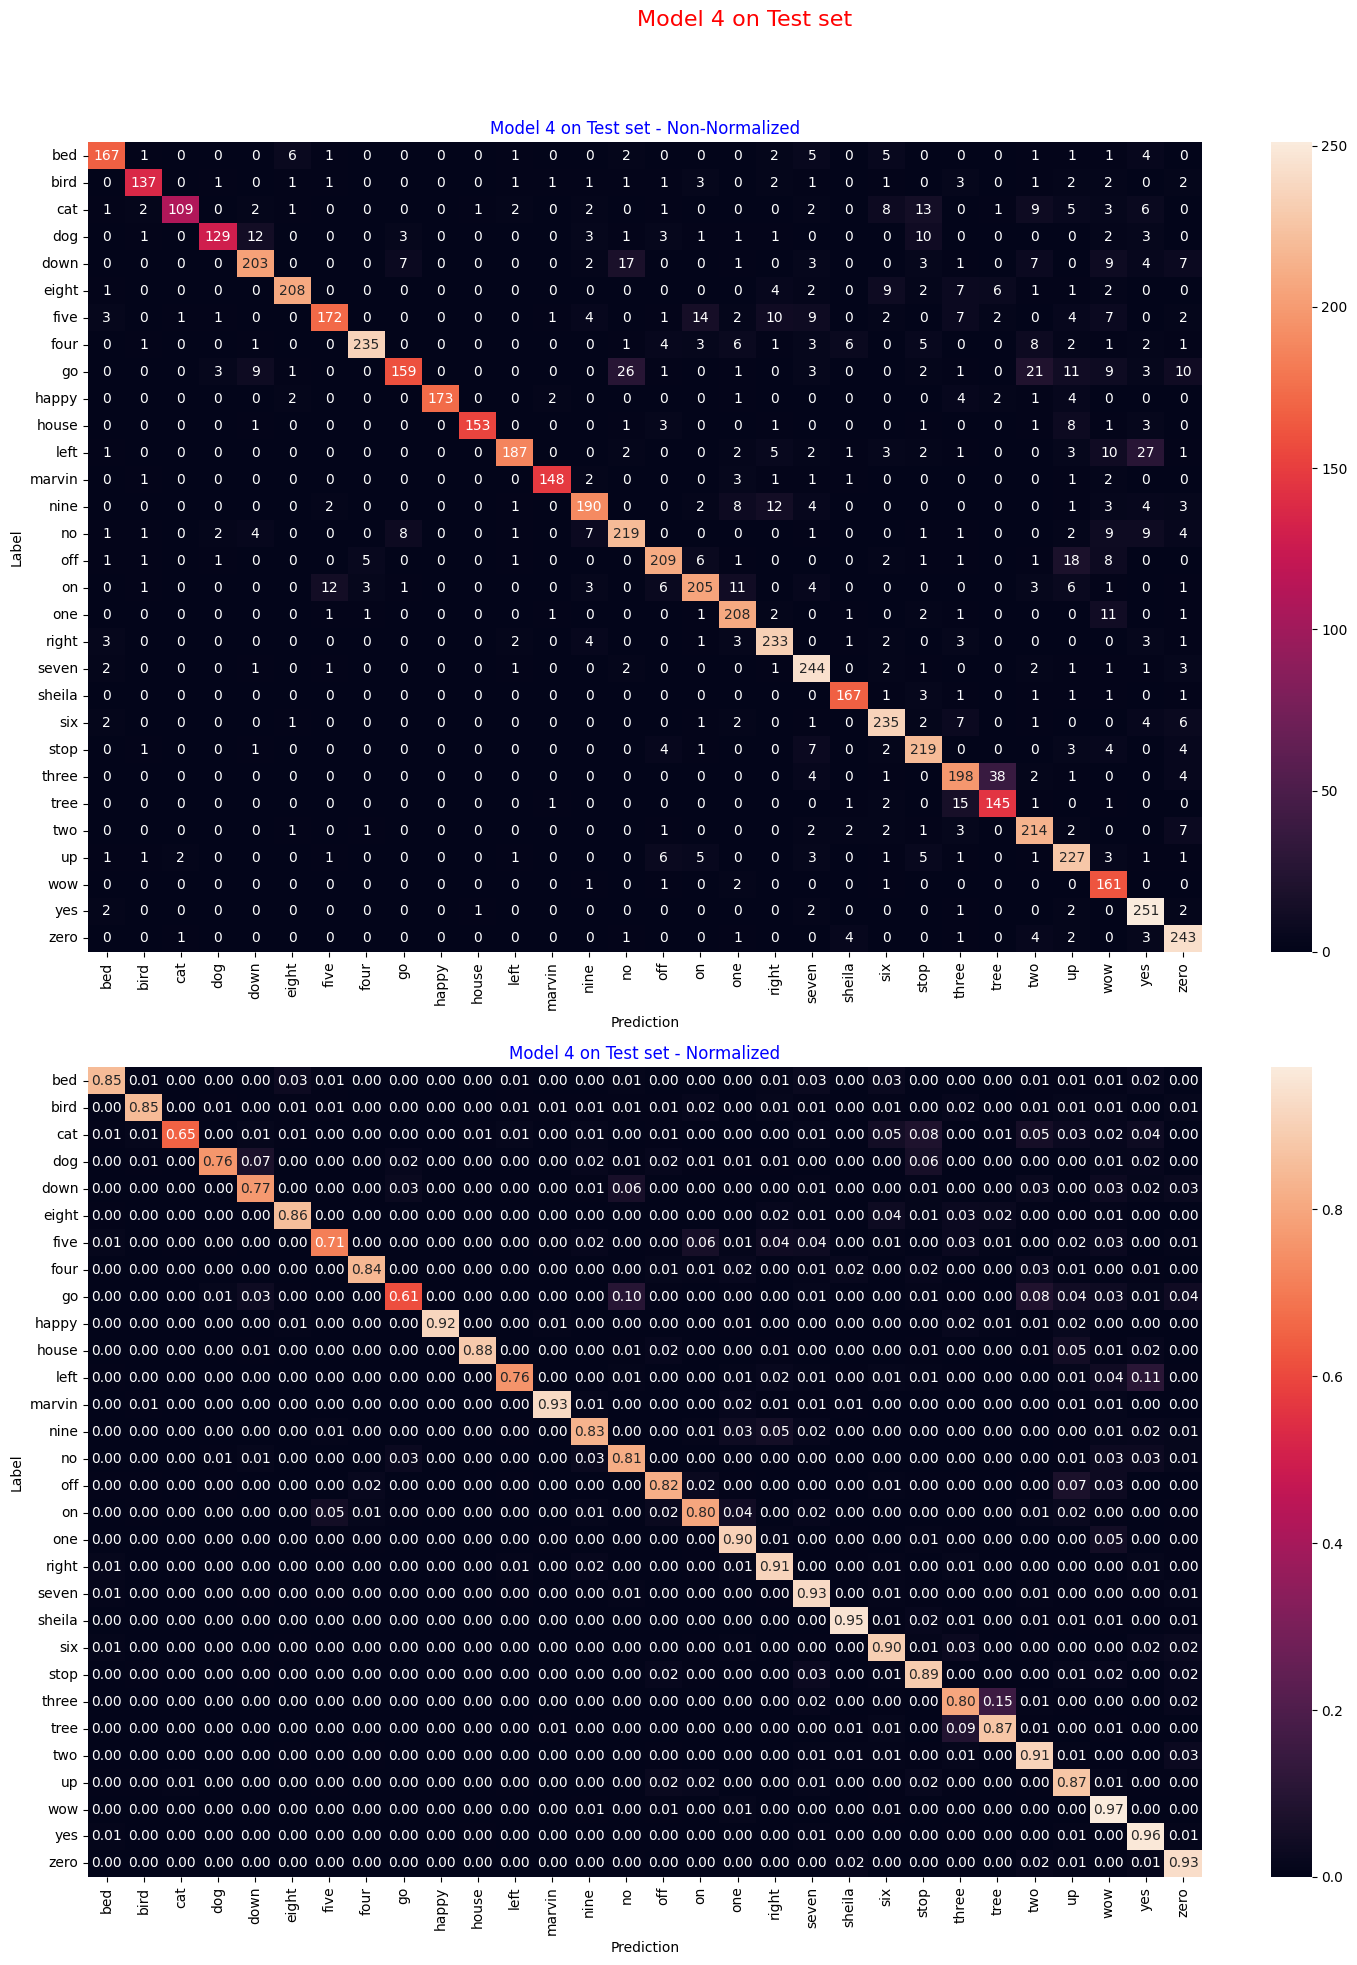

In [ ]:
plot_confusion_matrix(model4, test_ds, class_list, title="Model 4 on Test set")

Not the great improvement we expected, but it is something.

## Model 5: "Deeper Convolutional Blocks"

Now, we want to understand if we are able to catch more features increasing the depth of our convolutional blocks.

In particular, we are going to add one convolution inside each block.

Thus, the model is going to built as follows:

CONV -> BN -> ReLU -> CONV -> BN -> ReLU -> MaxPool ->

CONV -> BN -> ReLU -> CONV -> BN -> ReLU -> MaxPool ->

FC -> ReLU -> Dropout -> FC

In [ ]:
# WE BATCH OUT TENSORFLOW DATASETS IF NECESSARY
if train_ds.element_spec[0].shape != (None, 20, 32, 1):
  train_ds = train_ds.batch(BATCH_SIZE)
if validation_ds.element_spec[0].shape != (None, 20, 32, 1):
  validation_ds = validation_ds.batch(BATCH_SIZE)
if test_ds.element_spec[0].shape != (None, 20, 32, 1):
  test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
# MODEL5:
# CONV -> BN -> ReLU -> CONV -> BN -> ReLU -> MaxPool ->
# CONV -> BN -> ReLU -> CONV -> BN -> ReLU -> MaxPool ->
# FC -> ReLU -> Dropout -> FC

model5 = Sequential([
    Input(shape=INPUT_SHAPE),
    Resizing(TARGET_SHAPE[0], TARGET_SHAPE[1]),


    Conv2D(32, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),


    Conv2D(64, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax'),
])

In [ ]:
model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_4 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 274,558 (1.05 MB)

 Trainable params: 274,174 (1.05 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
model5.compile(
    optimizer = tf.keras.optimizers.AdamW(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

In [ ]:
model5_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             min_delta=0.0001,
                                             verbose=1,
                                             patience=4,
                                             restore_best_weights=True)

In [ ]:
EPOCHS = 50
history5 = model5.fit(
                      train_ds,
                      validation_data = validation_ds,
                      epochs = EPOCHS,
                      callbacks = model5_es
                      )

Epoch 1/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.6130 - f1_score: 0.6118 - loss: 1.2855 - val_accuracy: 0.6164 - val_f1_score: 0.5771 - val_loss: 1.2600
Epoch 2/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8243 - f1_score: 0.8299 - loss: 0.5729 - val_accuracy: 0.6655 - val_f1_score: 0.6470 - val_loss: 1.1861
Epoch 3/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8798 - f1_score: 0.8840 - loss: 0.3988 - val_accuracy: 0.7751 - val_f1_score: 0.7708 - val_loss: 0.7293
Epoch 4/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9037 - f1_score: 0.9073 - loss: 0.3176 - val_accuracy: 0.7592 - val_f1_score: 0.7637 - val_loss: 0.8477
Epoch 5/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9202 - f1_score: 0.9232 - loss: 0.2662 - val_accuracy: 0.7763 - val_f1_score: 0.7800 - val_loss: 0.8312
Epoch 6/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9296 - f1_score: 0.9323 - loss: 0.2293 - val_accuracy: 0.8386 - val

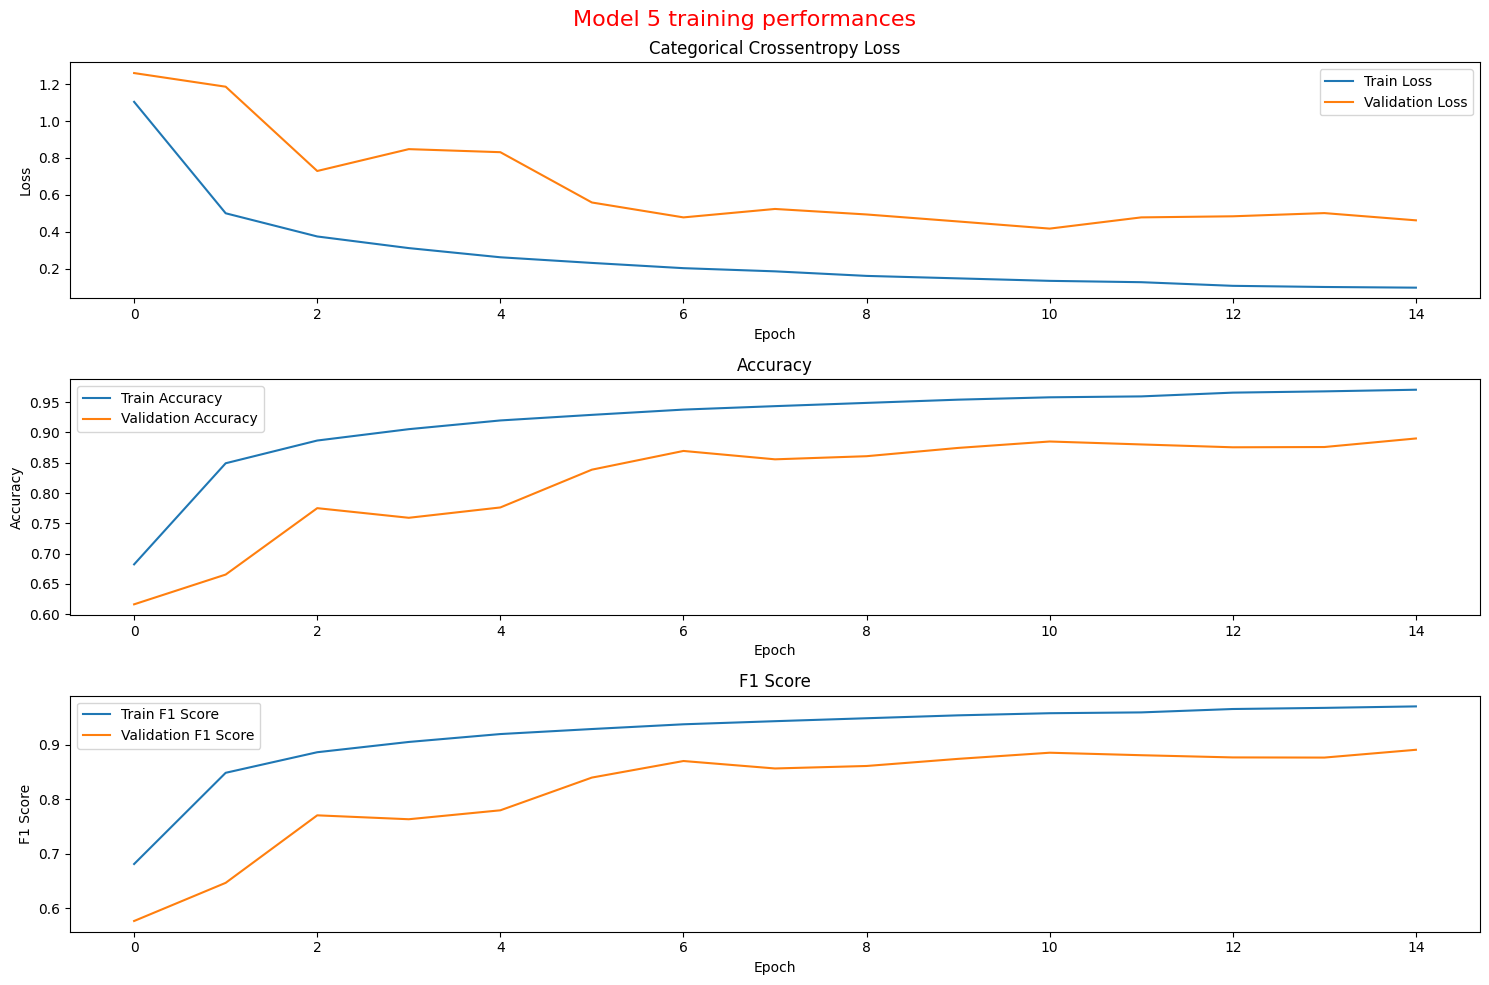

In [ ]:
plot_model_history(history5, "Model 5 training performances")

In [ ]:
model5_test_metrics = model5.evaluate(test_ds,
                                      verbose=2,
                                      return_dict=True)

213/213 - 1s - 3ms/step - accuracy: 0.8851 - f1_score: 0.8856 - loss: 0.4170


213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


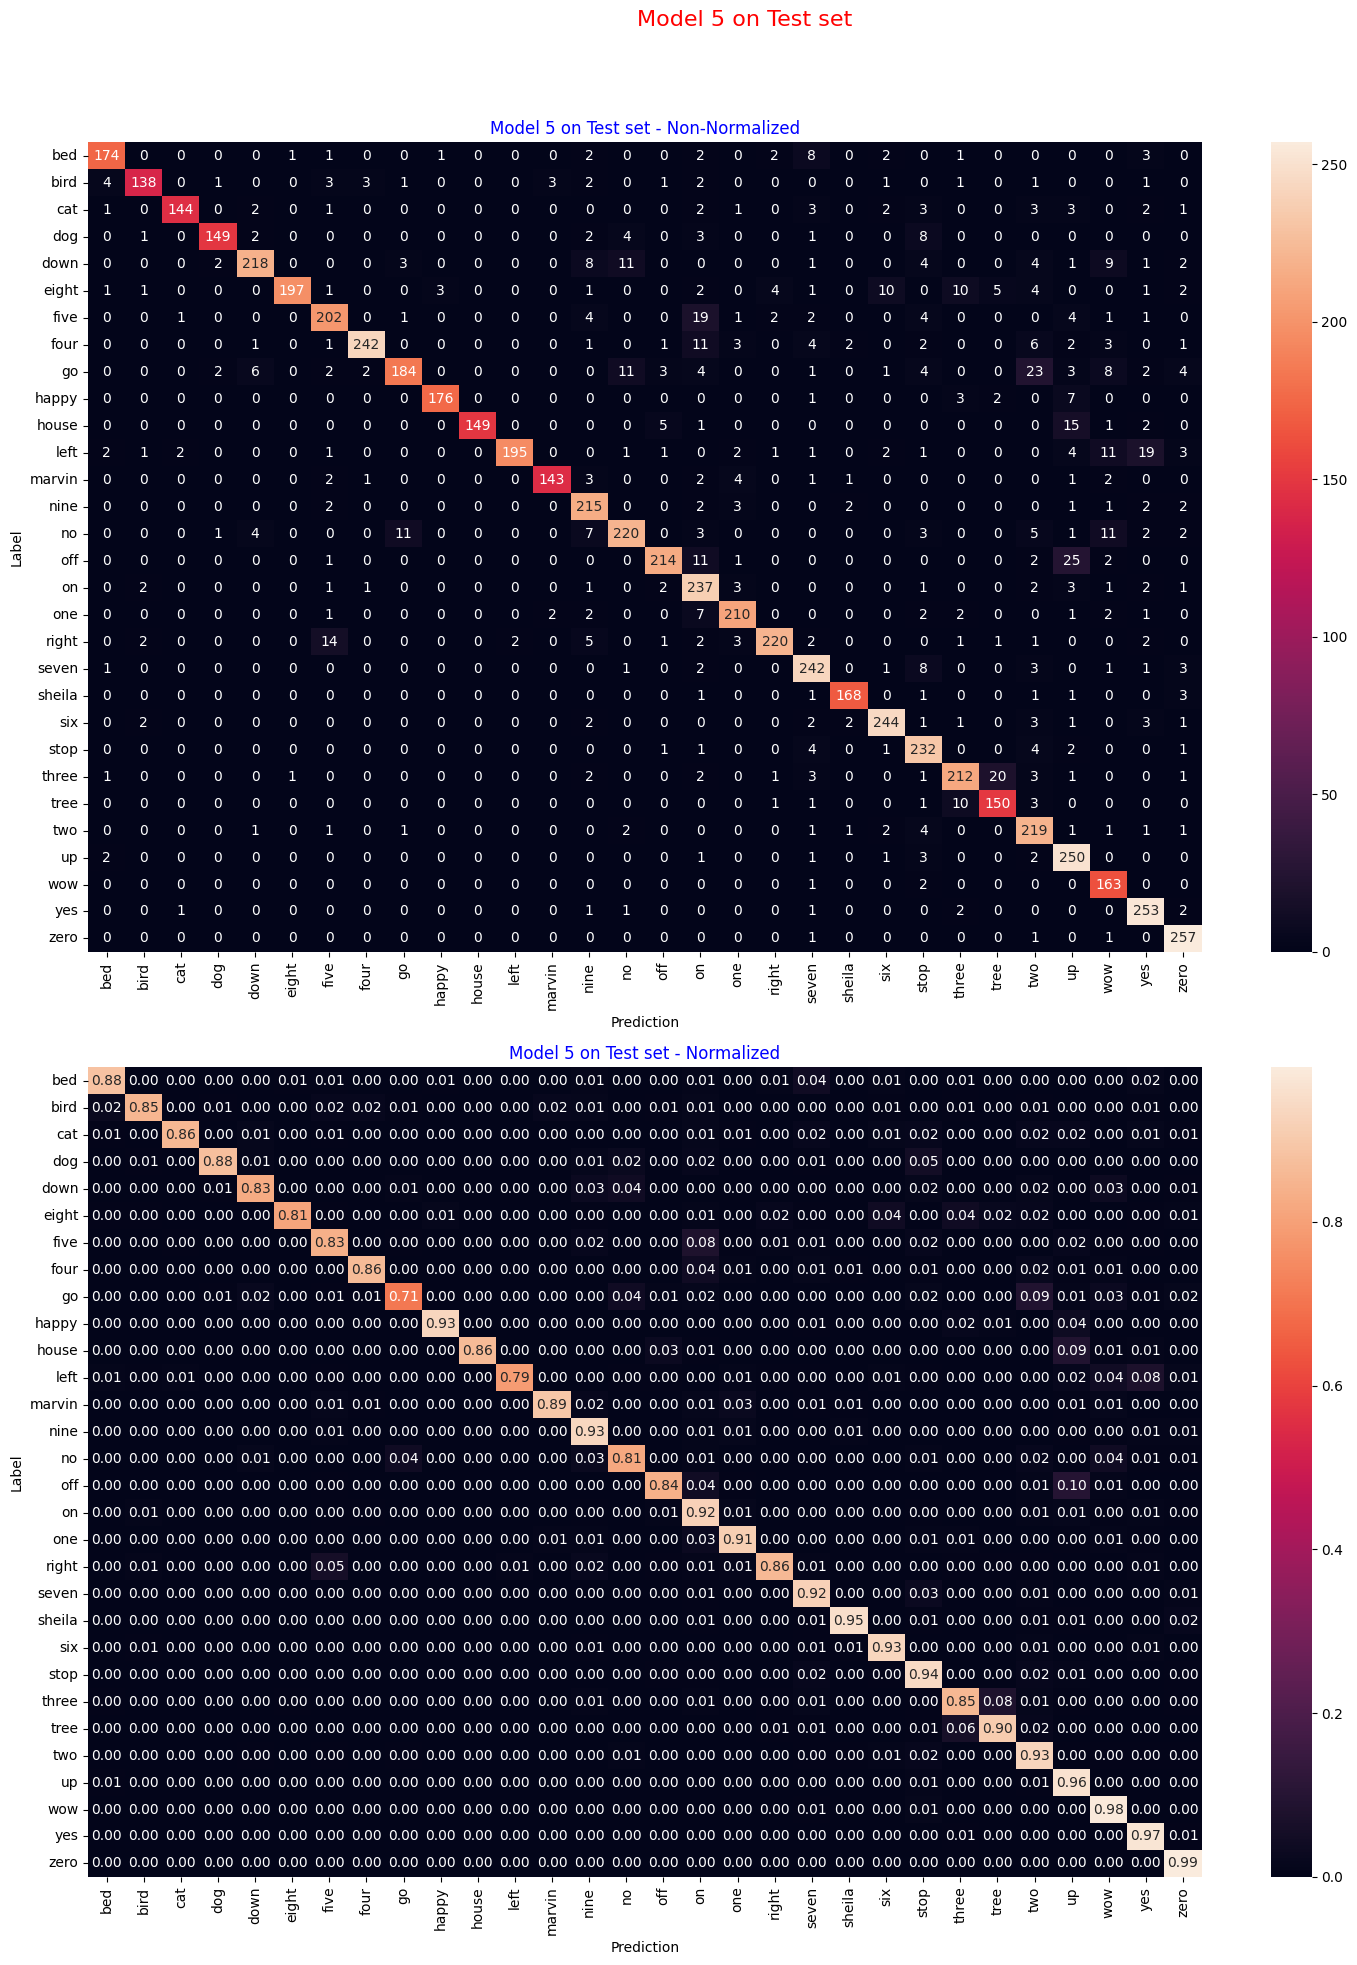

In [ ]:
plot_confusion_matrix(model5, test_ds, class_list, title="Model 5 on Test set")

Using deeper convolutional blocks we obtained a little improvement in terms of performances.

## Model 6: "One more FC layer and Dropout in Convolutional Blocks"

From the previous version of the model is clear that it tends to overfit a little bit. So, as final attempt, we are going to add some Dropout inside our convolutional blocks and also we are going to add another Fully Connected layer on top of the architecture.

In this way the model should be able to catch more features and to do not overfit too much.

In [ ]:
# WE BATCH OUT TENSORFLOW DATASETS IF NECESSARY
if train_ds.element_spec[0].shape != (None, 20, 32, 1):
  train_ds = train_ds.batch(BATCH_SIZE)
if validation_ds.element_spec[0].shape != (None, 20, 32, 1):
  validation_ds = validation_ds.batch(BATCH_SIZE)
if test_ds.element_spec[0].shape != (None, 20, 32, 1):
  test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
model6 = Sequential([
    Input(shape=INPUT_SHAPE),
    Resizing(TARGET_SHAPE[0], TARGET_SHAPE[1]),


    Conv2D(32, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),


    Conv2D(64, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),


    Flatten(),
    Dense(128, activation=None, kernel_initializer='he_uniform'),
    Activation('relu'),
    Dropout(0.2),
    Dense(64, activation=None, kernel_initializer='he_uniform'),
    Activation('relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax'),
])

In [ ]:
model6.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 280,894 (1.07 MB)

 Trainable params: 280,510 (1.07 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
model6.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

In [ ]:
model6_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             min_delta=0.0001,
                                             verbose=1,
                                             patience=20,
                                             restore_best_weights=True)

In [ ]:
EPOCHS = 70
history6 = model6.fit(
                      train_ds,
                      validation_data = validation_ds,
                      epochs = EPOCHS,
                      callbacks = model6_es
                      )

Epoch 1/70
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.2910 - f1_score: 0.2851 - loss: 2.3633 - val_accuracy: 0.3513 - val_f1_score: 0.2702 - val_loss: 2.5031
Epoch 2/70
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5328 - f1_score: 0.5328 - loss: 1.5102 - val_accuracy: 0.5087 - val_f1_score: 0.4419 - val_loss: 1.7335
Epoch 3/70
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6973 - f1_score: 0.7021 - loss: 0.9762 - val_accuracy: 0.6734 - val_f1_score: 0.6491 - val_loss: 1.1038
Epoch 4/70
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.7782 - f1_score: 0.7833 - loss: 0.7364 - val_accuracy: 0.6836 - val_f1_score: 0.6693 - val_loss: 1.0717
Epoch 5/70
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8061 - f1_score: 0.8124 - loss: 0.6351 - val_accuracy: 0.7207 - val_f1_score: 0.7201 - val_loss: 0.9319
Epoch 6/70
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8395 - f1_score: 0.8442 - loss: 0.5328 - val_accuracy: 0.7789 - val

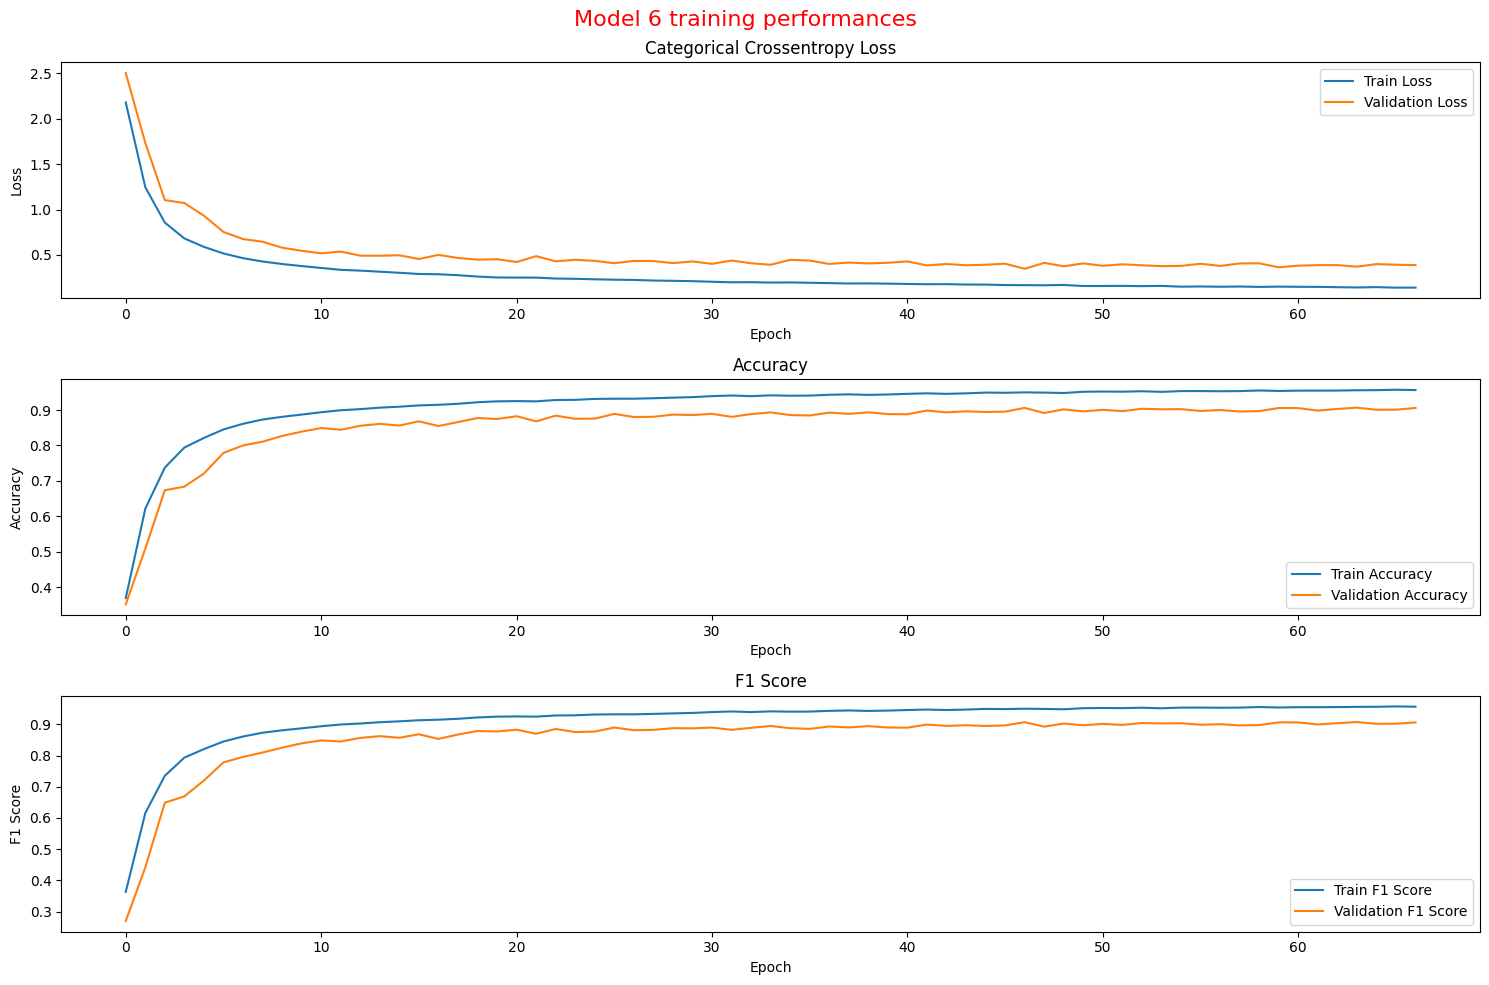

In [ ]:
plot_model_history(history6, "Model 6 training performances")

In [ ]:
model6_test_metrics = model6.evaluate(test_ds,
                                      verbose=2,
                                      return_dict=True)

213/213 - 1s - 3ms/step - accuracy: 0.9060 - f1_score: 0.9067 - loss: 0.3474


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


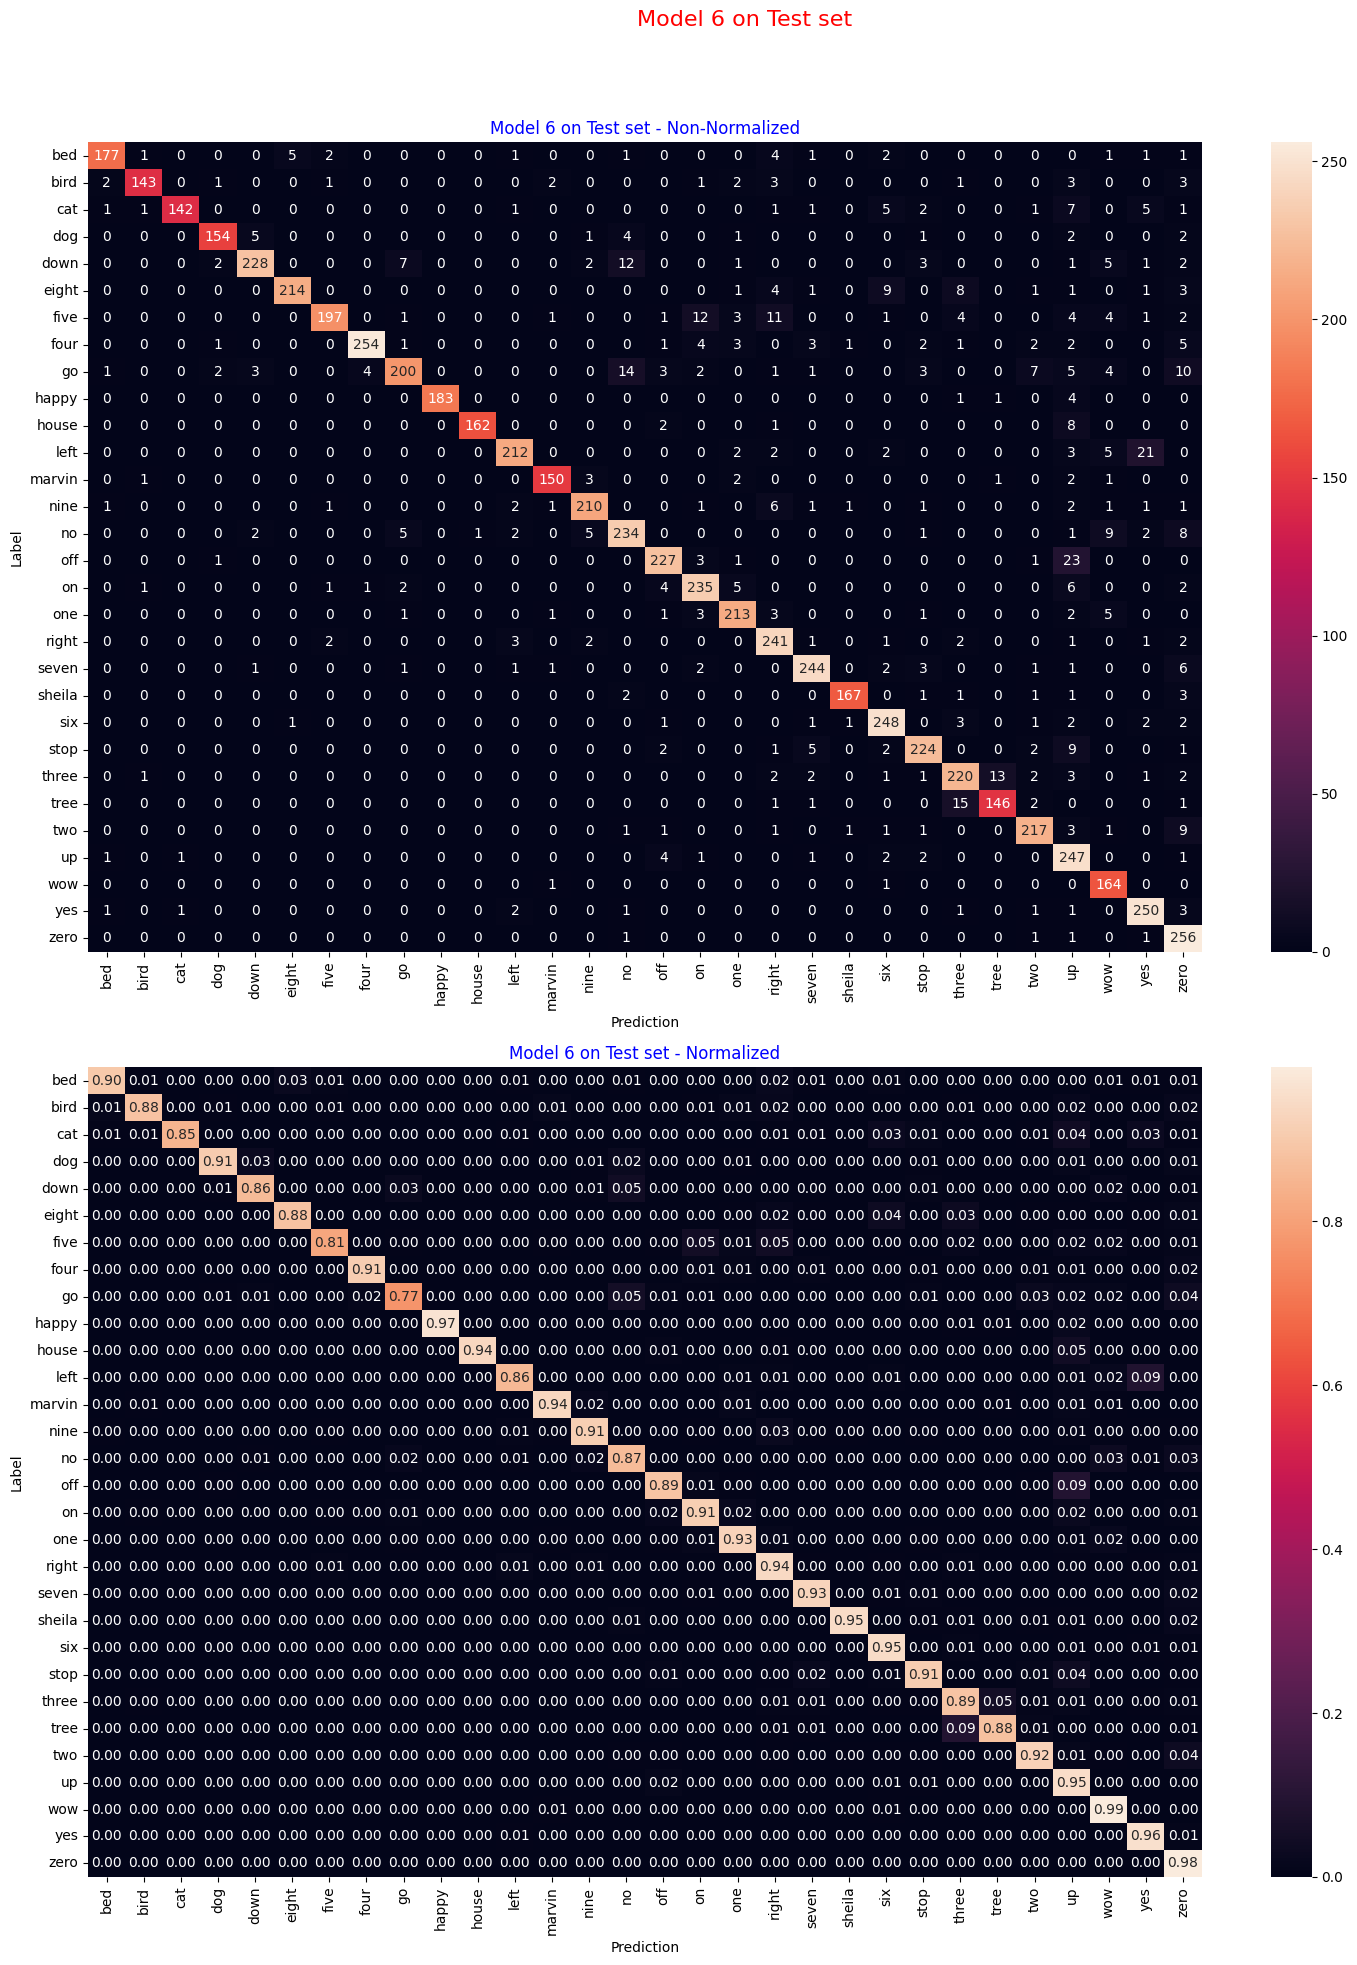

In [ ]:
plot_confusion_matrix(model6, test_ds, class_list, title="Model 6 on Test set")

Nice! we obtain a little improvement touching 90% of F1-Score.

# Testing on Pre-Trained VGG16

In this section we want to understand if with a more robust and complex convolutional model is possible to obtain higher performaces.

So, what we are going to do is to use VGG16 as convolutional network. On top of it, we are going to put the same classification head based on the two FC layers we used in our custom model.

Obviously, we are going to reshape our MFCCs in order to feed properly VGG16.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [ ]:
def convert_and_reshape(images, labels):
    # Converts images from grayscale to RGB
    images_rgb = tf.image.grayscale_to_rgb(images)
    # Image resizing to 32x32
    images_resized = tf.image.resize(images_rgb, [32, 32])
    return images_resized, labels

In [ ]:
train_ds_rgb_resized = train_ds.map(convert_and_reshape)
validation_ds_rgb_resized = validation_ds.map(convert_and_reshape)
test_ds_rgb_resized = test_ds.map(convert_and_reshape)

In [ ]:
feature_extractor = VGG16(include_top=False, input_shape=(32,32,3))

flattened = Flatten()(feature_extractor.layers[-1].output)


fc1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flattened)
dropout1 = Dropout(0.2)(fc1)
bn1 = BatchNormalization()(dropout1)

fc2 = Dense(64, activation='relu', kernel_initializer='he_uniform')(bn1)
dropout2 = Dropout(0.2)(fc2)
bn2 = BatchNormalization()(dropout2)

out = Dense(NUM_CLASSES, activation='softmax')(bn2)

model_vgg16 = Model(inputs=feature_extractor.inputs, outputs=out)

In [ ]:
model_vgg16.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,791,326 (56.42 MB)

 Trainable params: 14,790,942 (56.42 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
model_vgg16.compile(
                    optimizer = tf.keras.optimizers.AdamW(),
                    loss = tf.keras.losses.CategoricalCrossentropy(),
                    metrics = ['accuracy',
                                tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
                )

In [ ]:
model_vgg16_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  min_delta=0.0001,
                                                  verbose=1,
                                                  patience=5,
                                                  restore_best_weights=True)

In [ ]:
EPOCHS = 25
history_vgg16 = model_vgg16.fit(
                              train_ds_rgb_resized,
                              validation_data = validation_ds_rgb_resized,
                              epochs = EPOCHS,
                              callbacks = model_vgg16_es,
                              batch_size = BATCH_SIZE
                              )

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_81']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


1597/1597 ━━━━━━━━━━━━━━━━━━━━ 87s 47ms/step - accuracy: 0.1850 - f1_score: 0.1805 - loss: 2.8645 - val_accuracy: 0.1305 - val_f1_score: 0.0434 - val_loss: 3.5622
Epoch 2/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 72s 44ms/step - accuracy: 0.3889 - f1_score: 0.3862 - loss: 2.1328 - val_accuracy: 0.3864 - val_f1_score: 0.2882 - val_loss: 2.5469
Epoch 3/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.5940 - f1_score: 0.6077 - loss: 1.4436 - val_accuracy: 0.4241 - val_f1_score: 0.3122 - val_loss: 2.1413
Epoch 4/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 71s 44ms/step - accuracy: 0.6946 - f1_score: 0.7091 - loss: 1.1256 - val_accuracy: 0.4129 - val_f1_score: 0.3096 - val_loss: 2.1262
Epoch 5/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/step - accuracy: 0.7407 - f1_score: 0.7566 - loss: 0.9788 - val_accuracy: 0.4901 - val_f1_score: 0.3866 - val_loss: 1.7521
Epoch 6/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 142s 52ms/step - accuracy: 0.7812 - f1_score: 0.7958 - loss: 0.8492 - val_accuracy: 0.5681 - val_f1

In [ ]:
vvgg16_test_metrics = model_vgg16.evaluate(test_ds_rgb_resized,
                                            verbose=2,
                                            return_dict=True)

213/213 - 2s - 9ms/step - accuracy: 0.9104 - f1_score: 0.9131 - loss: 0.4499


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_81']
Received: inputs=Tensor(shape=(32, 32, 32, 3))
  warnings.warn(msg)


213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


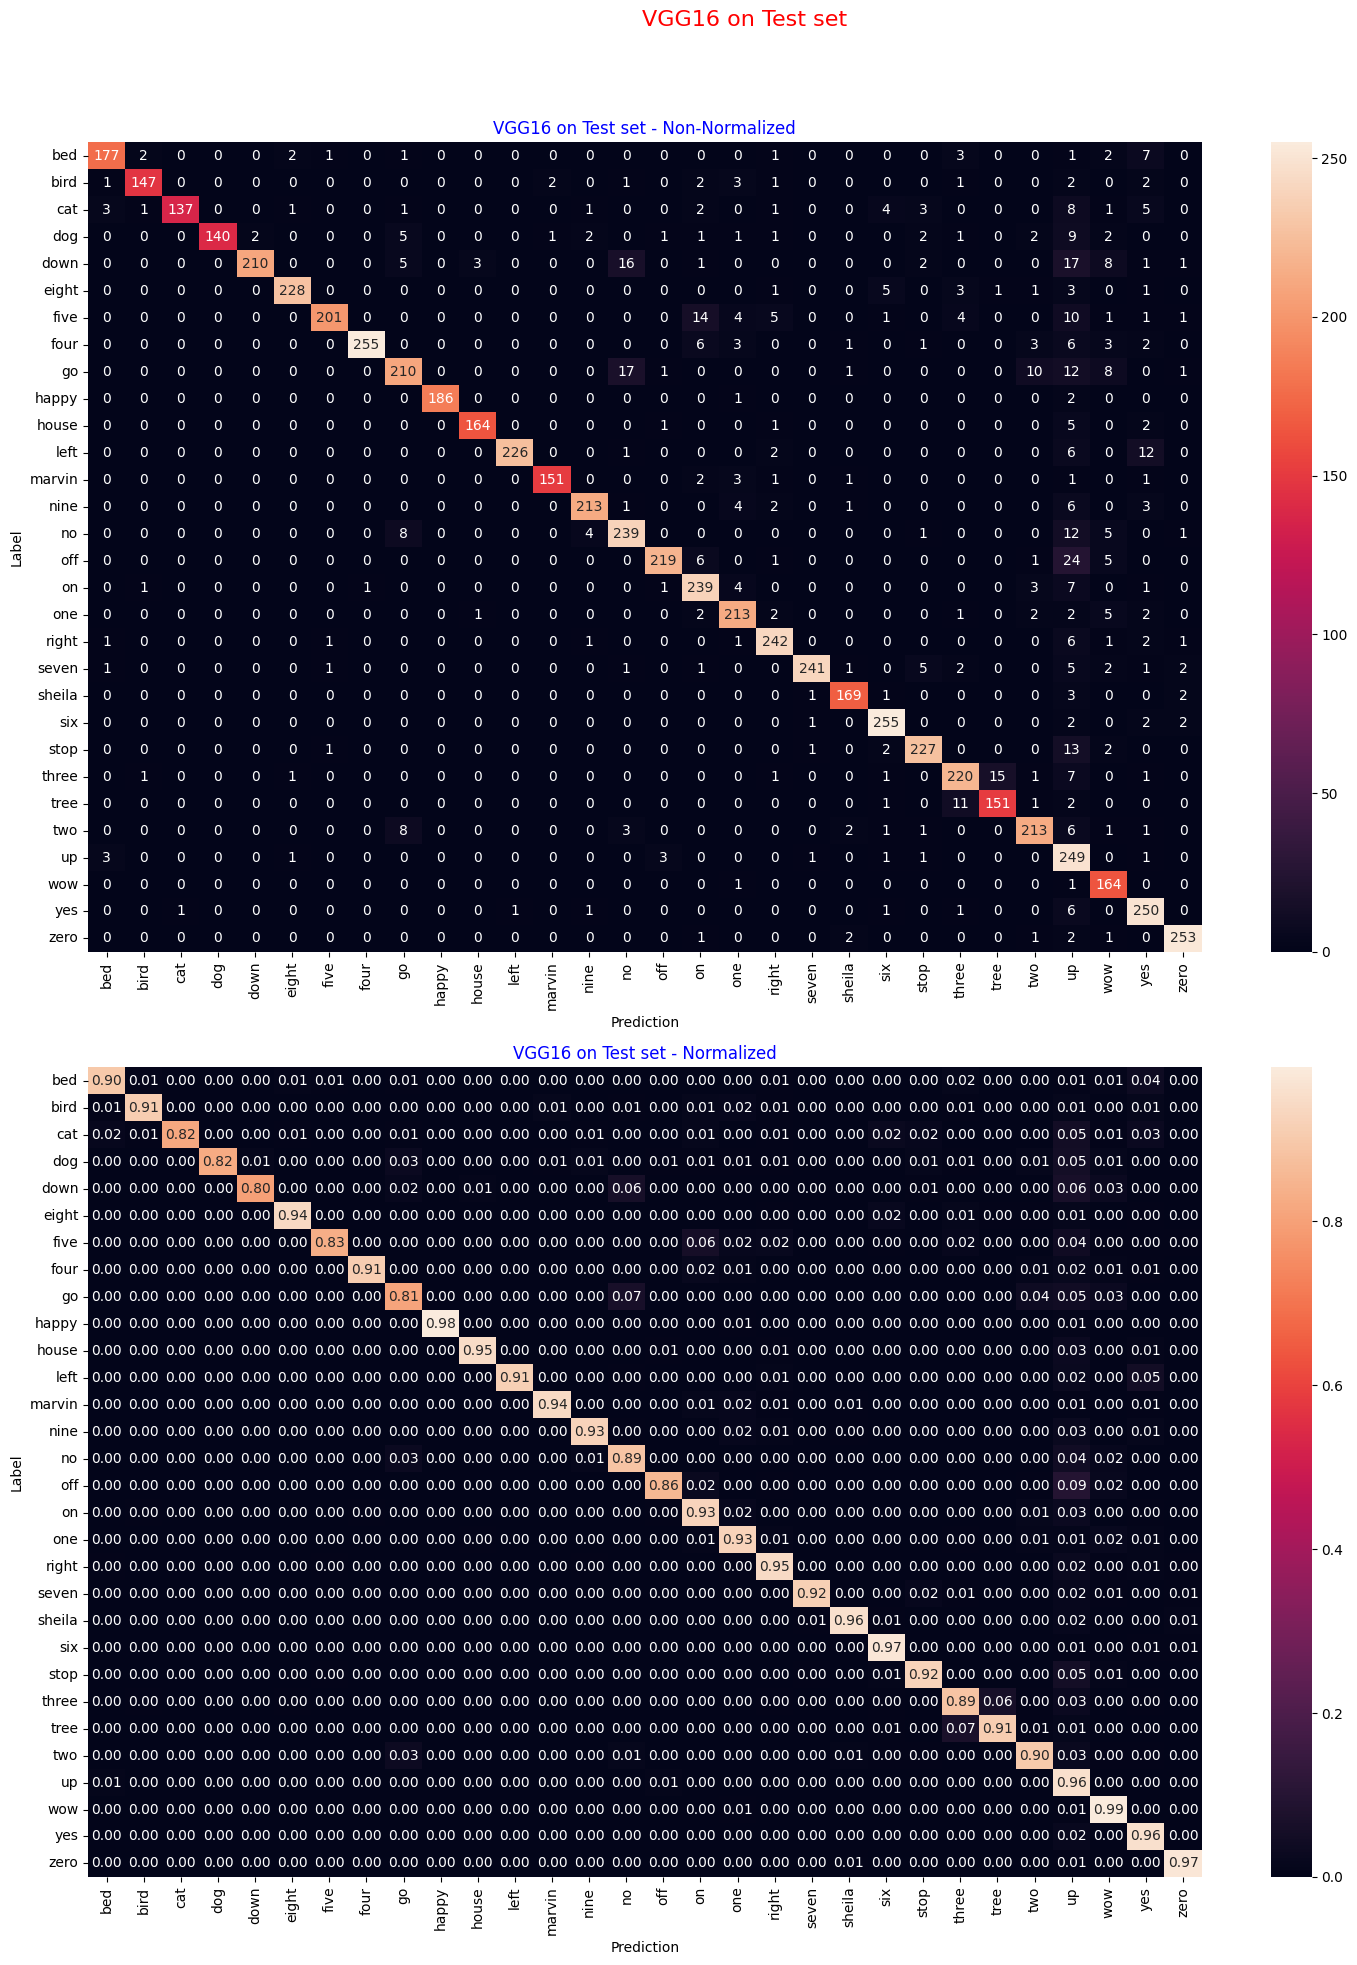

In [ ]:
plot_confusion_matrix(model_vgg16, test_ds_rgb_resized, class_list, title="VGG16 on Test set")

The results obtained using VGG16 as convolutional models are higher respect to the ones obtained by our custom model. But, they are not so higher. Thus, we can conclude that this is more or less the maximum reachable using Convolutions.

# Using a SFM to generate audio representations

Nowadays it is possible to solve the majority of audio tasks using what are called Speech Foundation Models, those are basically huge encoder-decoder based architectures.

But, instead of building a SFM from scratch, it is also possible to use the embeddings produced by a SFM as input to a downstream classifier. This idea is extremely similar to the usage of vector embeddings in NLP tasks.

In this section we are going to try to use Wav2Vec2 as embedder, then we will use its embedding as input to a classification model of our choice.

In [ ]:
!pip install transformers

from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torchaudio
import torch

In [ ]:
# Loading the Processor and the Model from Hugging Face
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
Wav2Vec_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Function to load and resample audio
def load_and_resample_audio(file_path, target_sample_rate=16000):
    """
    Loads an audio file and resamples it to the target sample rate.

    :param file_path: Path to the audio file.
    :param target_sample_rate: Desired sample rate for the audio.
    :return: Resampled audio waveform.
    """
    waveform, sample_rate = torchaudio.load(file_path)  # Load the audio file
    if sample_rate != target_sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)  # Resample to the target sample rate
    return waveform

# Function to extract embeddings from the model
def extract_embeddings(inputs):
    """
    Extracts audio embeddings from the Wav2Vec model.

    This function uses the Wav2Vec model to obtain hidden states (embeddings)
    and computes the mean of the hidden states from the last layer.

    :param inputs: Input audio data for the model.
    :return: Computed audio embeddings.
    """
    # Obtain embeddings (hidden states) from the model
    with torch.no_grad():
        outputs = Wav2Vec_model(input_values=inputs, output_hidden_states=True)

    # Extract hidden states (embeddings) from the last layer
    hidden_states = outputs.hidden_states[-1]
    embeddings = torch.mean(hidden_states, dim=1)  # Take the mean of the hidden states
    return embeddings

In [ ]:
train_df.head()

filename                       path class  duration
0  988e2f9a_nohash_0.wav  bed/988e2f9a_nohash_0.wav   bed       1.0
1  e900b652_nohash_0.wav  bed/e900b652_nohash_0.wav   bed       1.0
2  92a9c5e6_nohash_0.wav  bed/92a9c5e6_nohash_0.wav   bed       1.0
3  652b3da7_nohash_0.wav  bed/652b3da7_nohash_0.wav   bed       1.0
4  d8c52371_nohash_0.wav  bed/d8c52371_nohash_0.wav   bed       1.0

In [ ]:
waveform = load_and_resample_audio('bed/ece1a95a_nohash_1.wav')
embeddings = extract_embeddings(waveform)

# Now embeddings can be used as input to a downstream classification model
print("Extracted embeddings:", embeddings.shape)

Extracted embeddings: torch.Size([1, 768])


## Downsampling our data

It is not possible to run Wav2Vec on the entire dataset due to the fact that we need to much time. So, we are going to build a random balanced subsample of out data.

In particular, we are running this notebook on Colab, so the avaiable RAM is not enough to build the embedding representation of the entire dataset.

Thus, we are going to build a random and balanced downsample of our data.

In [ ]:
def balanced_downsample(df, n_samples_per_class):
    """
    Performs balanced downsampling of the DataFrame.

    :param df: Original DataFrame containing the columns 'filename', 'path', 'class', 'duration'.
    :param n_samples_per_class: Number of samples to extract for each class.
    :return: Balanced downsampled DataFrame.
    """
    # List to store the DataFrames of each class
    balanced_samples = []

    # Get unique classes
    classes = df['class'].unique()

    for cls in classes:
        # Select rows corresponding to the class
        class_samples = df[df['class'] == cls]

        # Perform random downsampling
        if len(class_samples) > n_samples_per_class:
            class_samples = class_samples.sample(n=n_samples_per_class, random_state=42)

        # Add the balanced samples to the list
        balanced_samples.append(class_samples)

    # Concatenate the DataFrames of the classes
    balanced_df = pd.concat(balanced_samples, ignore_index=True)

    return balanced_df

In [ ]:
n_samples = 100  # Number of samples per class
DS_train_df = balanced_downsample(train_df, n_samples)

n_samples = 50  # Number of samples per class
DS_validation_df = balanced_downsample(validation_df, n_samples)

n_samples = 50  # Number of samples per class
DS_test_df = balanced_downsample(test_df, n_samples)

In [ ]:
def add_embeddings_to_dataframe(df):
    """
    Adds audio embeddings to the DataFrame.

    This function processes each audio file specified in the DataFrame by loading and resampling the audio data,
    extracting embeddings from the audio waveform, and appending these embeddings as a new column in the DataFrame.

    :param df: DataFrame containing the column 'path' with the file paths of the audio files.
    :return: DataFrame with an additional column 'embedding' containing the extracted audio embeddings.
    """
    embeddings_list = []

    for index, row in df.iterrows():
        file_path = row['path']
        audio_waveform = load_and_resample_audio(file_path)
        audio_embedding = extract_embeddings(audio_waveform)
        embeddings_list.append(audio_embedding)

    df['embedding'] = embeddings_list
    return df

In [ ]:
DS_train_df = add_embeddings_to_dataframe(DS_train_df)
DS_validation_df = add_embeddings_to_dataframe(DS_validation_df)
DS_test_df = add_embeddings_to_dataframe(DS_test_df)

In [ ]:
def create_tf_dataset_SFM(df):
    """
    Creates a TensorFlow dataset from a DataFrame.

    Parameters:
    - df: DataFrame containing the columns 'embedding' and 'class'.

    Returns:
    - dataset: TensorFlow Dataset containing the data and labels.
    """

    # Extract the data and labels from the DataFrame
    embeddings = np.array(df['embedding'].tolist())  # List of embedded audios built using a SFM
    labels = df['class'].tolist()  # List of class labels

    # Convert string labels to numerical values
    label_encoder = LabelEncoder()  # Initialize the label encoder
    labels_encoded = label_encoder.fit_transform(labels)  # Encode labels

    # Convert the numerical labels to one-hot encoding
    labels_one_hot = to_categorical(labels_encoded, num_classes=30)  # One-hot encode the labels

    # Create the TensorFlow dataset from the embeddings and one-hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((embeddings, labels_one_hot))

    return dataset  # Return the created TensorFlow dataset

In [ ]:
train_SFM_ds = create_tf_dataset_SFM(DS_train_df).shuffle(buffer_size = 10000)
validation_SFM_ds = create_tf_dataset_SFM(DS_validation_df).shuffle(buffer_size = 10000)
test_SFM_ds = create_tf_dataset_SFM(DS_test_df).shuffle(buffer_size = 10000)

In [ ]:
iterator = validation_SFM_ds.as_numpy_iterator()
first_element = next(iterator)
print("First element of training dataset:")
print("Embedding Shape:", first_element[0].shape)
print("One-hot-encoded Class:\n", first_element[1])

First element of training dataset:
Embedding Shape: (1, 768)
One-hot-encoded Class:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0.]


In [ ]:
print(f"The number of samples in the training set is: {len(DS_train_df)}")
print(f"The number of samples in the validation set is: {len(DS_validation_df)}")
print(f"The number of samples in the test set is: {len(DS_test_df)}")

The number of samples in the training set is: 3000
The number of samples in the validation set is: 1500
The number of samples in the test set is: 1500


## Convolutional Model

Since the audio embeddings produced by Wav2Vec2 have are tensors of shape (1, 768), the first idea is to apply 1D Convolutions on them.

In [ ]:
NUM_CLASSES = len(class_list)
INPUT_SHAPE = (None, 768)
BATCH_SIZE = 32

In [ ]:
if train_SFM_ds.element_spec[0].shape == (1, 768):
  train_SFM_ds = train_SFM_ds.batch(BATCH_SIZE)
if validation_SFM_ds.element_spec[0].shape == (1, 768):
  validation_SFM_ds = validation_SFM_ds.batch(BATCH_SIZE)
if test_SFM_ds.element_spec[0].shape == (1, 768):
  test_SFM_ds = test_SFM_ds.batch(BATCH_SIZE)

### Conv-SFM-1: A simple 1D convolution

This first model is extremely simple:

CONV -> ReLU -> CONV -> ReLU -> GlobalAveragePooling1D -> FC

In [ ]:
Conv_SFM_model1 = Sequential([
    Input(shape=INPUT_SHAPE),

    Conv1D(128, kernel_size=1, activation='relu'),
    Conv1D(128, kernel_size=1, activation='relu'),

    GlobalAveragePooling1D(),
    Dense(NUM_CLASSES, activation='softmax'),
])

In [ ]:
Conv_SFM_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, None, 128)           │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, None, 128)           │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,814 (464.12 KB)

 Trainable params: 118,814 (464.12 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
Conv_SFM_model1.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

In [ ]:
Conv_SFM_model1_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      min_delta=0.00001,
                                                      verbose=1,
                                                      patience=10,
                                                      restore_best_weights=True)

In [ ]:
EPOCHS = 40
history_Conv_SFM_model1 = Conv_SFM_model1.fit(
                          train_SFM_ds,
                          validation_data = validation_SFM_ds,
                          epochs = EPOCHS,
                          callbacks=Conv_SFM_model1_es
                      )

Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.1758 - f1_score: 0.1395 - loss: 3.2680 - val_accuracy: 0.5427 - val_f1_score: 0.5177 - val_loss: 2.5990
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6288 - f1_score: 0.6043 - loss: 2.2509 - val_accuracy: 0.7487 - val_f1_score: 0.7476 - val_loss: 1.4601
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8044 - f1_score: 0.8026 - loss: 1.2066 - val_accuracy: 0.8093 - val_f1_score: 0.8134 - val_loss: 0.9602
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8483 - f1_score: 0.8506 - loss: 0.7972 - val_accuracy: 0.8307 - val_f1_score: 0.8338 - val_loss: 0.7550
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8758 - f1_score: 0.8761 - loss: 0.5954 - val_accuracy: 0.8387 - val_f1_score: 0.8387 - val_loss: 0.6841
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8824 - f1_score: 0.8829 - loss: 0.5284 - val_accuracy: 0.8473 - val_f1_score: 0.8486 - val_loss

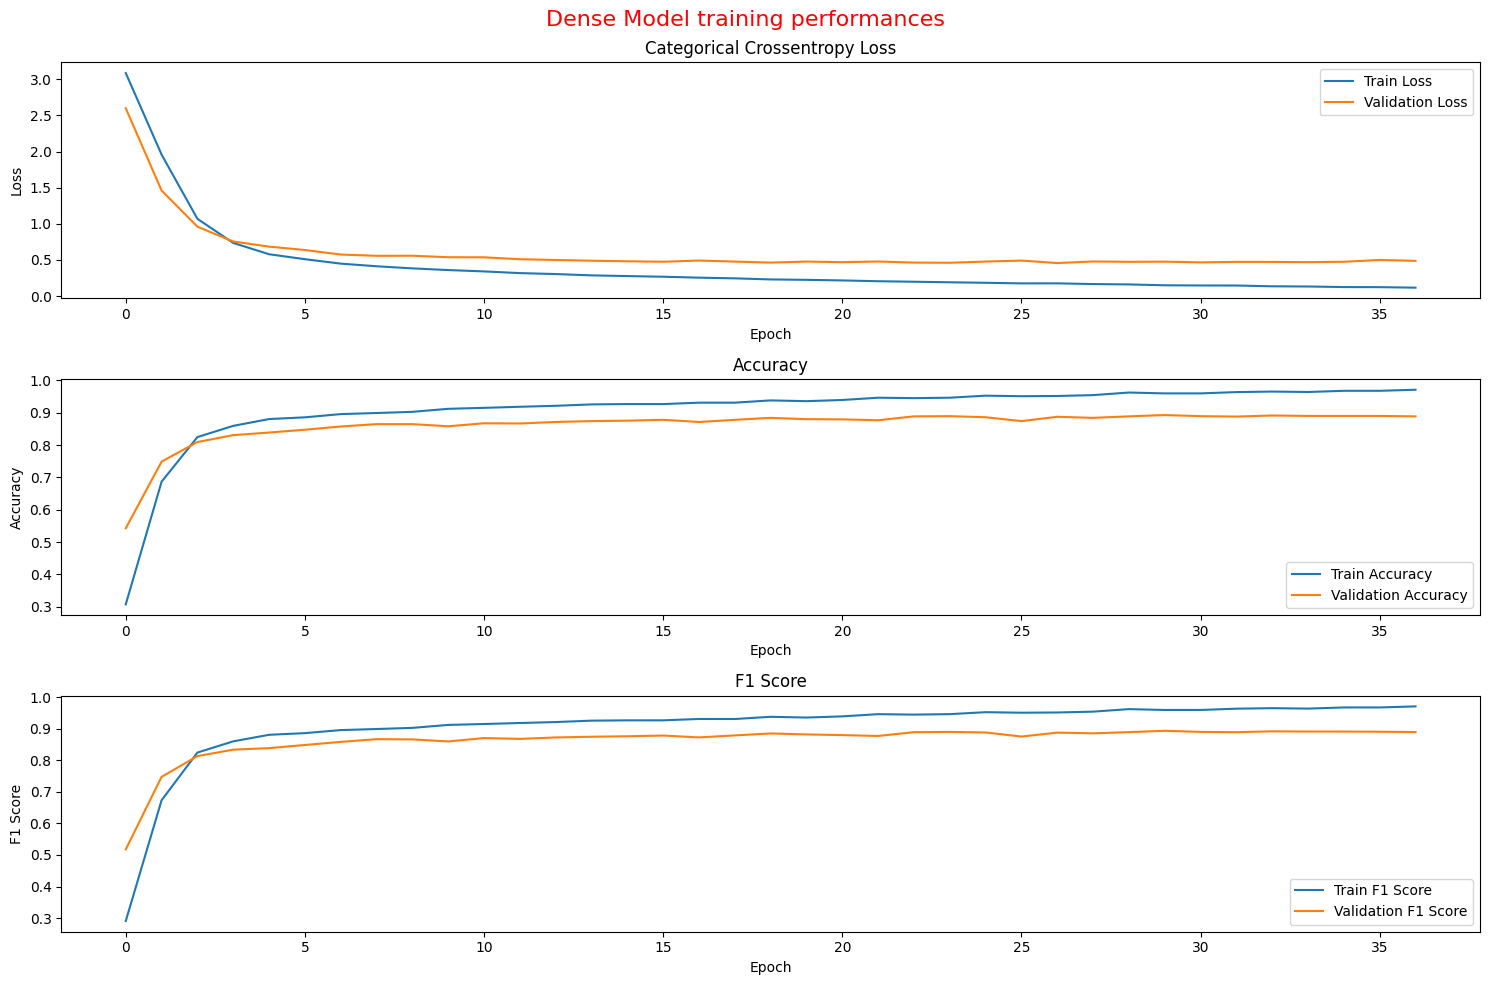

In [ ]:
plot_model_history(history_Conv_SFM_model1, "Covolutional Model training performances")

In [ ]:
Conv_SFM_model1_test_metrics = Conv_SFM_model1.evaluate(test_SFM_ds,
                                                        verbose=2,
                                                        return_dict=True)

47/47 - 0s - 3ms/step - accuracy: 0.9047 - f1_score: 0.9051 - loss: 0.3951


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


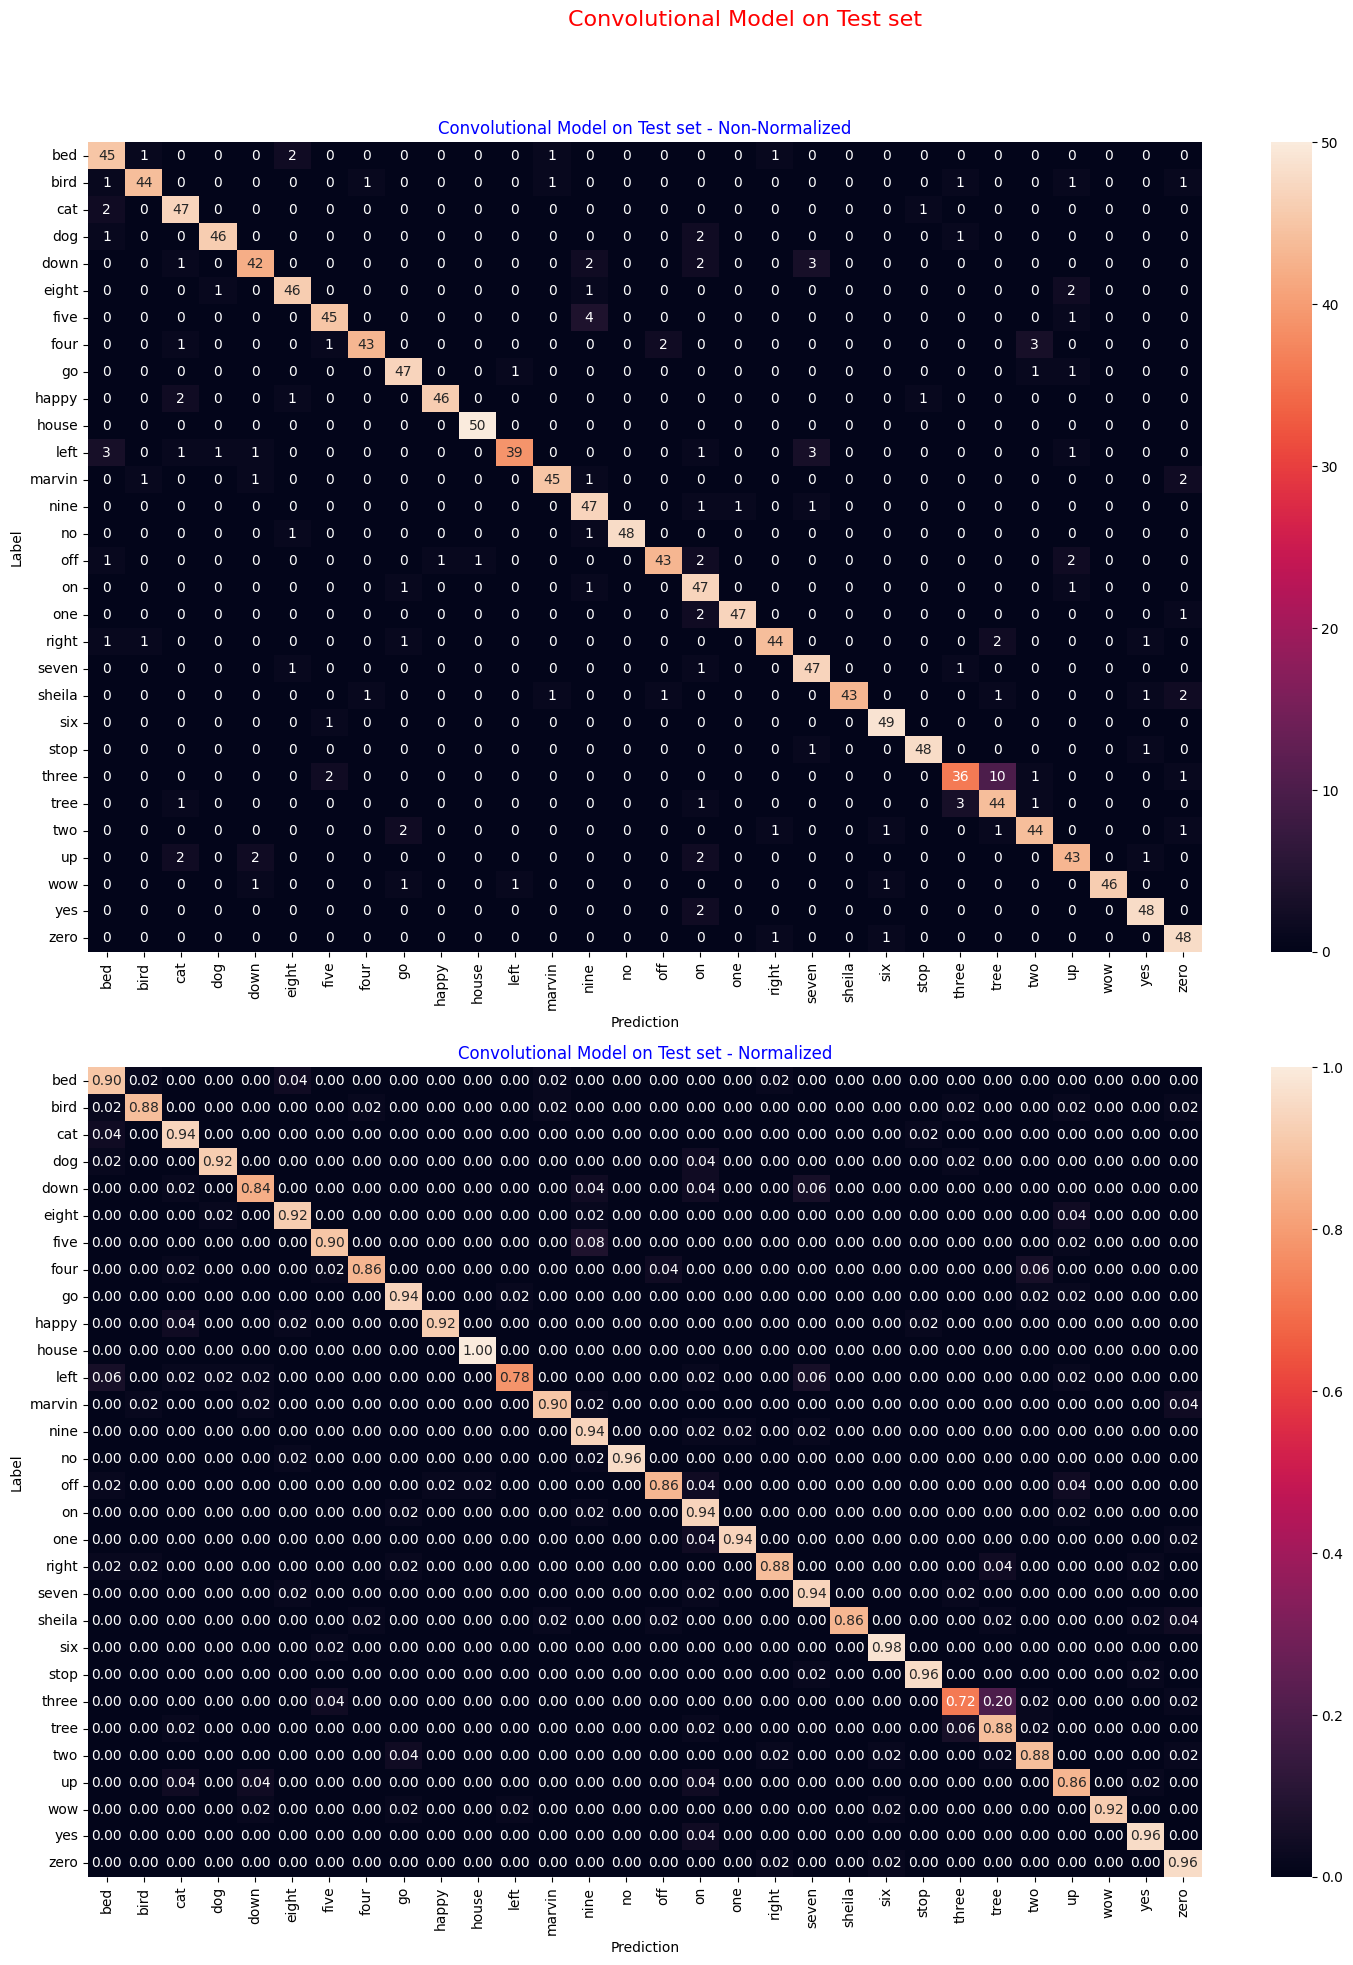

In [ ]:
plot_confusion_matrix(Conv_SFM_model1, test_SFM_ds, class_list, title="Convolutional Model on Test set")

Good results, but we can try to improve it a little bit.

### Conv-SFM-2: Adding Dropout and Batch Normalization

Now, it is obvious that the model tends to overfit very quickly, so, we are going to add Batch Normalization and Dropout in order to prevent this aspect.

In [ ]:
Conv_SFM_model2 = Sequential([
    Input(shape=INPUT_SHAPE),

    Conv1D(128, kernel_size=1, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    Conv1D(128, kernel_size=1, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    GlobalAveragePooling1D(),
    Dense(NUM_CLASSES, activation='softmax'),
])

In [ ]:
Conv_SFM_model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, None, 128)           │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, None, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, None, 128)           │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, None, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,838 (468.12 KB)

 Trainable params: 119,326 (466.12 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
Conv_SFM_model2.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

In [ ]:
Conv_SFM_model2_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      min_delta=0.00001,
                                                      verbose=1,
                                                      patience=10,
                                                      restore_best_weights=True)

In [ ]:
EPOCHS = 40
history_Conv_SFM_model2 = Conv_SFM_model2.fit(
                          train_SFM_ds,
                          validation_data = validation_SFM_ds,
                          epochs = EPOCHS,
                          callbacks=Conv_SFM_model2_es
                      )

Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.2398 - f1_score: 0.2338 - loss: 2.9350 - val_accuracy: 0.6000 - val_f1_score: 0.6164 - val_loss: 2.9664
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7311 - f1_score: 0.7299 - loss: 1.3250 - val_accuracy: 0.7640 - val_f1_score: 0.7903 - val_loss: 2.3208
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8276 - f1_score: 0.8279 - loss: 0.8657 - val_accuracy: 0.8240 - val_f1_score: 0.8305 - val_loss: 1.5956
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8528 - f1_score: 0.8535 - loss: 0.6978 - val_accuracy: 0.8673 - val_f1_score: 0.8711 - val_loss: 0.9572
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8826 - f1_score: 0.8833 - loss: 0.5772 - val_accuracy: 0.8627 - val_f1_score: 0.8663 - val_loss: 0.7321
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8857 - f1_score: 0.8872 - loss: 0.5202 - val_accuracy: 0.8713 - val_f1_score: 0.8760 - val_los

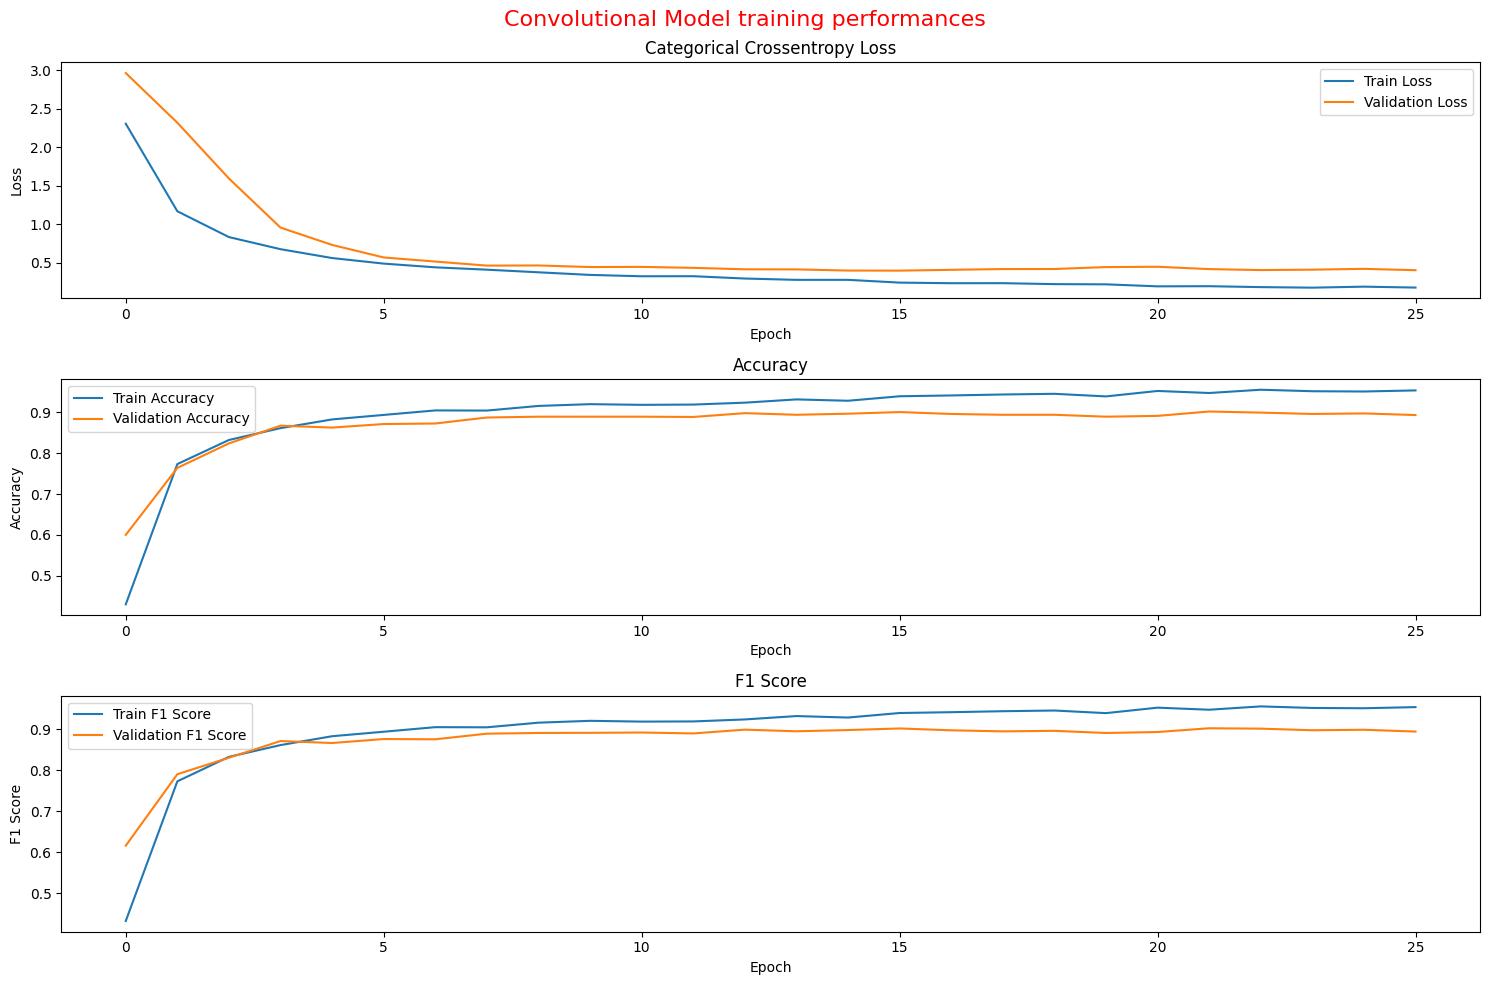

In [ ]:
plot_model_history(history_Conv_SFM_model2, "Convolutional Model training performances")

In [ ]:
Conv_SFM_model2_test_metrics = Conv_SFM_model2.evaluate(test_SFM_ds,
                                                        verbose=2,
                                                        return_dict=True)

47/47 - 0s - 4ms/step - accuracy: 0.9140 - f1_score: 0.9151 - loss: 0.3348


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


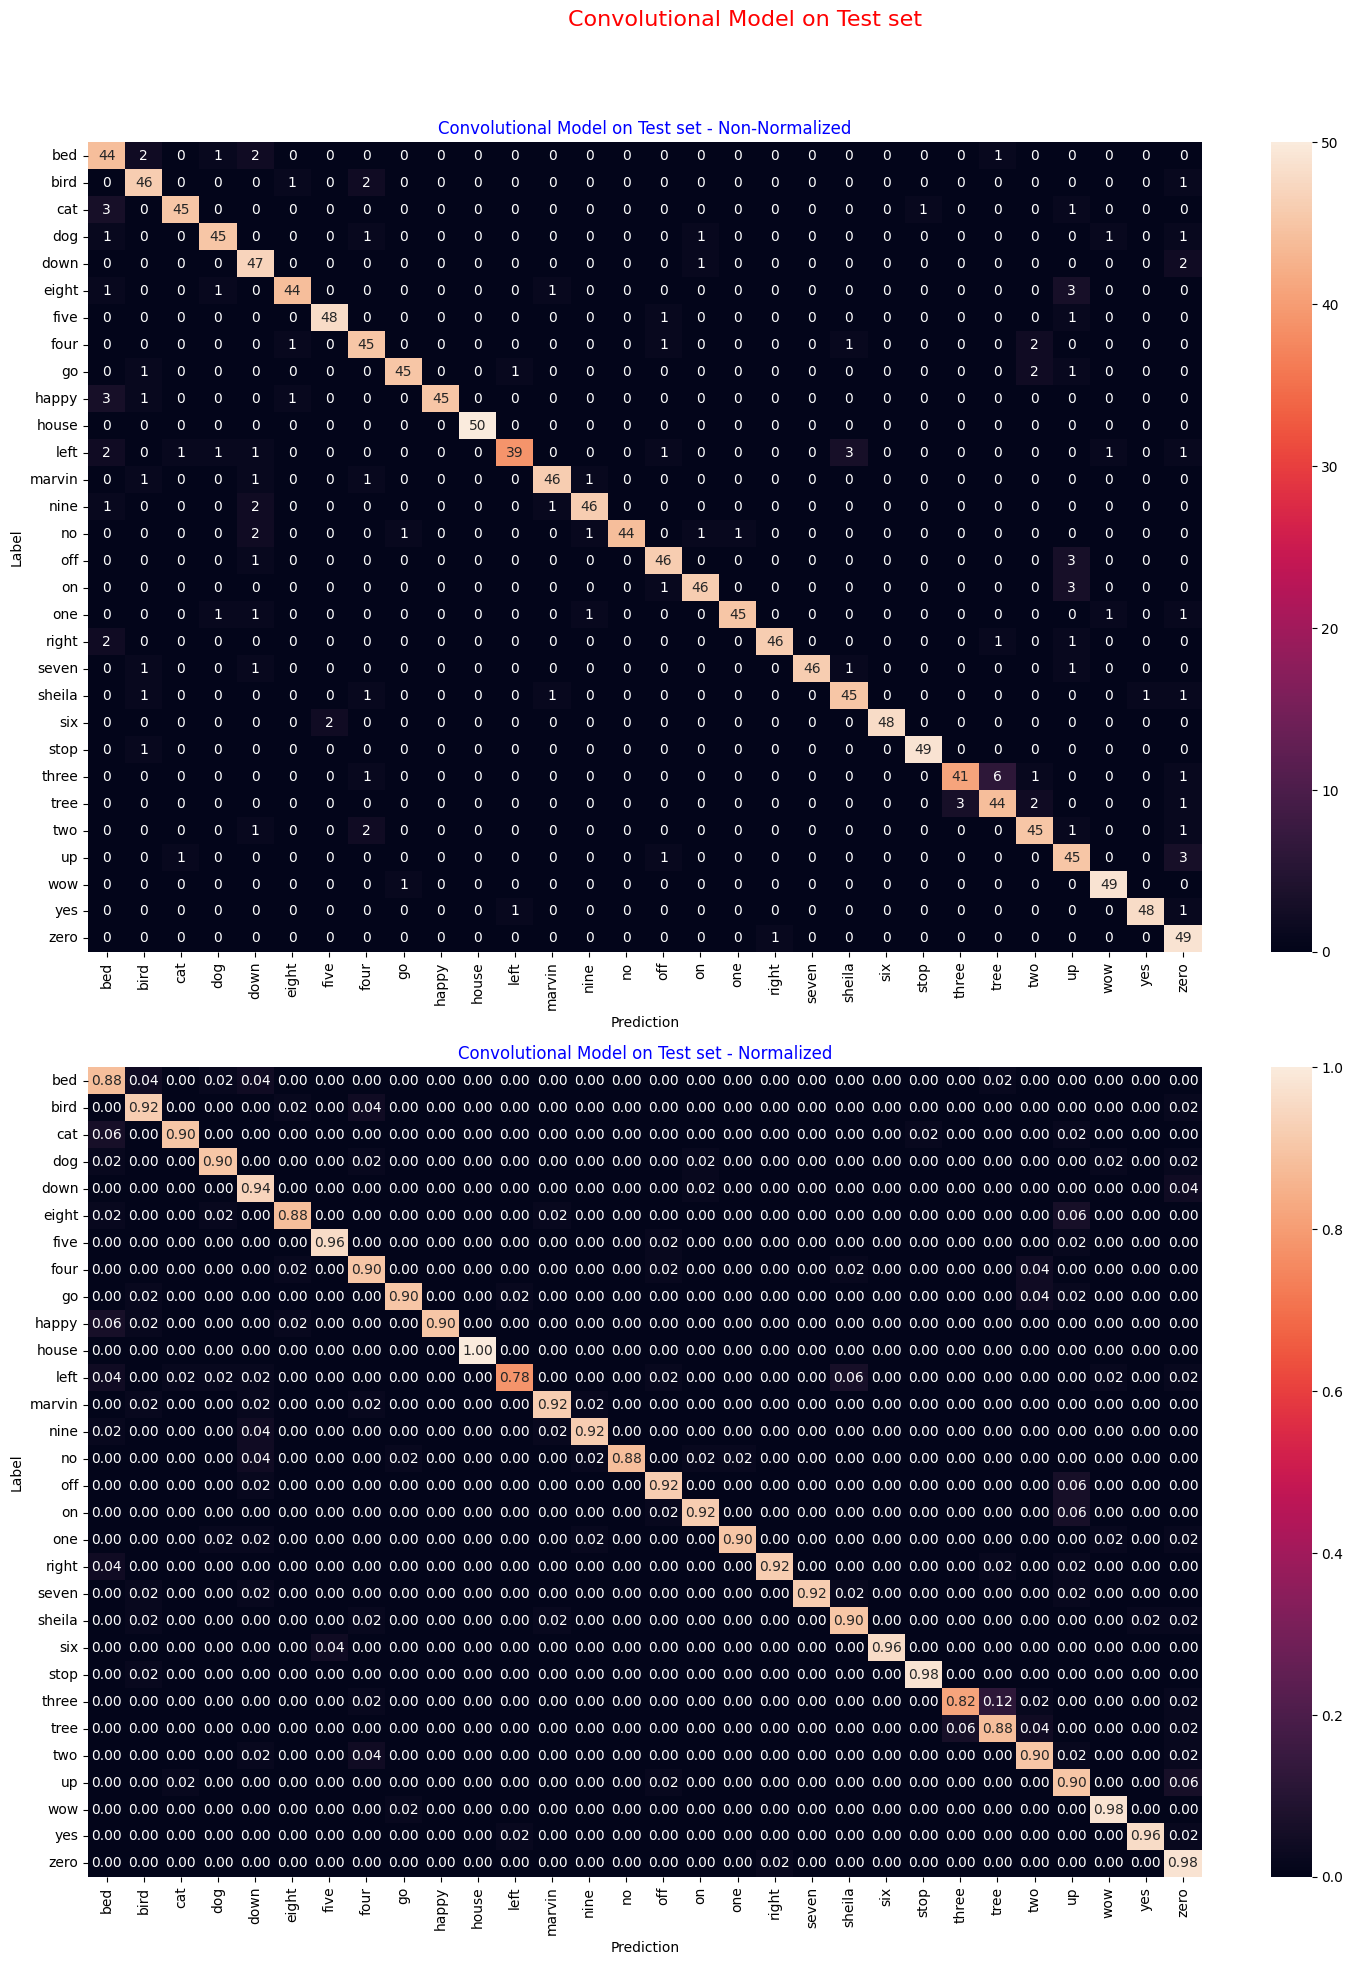

In [ ]:
plot_confusion_matrix(Conv_SFM_model2, test_SFM_ds, class_list, title="Convolutional Model on Test set")

As we can see adding Batch Normalization and Dropout we obtained better results.

### Conv-SFM-3: A deeper network

Now we are going to increase the depth of our convolutional architecture in order to understand if a deeper network is able to obtain better performances.

In [ ]:
Conv_SFM_model3 = Sequential([
    Input(shape=INPUT_SHAPE),

    Conv1D(128, kernel_size=1, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    Conv1D(128, kernel_size=1, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),


    Conv1D(128, kernel_size=1, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    Conv1D(128, kernel_size=1, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),


    Conv1D(128, kernel_size=1, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    Conv1D(128, kernel_size=1, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),


    Conv1D(128, kernel_size=1, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    Conv1D(128, kernel_size=1, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),



    GlobalAveragePooling1D(),
    Dense(NUM_CLASSES, activation='softmax'),
])

In [ ]:
Conv_SFM_model3.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_80 (Conv1D)                   │ (None, None, 128)           │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_78               │ (None, None, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_78 (Activation)           │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_81 (Conv1D)                   │ (None, None, 128)           │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_79               │ (None, None, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_79 (Activation)           │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_82 (Conv1D)                   │ (None, None, 128)           │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_80               │ (None, None, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_80 (Activation)           │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_83 (Conv1D)                   │ (None, None, 128)           │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_81               │ (None, None, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_81 (Activation)           │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_81 (Dropout)                 │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_84 (Conv1D)                   │ (None, None, 128)           │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_82               │ (None, None, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_82 (Activation)           │ (None, None, 128)           │              

 Total params: 221,982 (867.12 KB)

 Trainable params: 219,934 (859.12 KB)

 Non-trainable params: 2,048 (8.00 KB)

In [ ]:
Conv_SFM_model3.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

In [ ]:
Conv_SFM_model3_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      min_delta=0.00001,
                                                      verbose=1,
                                                      patience=20,
                                                      restore_best_weights=True)

In [ ]:
EPOCHS = 250
history_Conv_SFM_model3 = Conv_SFM_model3.fit(
                          train_SFM_ds,
                          validation_data = validation_SFM_ds,
                          epochs = EPOCHS,
                          callbacks=Conv_SFM_model3_es
                      )

Epoch 1/250
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.0289 - f1_score: 0.0237 - loss: 3.8699 - val_accuracy: 0.0160 - val_f1_score: 0.0020 - val_loss: 3.4179
Epoch 2/250
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0397 - f1_score: 0.0383 - loss: 3.6509 - val_accuracy: 0.0333 - val_f1_score: 0.0022 - val_loss: 3.4453
Epoch 3/250
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0499 - f1_score: 0.0490 - loss: 3.5271 - val_accuracy: 0.0407 - val_f1_score: 0.0141 - val_loss: 3.3947
Epoch 4/250
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0769 - f1_score: 0.0740 - loss: 3.3613 - val_accuracy: 0.1000 - val_f1_score: 0.0857 - val_loss: 3.2243
Epoch 5/250
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0802 - f1_score: 0.0766 - loss: 3.2699 - val_accuracy: 0.1120 - val_f1_score: 0.1021 - val_loss: 3.0744
Epoch 6/250
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1241 - f1_score: 0.1178 - loss: 3.0869 - val_accuracy: 0.2260 - val_f1_score: 0.2335 - v

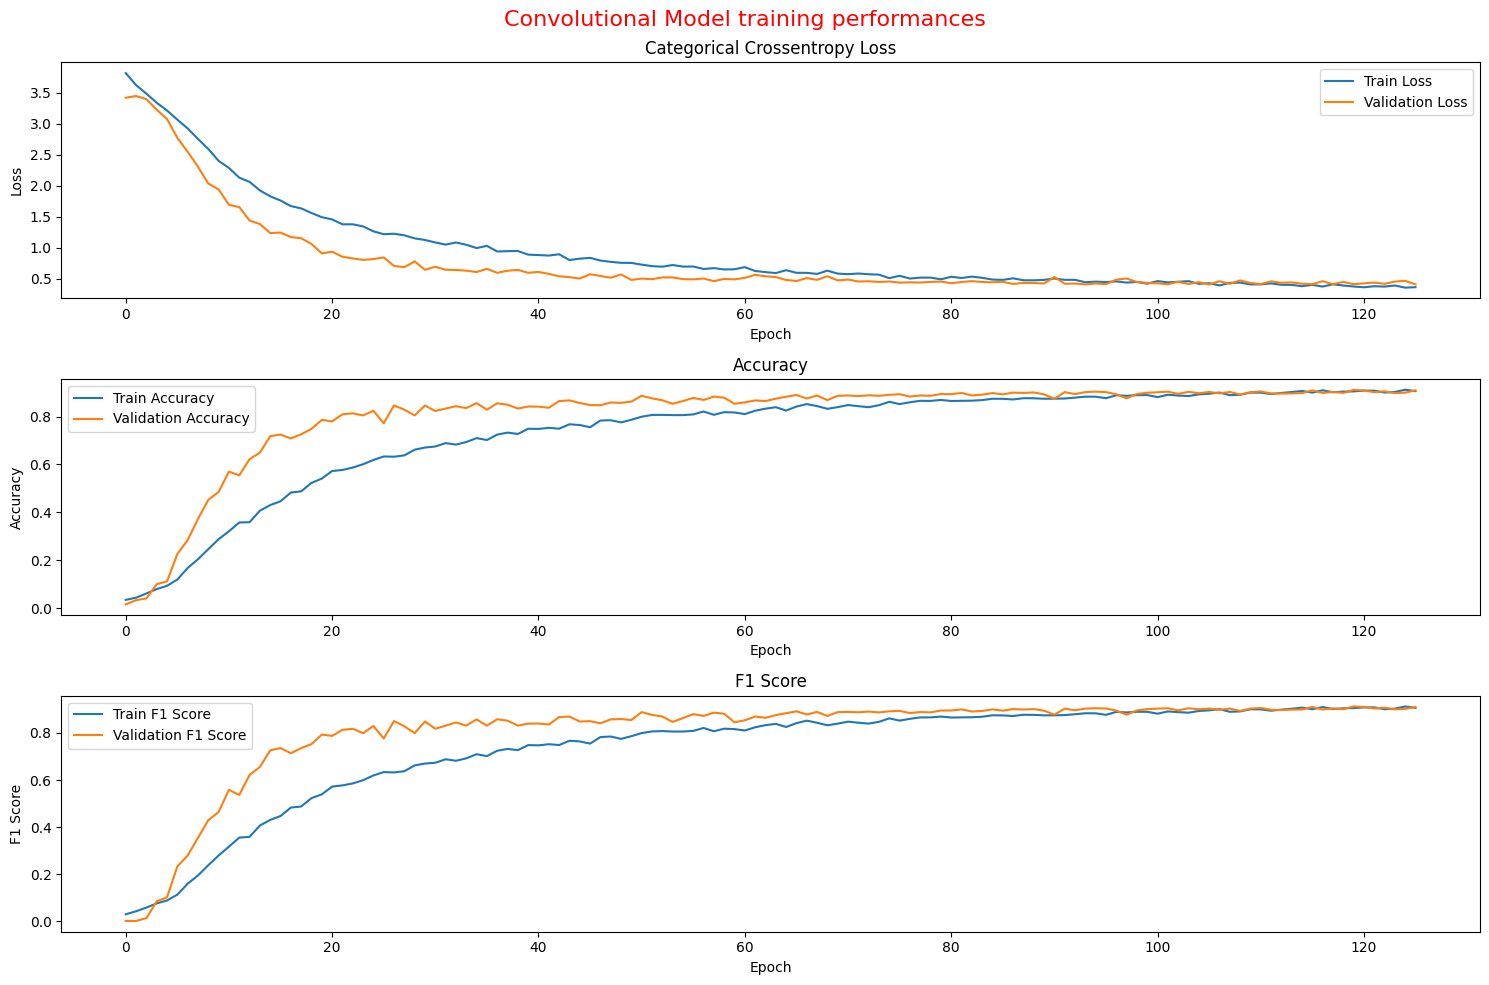

In [ ]:
plot_model_history(history_Conv_SFM_model3, "Convolutional Model training performances")

In [ ]:
Conv_SFM_model3_test_metrics = Conv_SFM_model3.evaluate(test_SFM_ds,
                                                        verbose=2,
                                                        return_dict=True)

47/47 - 0s - 3ms/step - accuracy: 0.9167 - f1_score: 0.9169 - loss: 0.3113


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


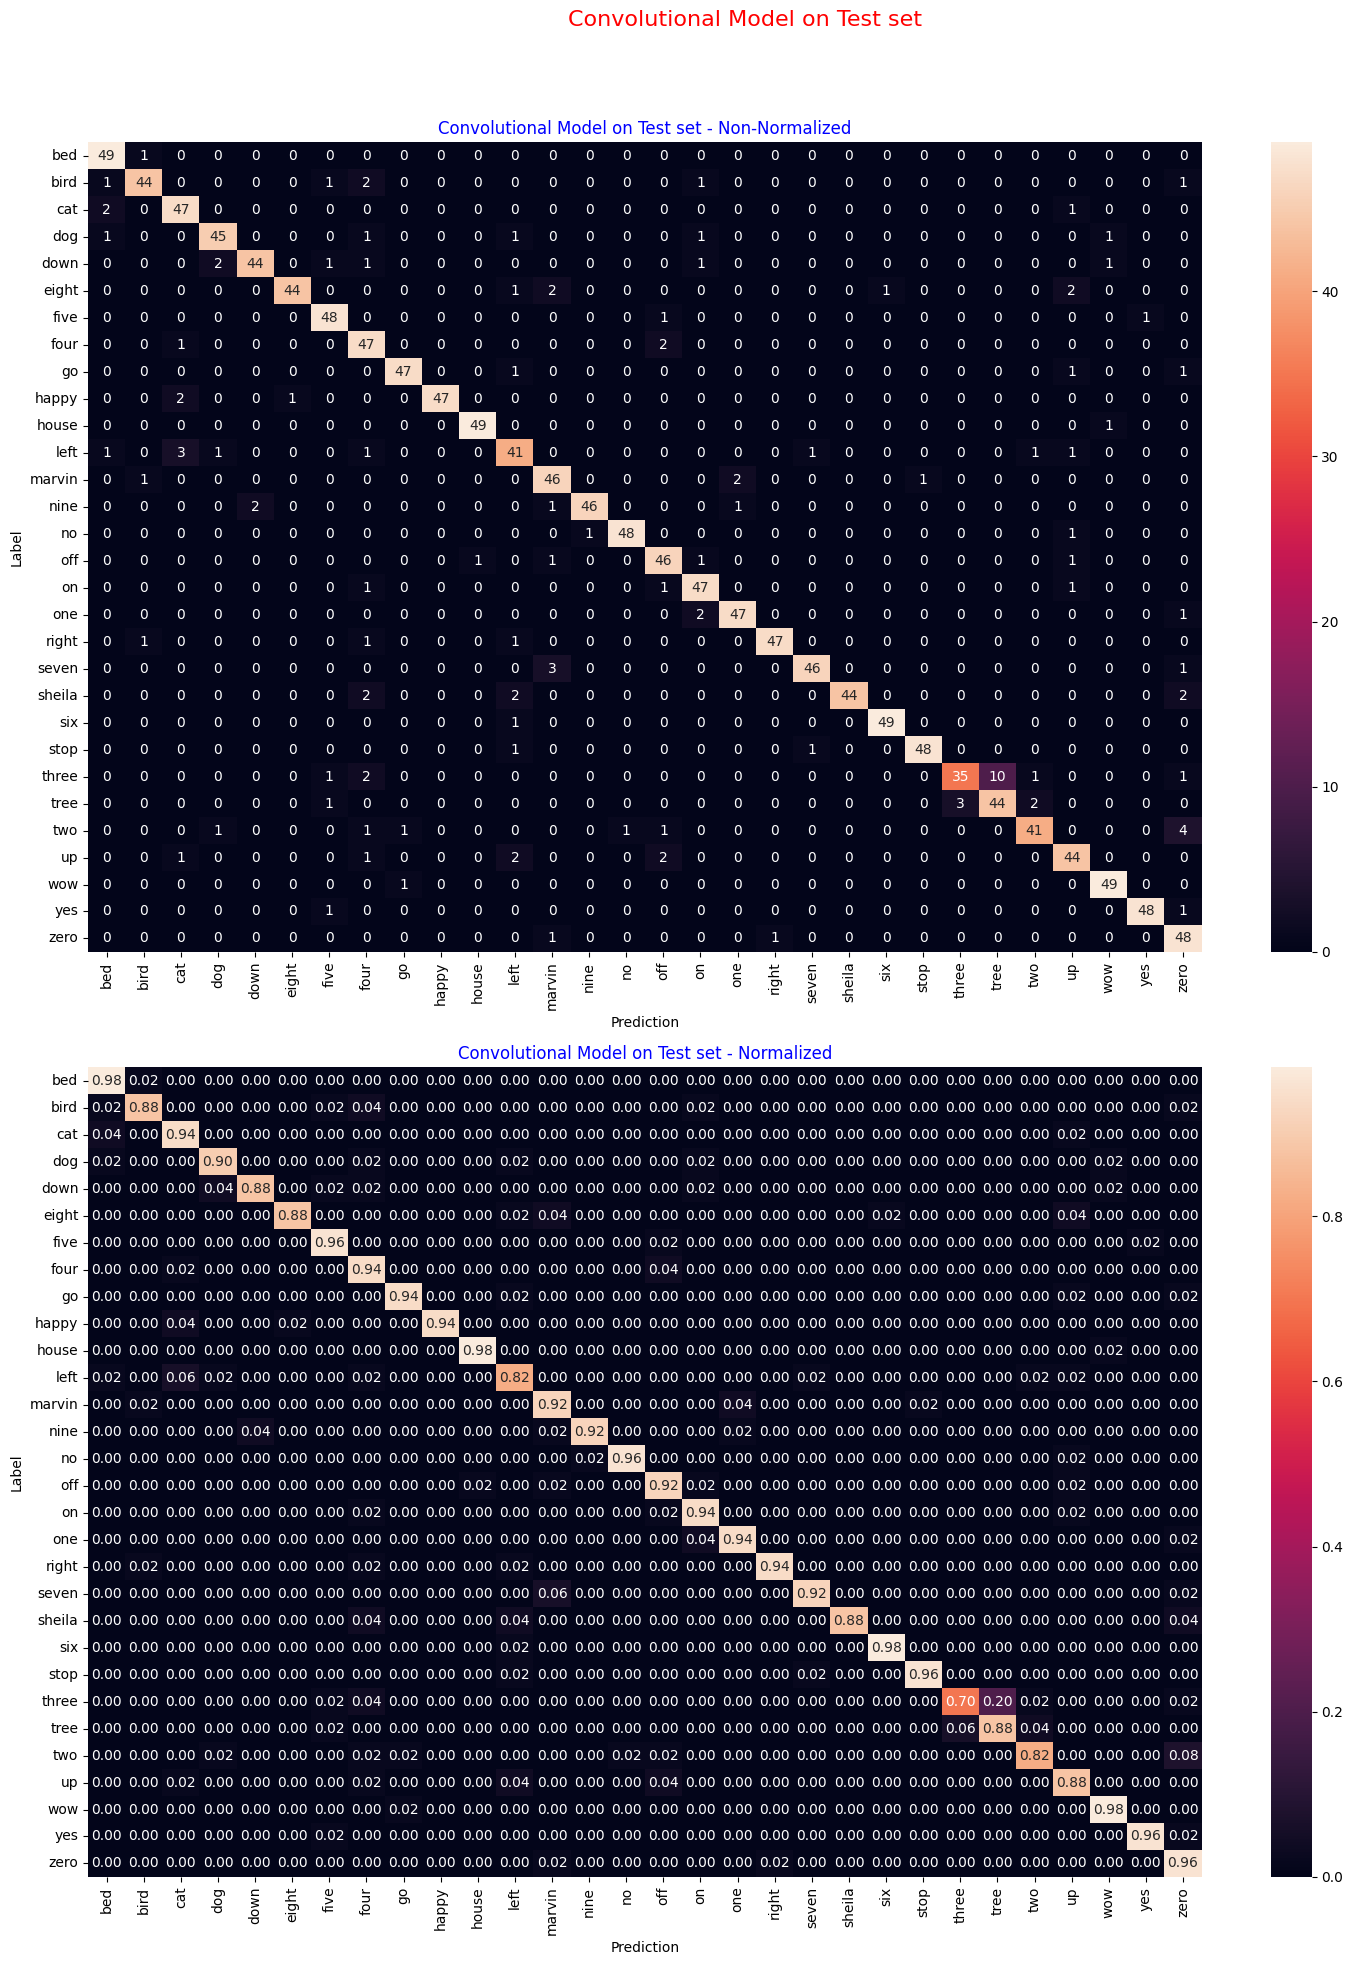

In [ ]:
plot_confusion_matrix(Conv_SFM_model3, test_SFM_ds, class_list, title="Convolutional Model on Test set")

Using a deeper convolutional architecture seems to be not so usefull. So, we can stop here and maybe try to change the approach.

## LSTM Model

One of the major problems of the appraoches used so far is that maybe in our input embeddings there are temporal dependencies that convolutional models are not able to map.

So, an idea is to try to catch this temporal dependencies. The first attempt is to use a Long-Short-Term Memory layer.

Since the overfitting is huge, we directly put some dropout in out LSTM layers.

In [ ]:
LSTM_model_SFM = Sequential([

    Input(shape=INPUT_SHAPE),

    LSTM(128, return_sequences=True),
    Dropout(0.5),

    LSTM(64),
    Dropout(0.5),

    Dense(NUM_CLASSES, activation='softmax'),
])

In [ ]:
LSTM_model_SFM.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, None, 128)           │         459,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_87 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 30)                  │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 510,622 (1.95 MB)

 Trainable params: 510,622 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
LSTM_model_SFM.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

In [ ]:
LSTM_model_SFM_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      min_delta=0.00001,
                                                      verbose=1,
                                                      patience=10,
                                                      restore_best_weights=True)

In [ ]:
EPOCHS = 40
history_LSTM_model_SFM = LSTM_model_SFM.fit(
                          train_SFM_ds,
                          validation_data = validation_SFM_ds,
                          epochs = EPOCHS,
                          callbacks=LSTM_model_SFM_es
                      )

Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.0749 - f1_score: 0.0587 - loss: 3.3689 - val_accuracy: 0.4527 - val_f1_score: 0.4135 - val_loss: 2.8653
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3422 - f1_score: 0.3218 - loss: 2.6077 - val_accuracy: 0.7573 - val_f1_score: 0.7600 - val_loss: 1.5261
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6452 - f1_score: 0.6394 - loss: 1.6228 - val_accuracy: 0.8153 - val_f1_score: 0.8179 - val_loss: 1.0270
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7561 - f1_score: 0.7551 - loss: 1.1813 - val_accuracy: 0.8340 - val_f1_score: 0.8368 - val_loss: 0.8062
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7825 - f1_score: 0.7811 - loss: 0.9826 - val_accuracy: 0.8420 - val_f1_score: 0.8433 - val_loss: 0.6837
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8115 - f1_score: 0.8113 - loss: 0.8516 - val_accuracy: 0.8580 - val_f1_score: 0.8592 - val_lo

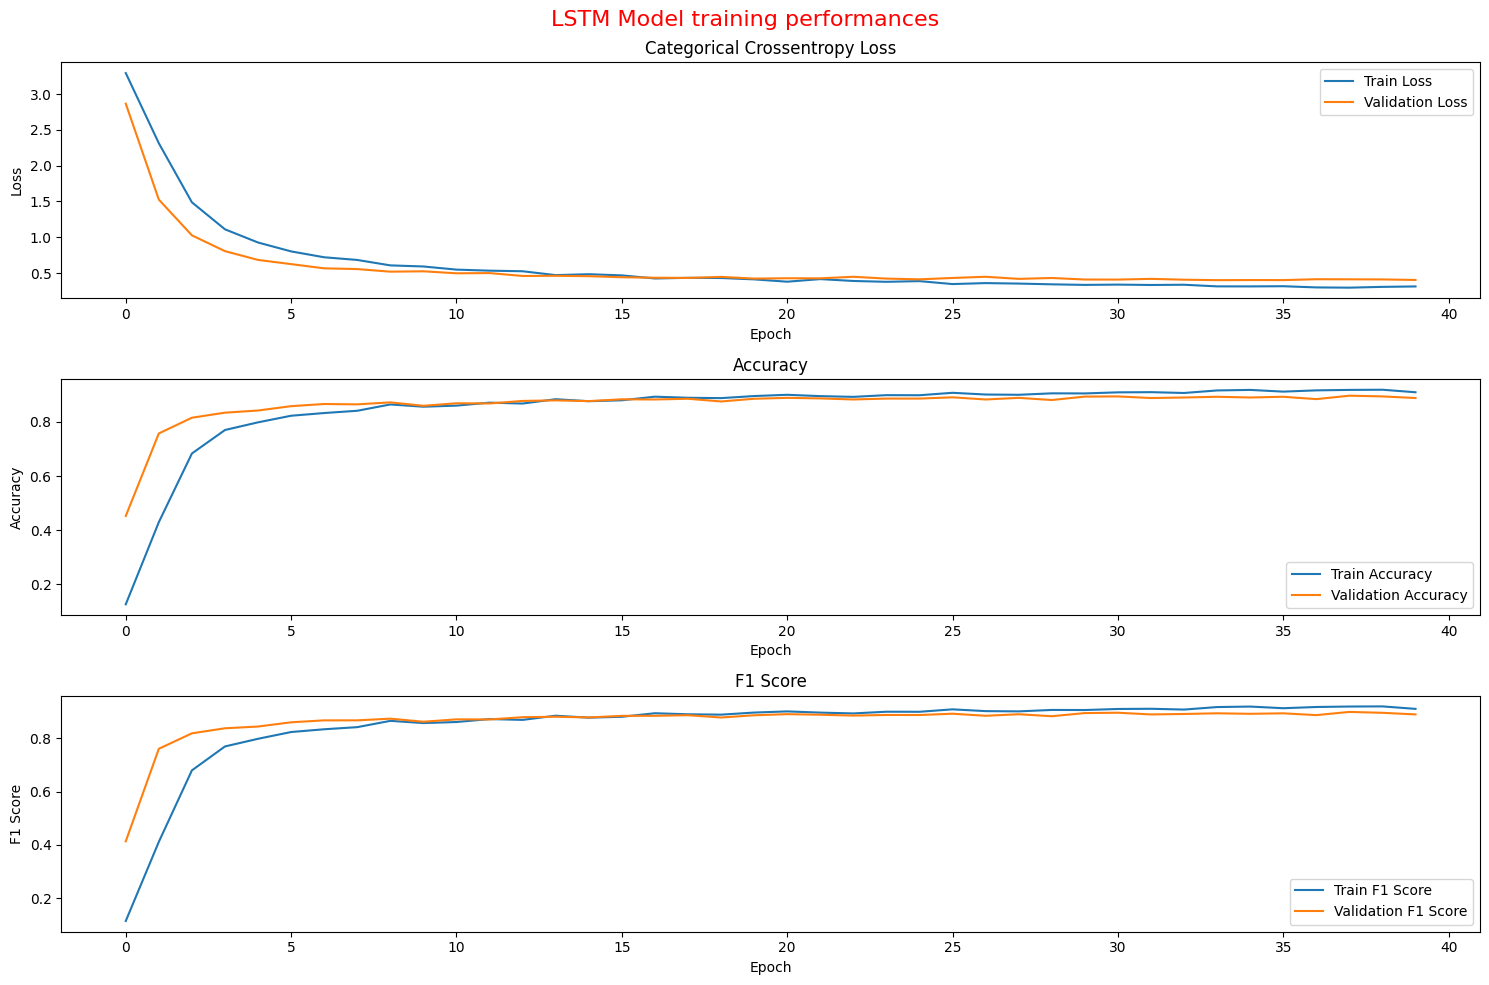

In [ ]:
plot_model_history(history_LSTM_model_SFM, "LSTM Model training performances")

In [ ]:
LSTM_model_SFM_test_metrics = LSTM_model_SFM.evaluate(test_SFM_ds,
                                                        verbose=2,
                                                        return_dict=True)

47/47 - 0s - 4ms/step - accuracy: 0.9127 - f1_score: 0.9138 - loss: 0.3230


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


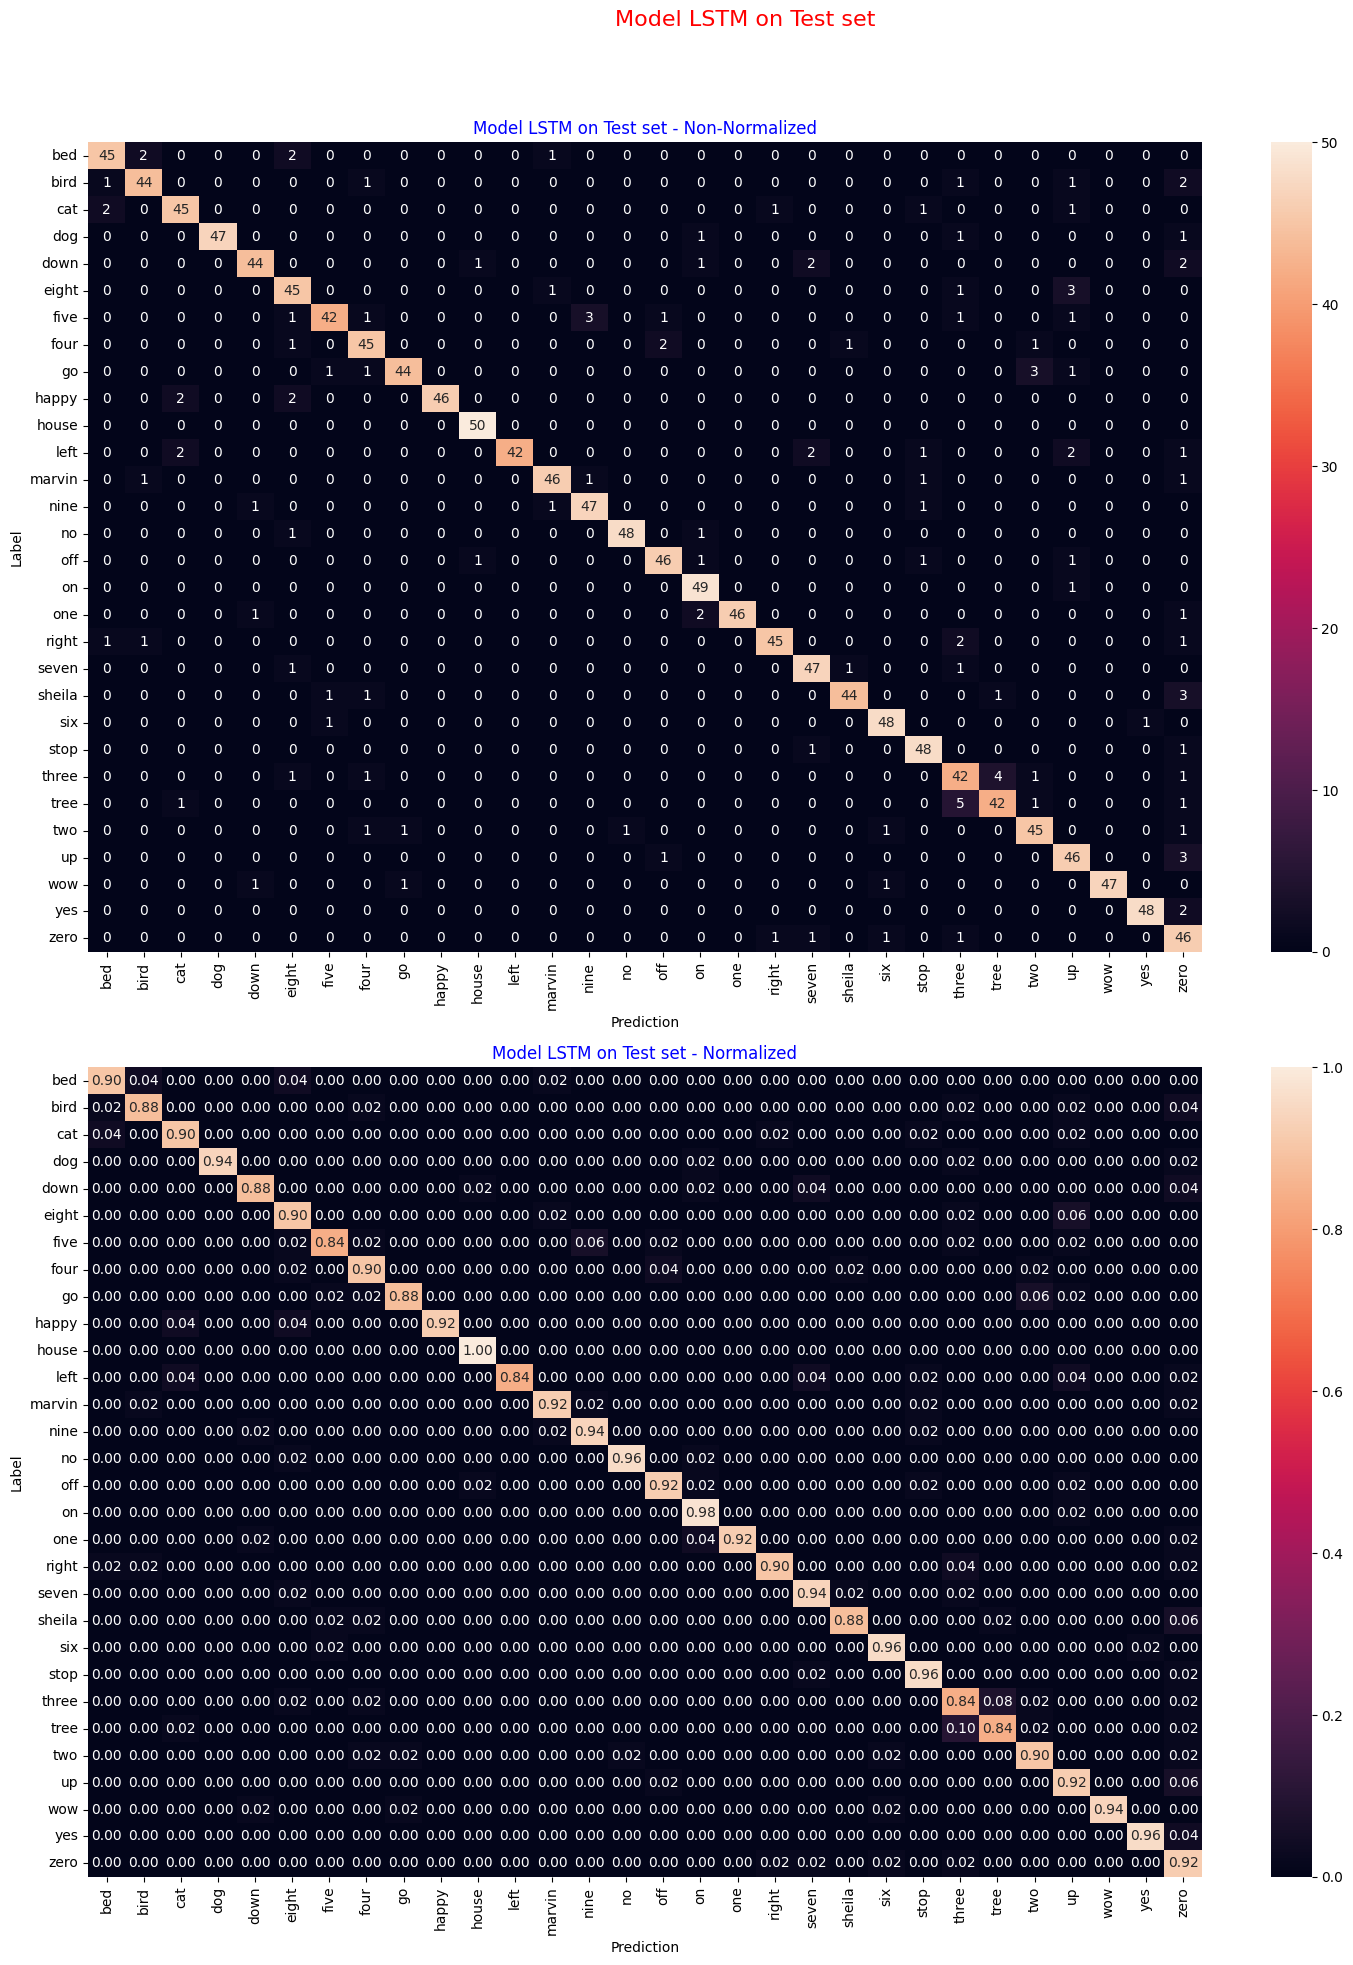

In [ ]:
plot_confusion_matrix(LSTM_model_SFM, test_SFM_ds, class_list, title="Model LSTM on Test set")

The results are more or less the same obtained with a convolutional model.

## Bi-LSTM Model

Since we are in front of a classification task it could be a good idea to also use future informations. So, we want to try to use also the future embeddings in order to perform this classification.

In order to do that we are going to use a Bidirectional LSTM model.

In [ ]:
Bi_LSTM_model_SFM = Sequential([
    Input(shape=INPUT_SHAPE),

    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),

    Bidirectional(LSTM(64)),
    Dropout(0.5),

    Dense(NUM_CLASSES, activation='softmax'),
])

In [ ]:
Bi_LSTM_model_SFM.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, None, 256)           │         918,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_90 (Dropout)                 │ (None, None, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_91 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,086,750 (4.15 MB)

 Trainable params: 1,086,750 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
Bi_LSTM_model_SFM.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

In [ ]:
Bi_LSTM_model_SFM_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      min_delta=0.00001,
                                                      verbose=1,
                                                      patience=10,
                                                      restore_best_weights=True)

In [ ]:
EPOCHS = 100
history_Bi_LSTM_model_SFM = Bi_LSTM_model_SFM.fit(
                          train_SFM_ds,
                          validation_data = validation_SFM_ds,
                          epochs = EPOCHS,
                          callbacks=Bi_LSTM_model_SFM_es
                      )

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.0897 - f1_score: 0.0787 - loss: 3.3194 - val_accuracy: 0.7127 - val_f1_score: 0.7011 - val_loss: 2.0481
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6115 - f1_score: 0.6009 - loss: 1.7522 - val_accuracy: 0.8247 - val_f1_score: 0.8252 - val_loss: 0.8514
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8023 - f1_score: 0.8017 - loss: 0.9236 - val_accuracy: 0.8573 - val_f1_score: 0.8582 - val_loss: 0.6157
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8440 - f1_score: 0.8438 - loss: 0.6543 - val_accuracy: 0.8613 - val_f1_score: 0.8623 - val_loss: 0.5550
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8732 - f1_score: 0.8742 - loss: 0.5576 - val_accuracy: 0.8687 - val_f1_score: 0.8695 - val_loss: 0.5139
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8895 - f1_score: 0.8902 - loss: 0.4738 - val_accuracy: 0.8673 - val_f1_score: 0.8688

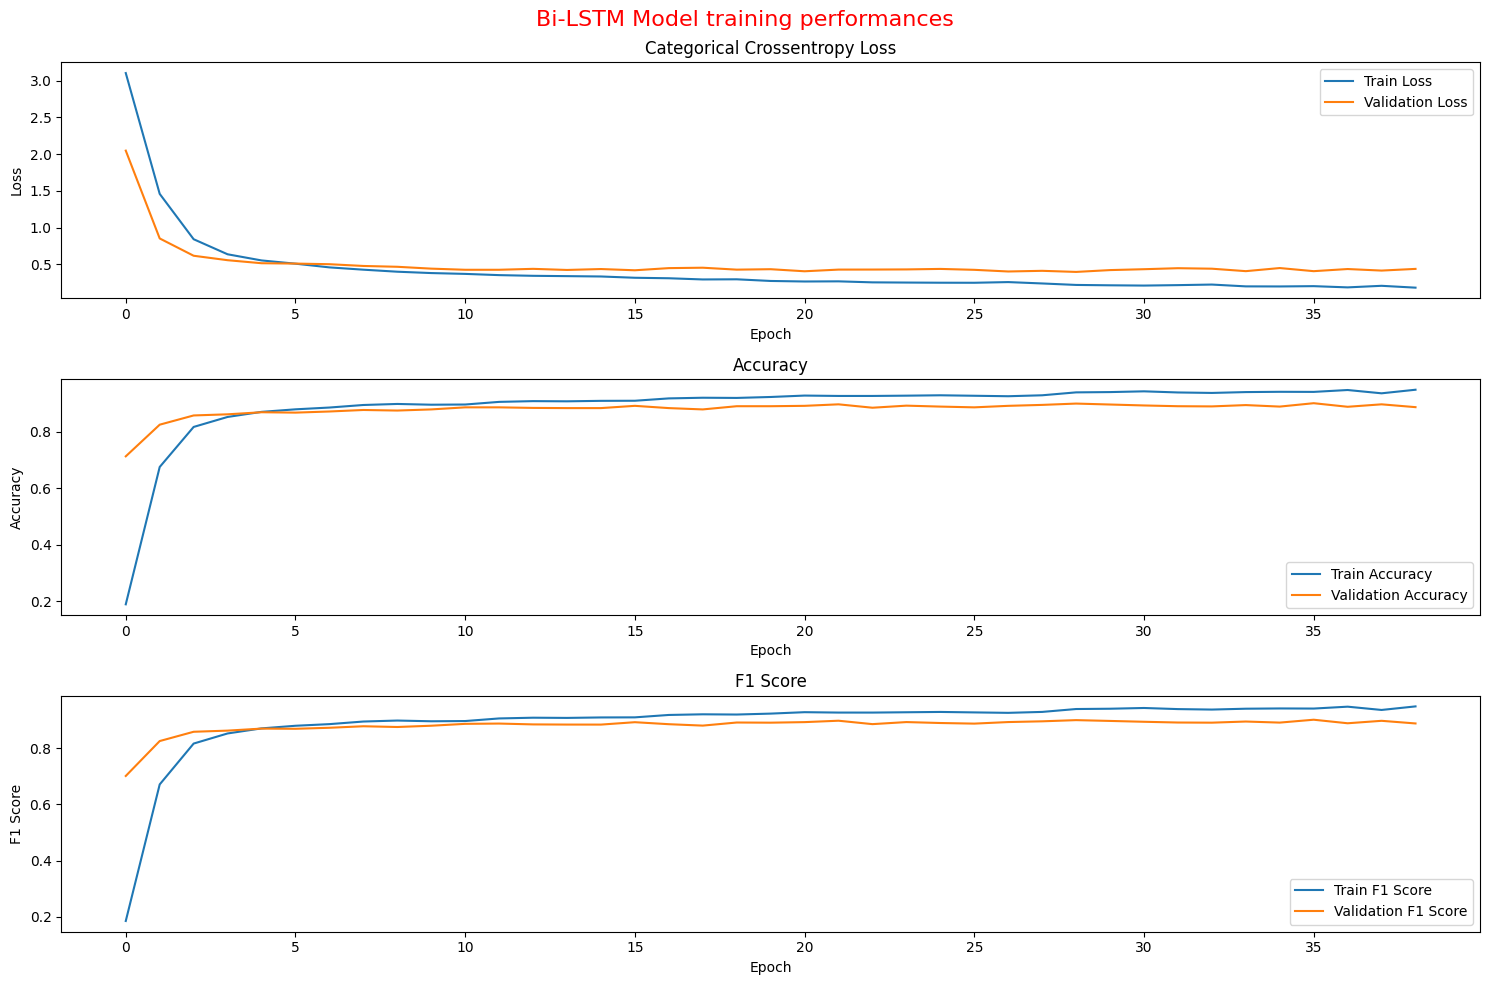

In [ ]:
plot_model_history(history_Bi_LSTM_model_SFM, "Bi-LSTM Model training performances")

In [ ]:
Bi_LSTM_model_SFM_test_metrics = Bi_LSTM_model_SFM.evaluate(test_SFM_ds,
                                                        verbose=2,
                                                        return_dict=True)

47/47 - 0s - 7ms/step - accuracy: 0.9107 - f1_score: 0.9110 - loss: 0.3145


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


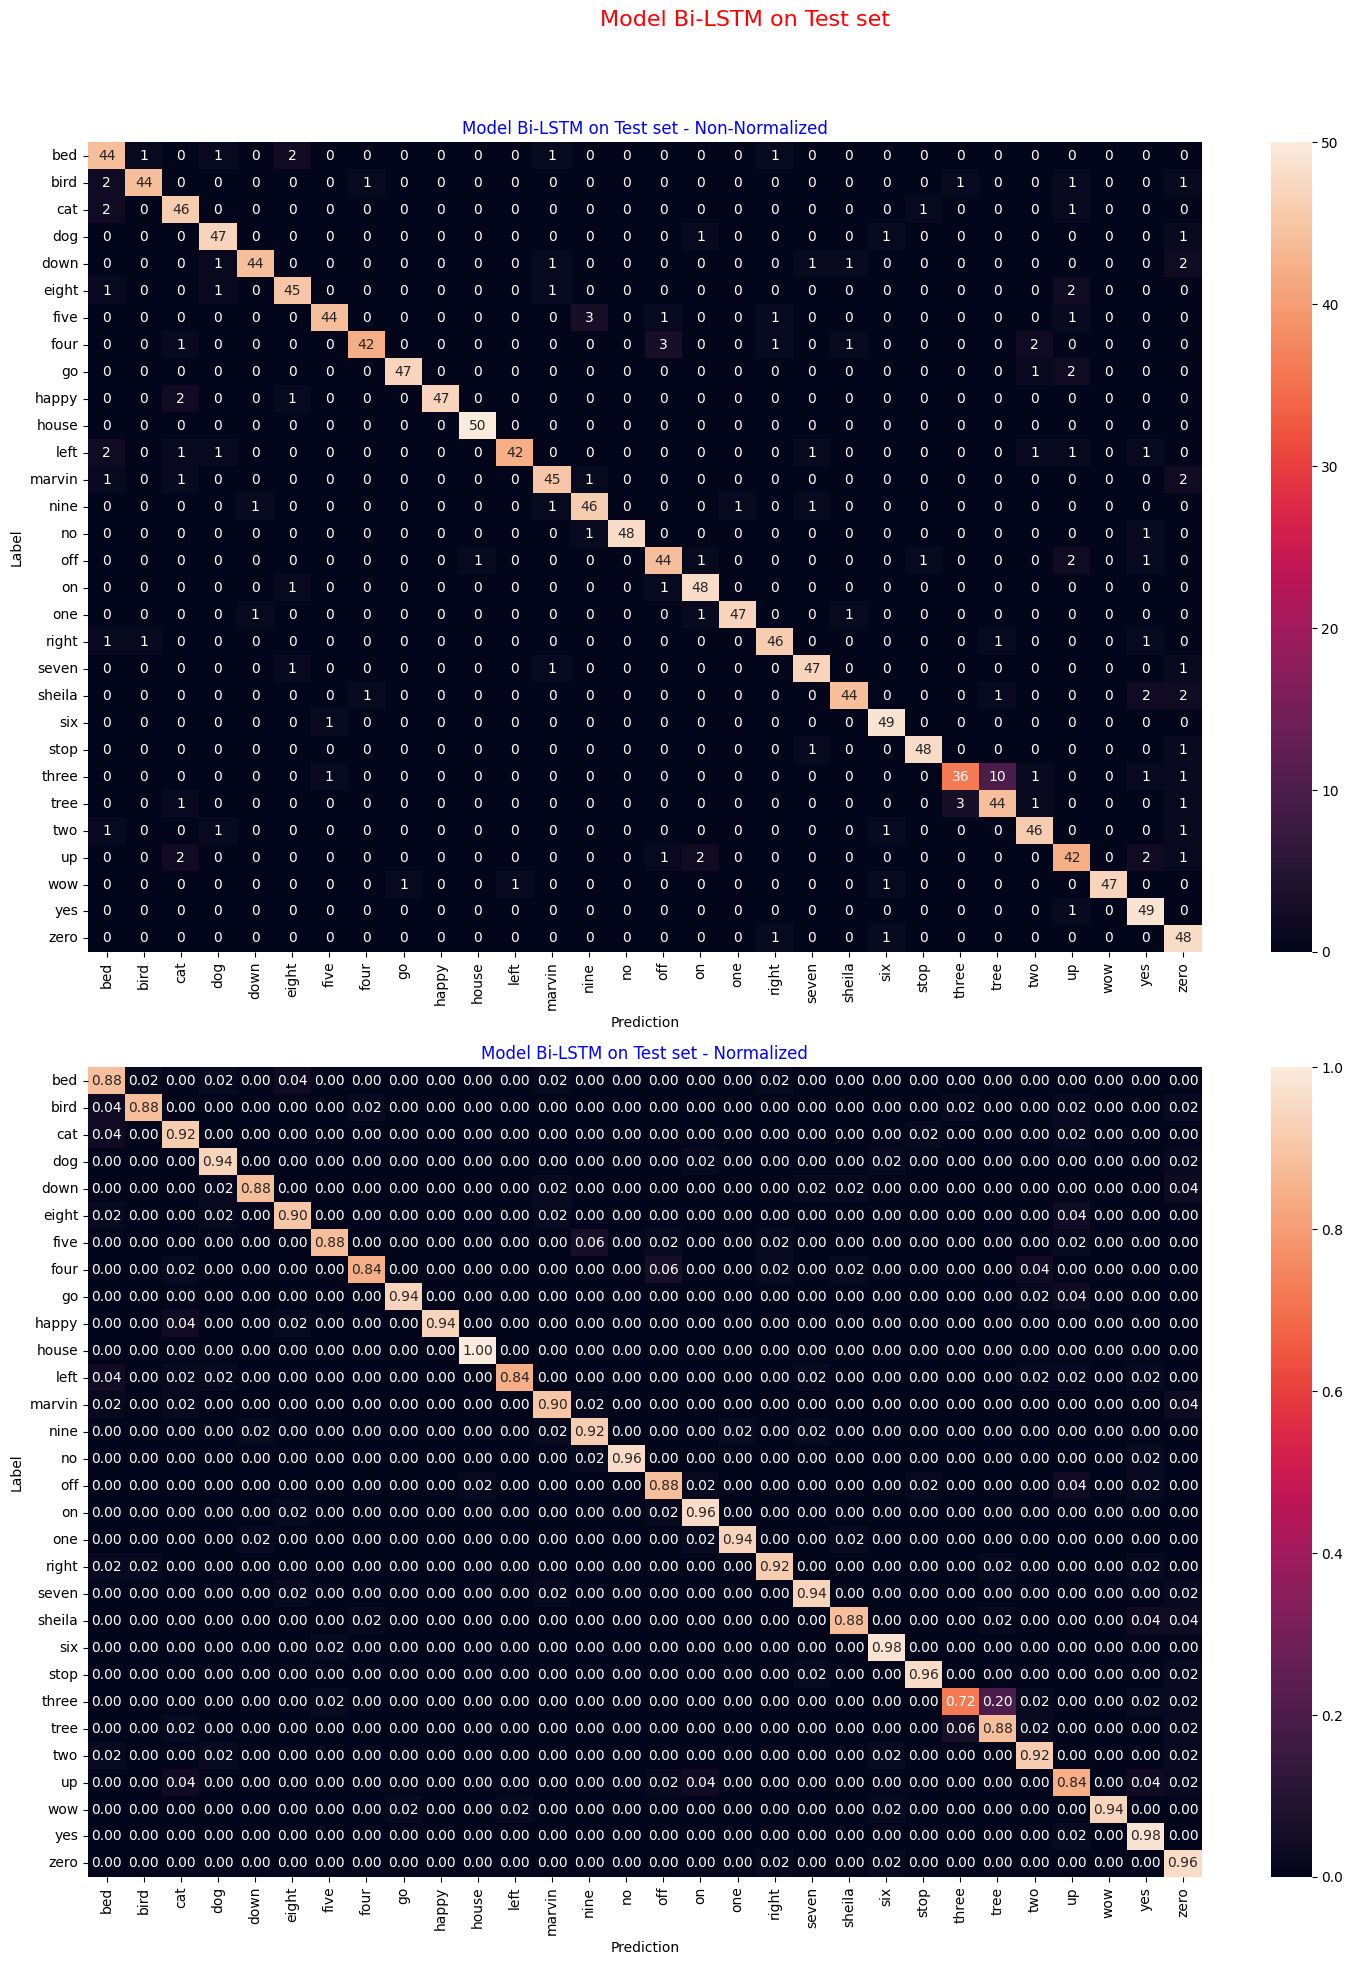

In [ ]:
plot_confusion_matrix(Bi_LSTM_model_SFM, test_SFM_ds, class_list, title="Model Bi-LSTM on Test set")

Using a Bidirectional LSTM seems not to be so effective, the results we obtain are again, more or less the same obtained before.

# Final Considerations

In this short work we decided to perform audio-speech classification using the data from the [TensorFlow Speech Recognition Challenge](https://www.kaggle.com/competitions/tensorflow-speech-recognition-challenge), where audios are devided into 30 classes.

We presented two different approaches:

1.   The first one consists in represents audios through they spectrograms;
2.   The second is based on representing data using Wav2Vec embeddings.



For the first case we presented a convolutional network which is able to classify the spectrograms reaching an F1-Score value of more or less 90%.Then, we tested our data also with VGG16 in order to see if a deeper network should be able outperform our custom model.


For what concerns the second case we presented three different approaches:

*   A convolutional 1-D model;
*   A Long-Short-Term-Memory model;
*   A Bidirectional Long-Short-Term-Memory model.

In all these cases we reached better performances, touching 91-92% of F1-Score.

The results suggest that Wav2Vec embeddings should be abetter representation respect to spectrograms for a downstream classifier.

Also, we can see from the confusion matrices, that all the models present some issues in discriminating between the classes "three" and "tree".





## Results obtained on MFCCs

Here we show the results obtained on test set with the spectrogram representation of our input data.

| Model            | Accuracy   | F1-Score   | Loss |
|------------------|------------|------------|------|
| M1 | 0.61 | 0.60 | 1.45 |
| M2 | 0.63 | 0.62 | 1.32 |
| M3 | 0.81 | 0.81 | 0.69 |
| M4 | 0.84 | 0.84 | 0.57 |
| M5 | 0.88 | 0.88 | 0.41 |
| M6 | 0.90 | 0.90 | 0.35 |
| VGG16 | 0.91 | 0.91 | 0.45 |

From the results we can see that our custom models has been slightly outperform by VGG16. But, the difference in performances is not so much.

## Results obtained on Wav2Vec2 Embeddings

Here we show the results obtained on test set with data represented using Wav2Vec2 embeddings.

| Model            | Accuracy   | F1-Score   | Loss |
|------------------|------------|------------|------|
| Conv-SFM-1 | 0.904 | 0.905 | 0.395 |
| Conv-SFM-2 | 0.914 | 0.915 | 0.395 |
| Conv-SFM-3 | 0.916 | 0.917 | 0.311 |
| LSTM | 0.913 | 0.914 | 0.323 |
| Bi-LSTM | 0.911 | 0.911 | 0.315 |

Note that the performances of all the three appraoches are the same, we  are able to reach maximum the 91% of F1-Score with convolutions and LSTMs.